I'm aiming to predict the number of social information in the ortho clinical notes dataset.

My first hunch is to use a zero-inflated Poission model even though I know it's imperfect. We'll start with this and iterate from there.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [360]:
# UCSF primary
sf_navy = '#052049'
sf_teal = '#18A3AC'
sf_green = '#90BD31'
sf_blue = '#178CCB'
sf_orange = '#F48024'

# UCSF secondary
sf_purple = '#716FB2'
sf_red = '#EC1848'
sf_yellow = '#FFDD00'

# palette
sf_palette = [sf_navy, sf_teal, sf_green, sf_orange, sf_purple, sf_red, sf_yellow, sf_blue]


<IPython.core.display.Javascript object>

**McElreath's general structure**

Taken from [this YouTube video](https://youtu.be/zwRdO9_GGhY?t=2999).
- Express theory as probabilistic program
- Prove planned anlaysis could work (conditionally)
- Test pipeline on synthetic data
- Run pipeline on empirical data


# Import data

In [59]:
output_dir2 = "/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output/"
df_srfs_counts = pd.read_pickle(
    output_dir2 + "df_srfs_cocoa_text_08_final_annotation_social_data_counts.pkl"
)

df_srfs_counts.head()

note_type                file  n_tags n_chars_note
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870

<IPython.core.display.Javascript object>

In [15]:
print("mean: ", df_srfs_counts["n_tags"].mean())
print("var: ", df_srfs_counts["n_tags"].var())

mean:  2.074825618262524
var:  15.49820468086613


<IPython.core.display.Javascript object>

Minimum number of tags, ED_Provider_Notes:  1.0
Minimum number of tags, H&P:  0.0
Minimum number of tags, Patient_Instructions:  0.0
Minimum number of tags, Progress_Notes:  0.0
Minimum number of tags, Telephone_Encounter:  0.0


<ipython-input-12-0a32c053ca07>:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


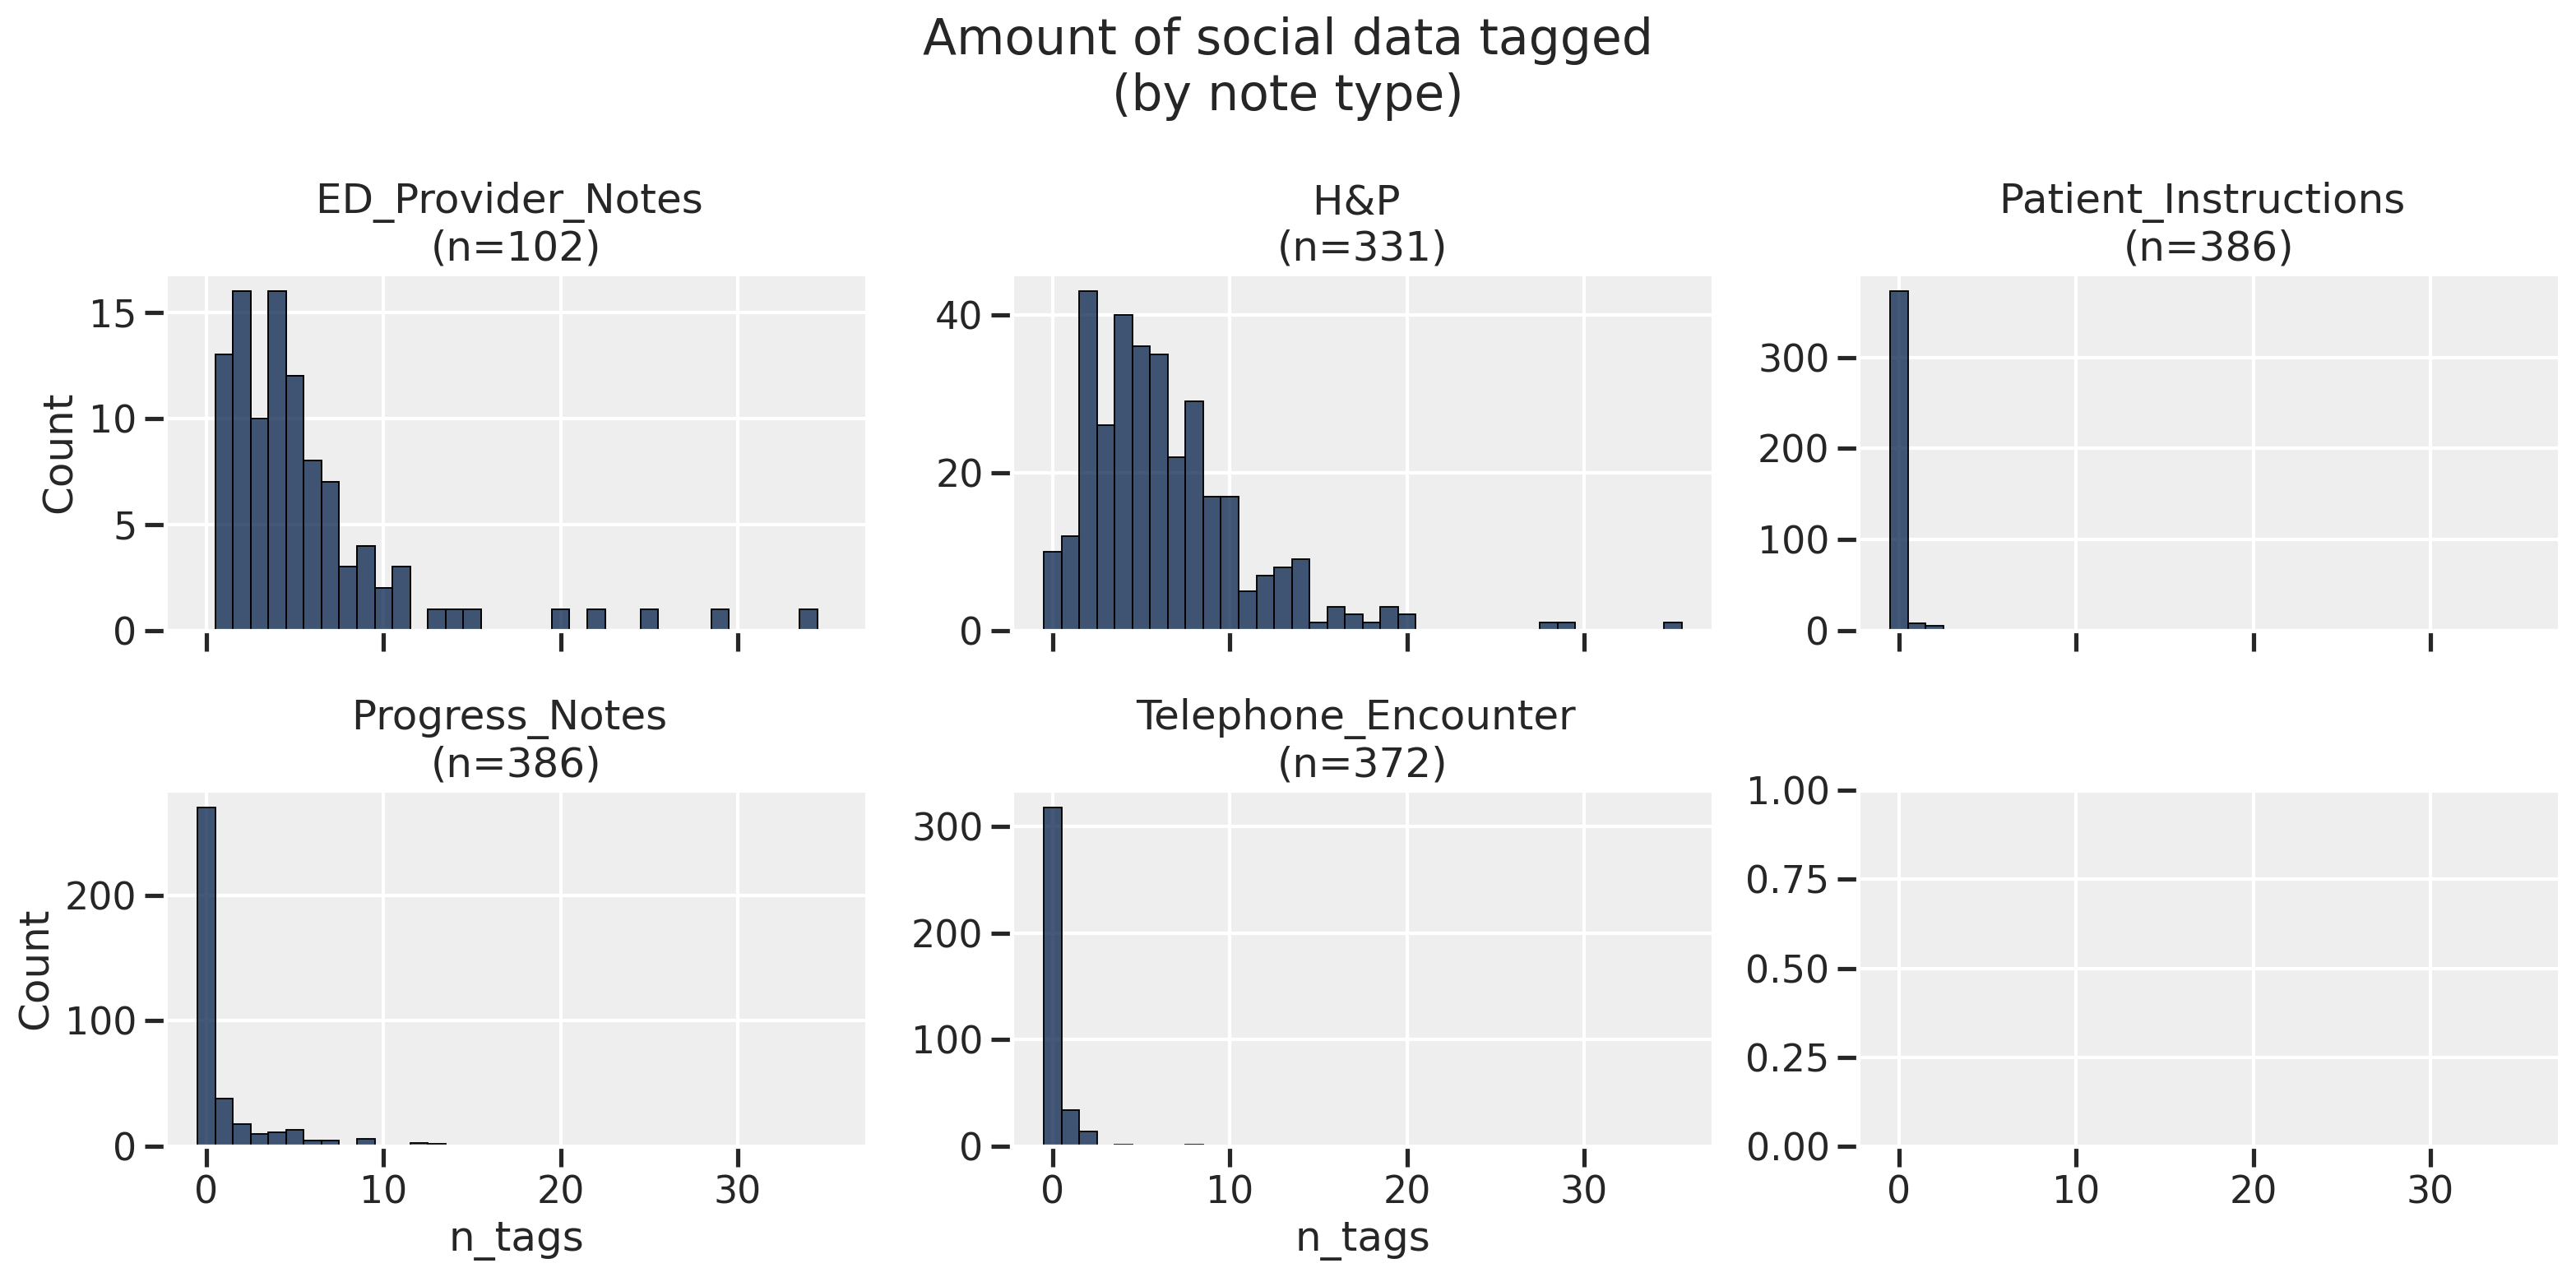

<IPython.core.display.Javascript object>

In [12]:
# Number of notes for each type

note_subfolders = [
    "ED_Provider_Notes",
    "H&P",
    "Patient_Instructions",
    "Progress_Notes",
    "Telephone_Encounter",
]

f, axs = plt.subplots(2, 3, figsize=[16, 8], sharex=True)

for note_type, ax in zip(note_subfolders, axs.flat):
    # Limit df to the note type
    df_temp = df_srfs_counts[df_srfs_counts["note_type"] == note_type].copy()
    n_tags = len(df_temp)

    print("Minimum number of tags, " + note_type + ": ", df_temp["n_tags"].min())

    # Plot histogram for that noteetype
    sns.histplot(df_temp["n_tags"], discrete=True, ax=ax, color=sf_navy)

    # Formatting
    ax.set_title(f"{note_type} \n(n={n_tags})")
    ax.set_ylabel("")

    if ax.is_first_col():
        ax.set_ylabel("Count")

f.suptitle("Amount of social data tagged\n(by note type)")
f.tight_layout()

## Prep dataframe for modeling

Note type is a factor in the amount of social information present so we should include that.

The length of the note is also a factor, but we can include that later.

In [144]:
df_srfs_counts["note_type_code"] = pd.Categorical(df_srfs_counts["note_type"]).codes

<IPython.core.display.Javascript object>

# Linear model

# Poission model

Zero-inflated makes more sense, but let's start with this to understand the mechanics of the model.

## Note type (intercept) only

Let's just start with the different note types as the only variable on the right side of the equation (intercept only).

$$y_i \text{ ~ } \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} \tag{log link}$$ 

$$\alpha_{j} \text{ ~ Normal}(1, 0.5) $$

We use the log link because the Poisson parameter lambda requires a positive value. This ensures that the result  of the intercept (and after we include the beta coefficient) will still work.

A sensical prior was from doing the following exercise. Another consideration is that when choosing alpha, the log term will blow things up on the outcome scale. Remember from the book's tools example:

In [46]:
print(
    "Mean number of tools with alpha with Normal(0,10):  {0:0.2f}".format(
        pm.Lognormal.dist(0, 10).random(size=20_000).mean()
    )
)

print(
    "Mean number of tools with alpha with Normal(3,0.5): {0:0.2f}".format(
        pm.Lognormal.dist(3, 0.5).random(size=20_000).mean()
    ),
)

Mean number of tools with alpha with Normal(0,10):  72283394184653.33
Mean number of tools with alpha with Normal(3,0.5): 22.89


<IPython.core.display.Javascript object>

I peeked at the data, but we can choose something on the scale of the latter as a more sensible prior for the notes data.

### Prior prediction check for alpha

If alpha has a normal distribution, then lambda has a lognormal distribution.

In [265]:
print(
    "Mean of LogNormal(1, 0.5): {0:0.4f}".format(
        pm.Lognormal.dist(1, 0.5).random(size=20_000).mean()
    )
)

Mean of LogNormal(1, 0.5): 3.0757


<IPython.core.display.Javascript object>

It's more intuitive to me to exponentiate the normal distribution and this also works

In [266]:
print(
    "Mean after exponentiating Normal(1, 0.5): {0:0.4f}".format(
        np.exp(pm.Normal.dist(1, 0.5).random(size=20_000)).mean()
    )
)


Mean after exponentiating Normal(1, 0.5): 3.0694


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior distribution for alpha (check)\n exponentiate normal dist')

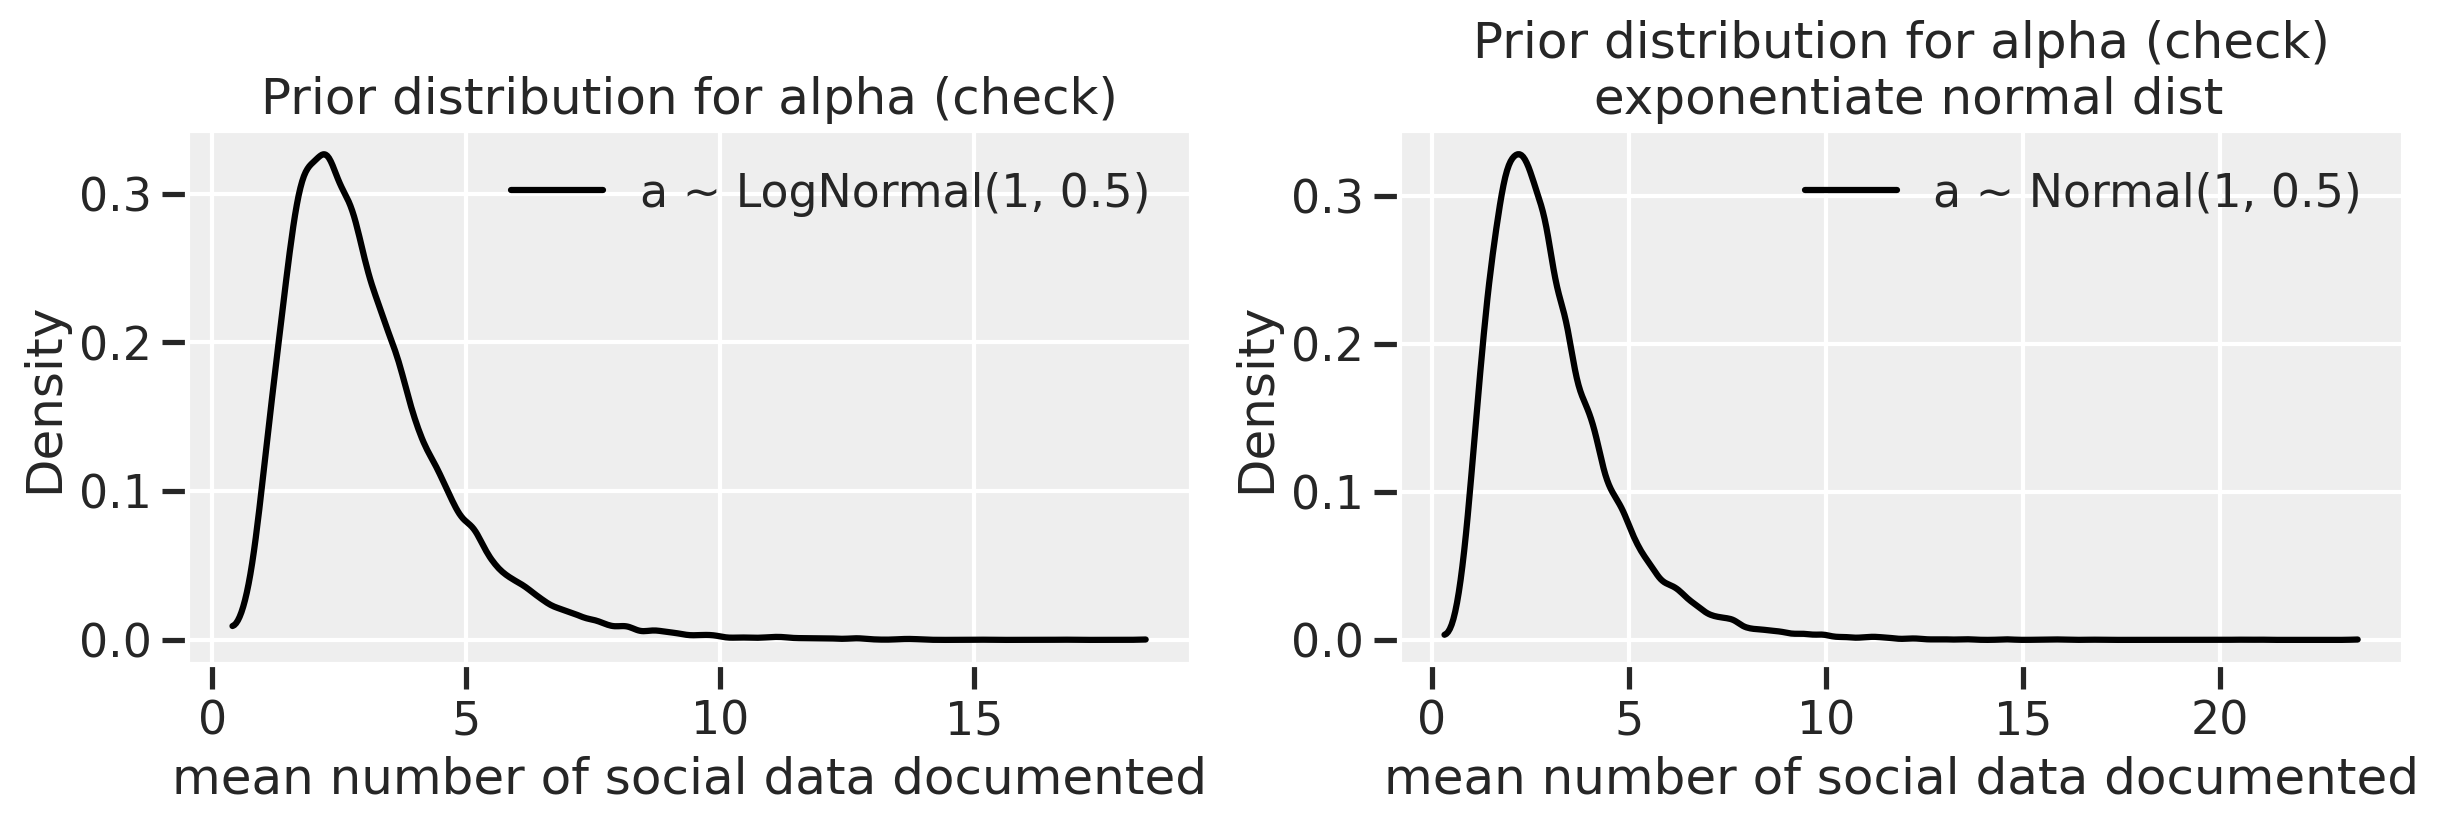

<IPython.core.display.Javascript object>

In [263]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_kde(
    pm.Lognormal.dist(1, 0.5).random(size=20_000),
    label="a ~ LogNormal(1, 0.5)",
    plot_kwargs={"color": "k"},
    ax=ax1,
)
ax1.set_xlabel("mean number of social data documented")
ax1.set_ylabel("Density")
ax1.set_title("Prior distribution for alpha (check)")


az.plot_kde(
    np.exp(pm.Normal.dist(1, 0.5).random(size=20_000)),
    label="a ~ Normal(1, 0.5)",
    plot_kwargs={"color": "k"},
    ax=ax2,
)
ax2.set_xlabel("mean number of social data documented")
ax2.set_ylabel("Density")
ax2.set_title("Prior distribution for alpha (check)\n exponentiate normal dist")

Check out how high the number of social data can be supported in this distribution.

In [291]:
print(
    "Max of LogNormal(1, 1): {0:0.4f}".format(
        pm.Lognormal.dist(1, 0.5).random(size=20_000).max()
    )
)

Max of LogNormal(1, 1): 19.0656


<IPython.core.display.Javascript object>

This is probably too restrictive. Let's try a few more values for both mu and sigma to see if we can get broader distributions.

In [322]:
def plot_alpha_dist(mu, sigma, ax):
    min_dist, mean_dist, max_dist = (
        pm.Lognormal.dist(mu, sigma).random(size=20_000).min(),
        pm.Lognormal.dist(mu, sigma).random(size=20_000).mean(),
        pm.Lognormal.dist(mu, sigma).random(size=20_000).max(),
    )
    az.plot_kde(
        pm.Lognormal.dist(mu, sigma).random(size=20_000),
        plot_kwargs={"color": "k"},
        label=f"Min: {min_dist:0.2f}\nMean: {mean_dist:0.2f}\nMax: {max_dist:0.2f}",
        ax=ax,
    )

    ax.set_xlabel("number of social data documented")
    ax.set_ylabel("Density")
    ax.set_title(f"a ~ LogNormal({mu}, {sigma})")

<IPython.core.display.Javascript object>

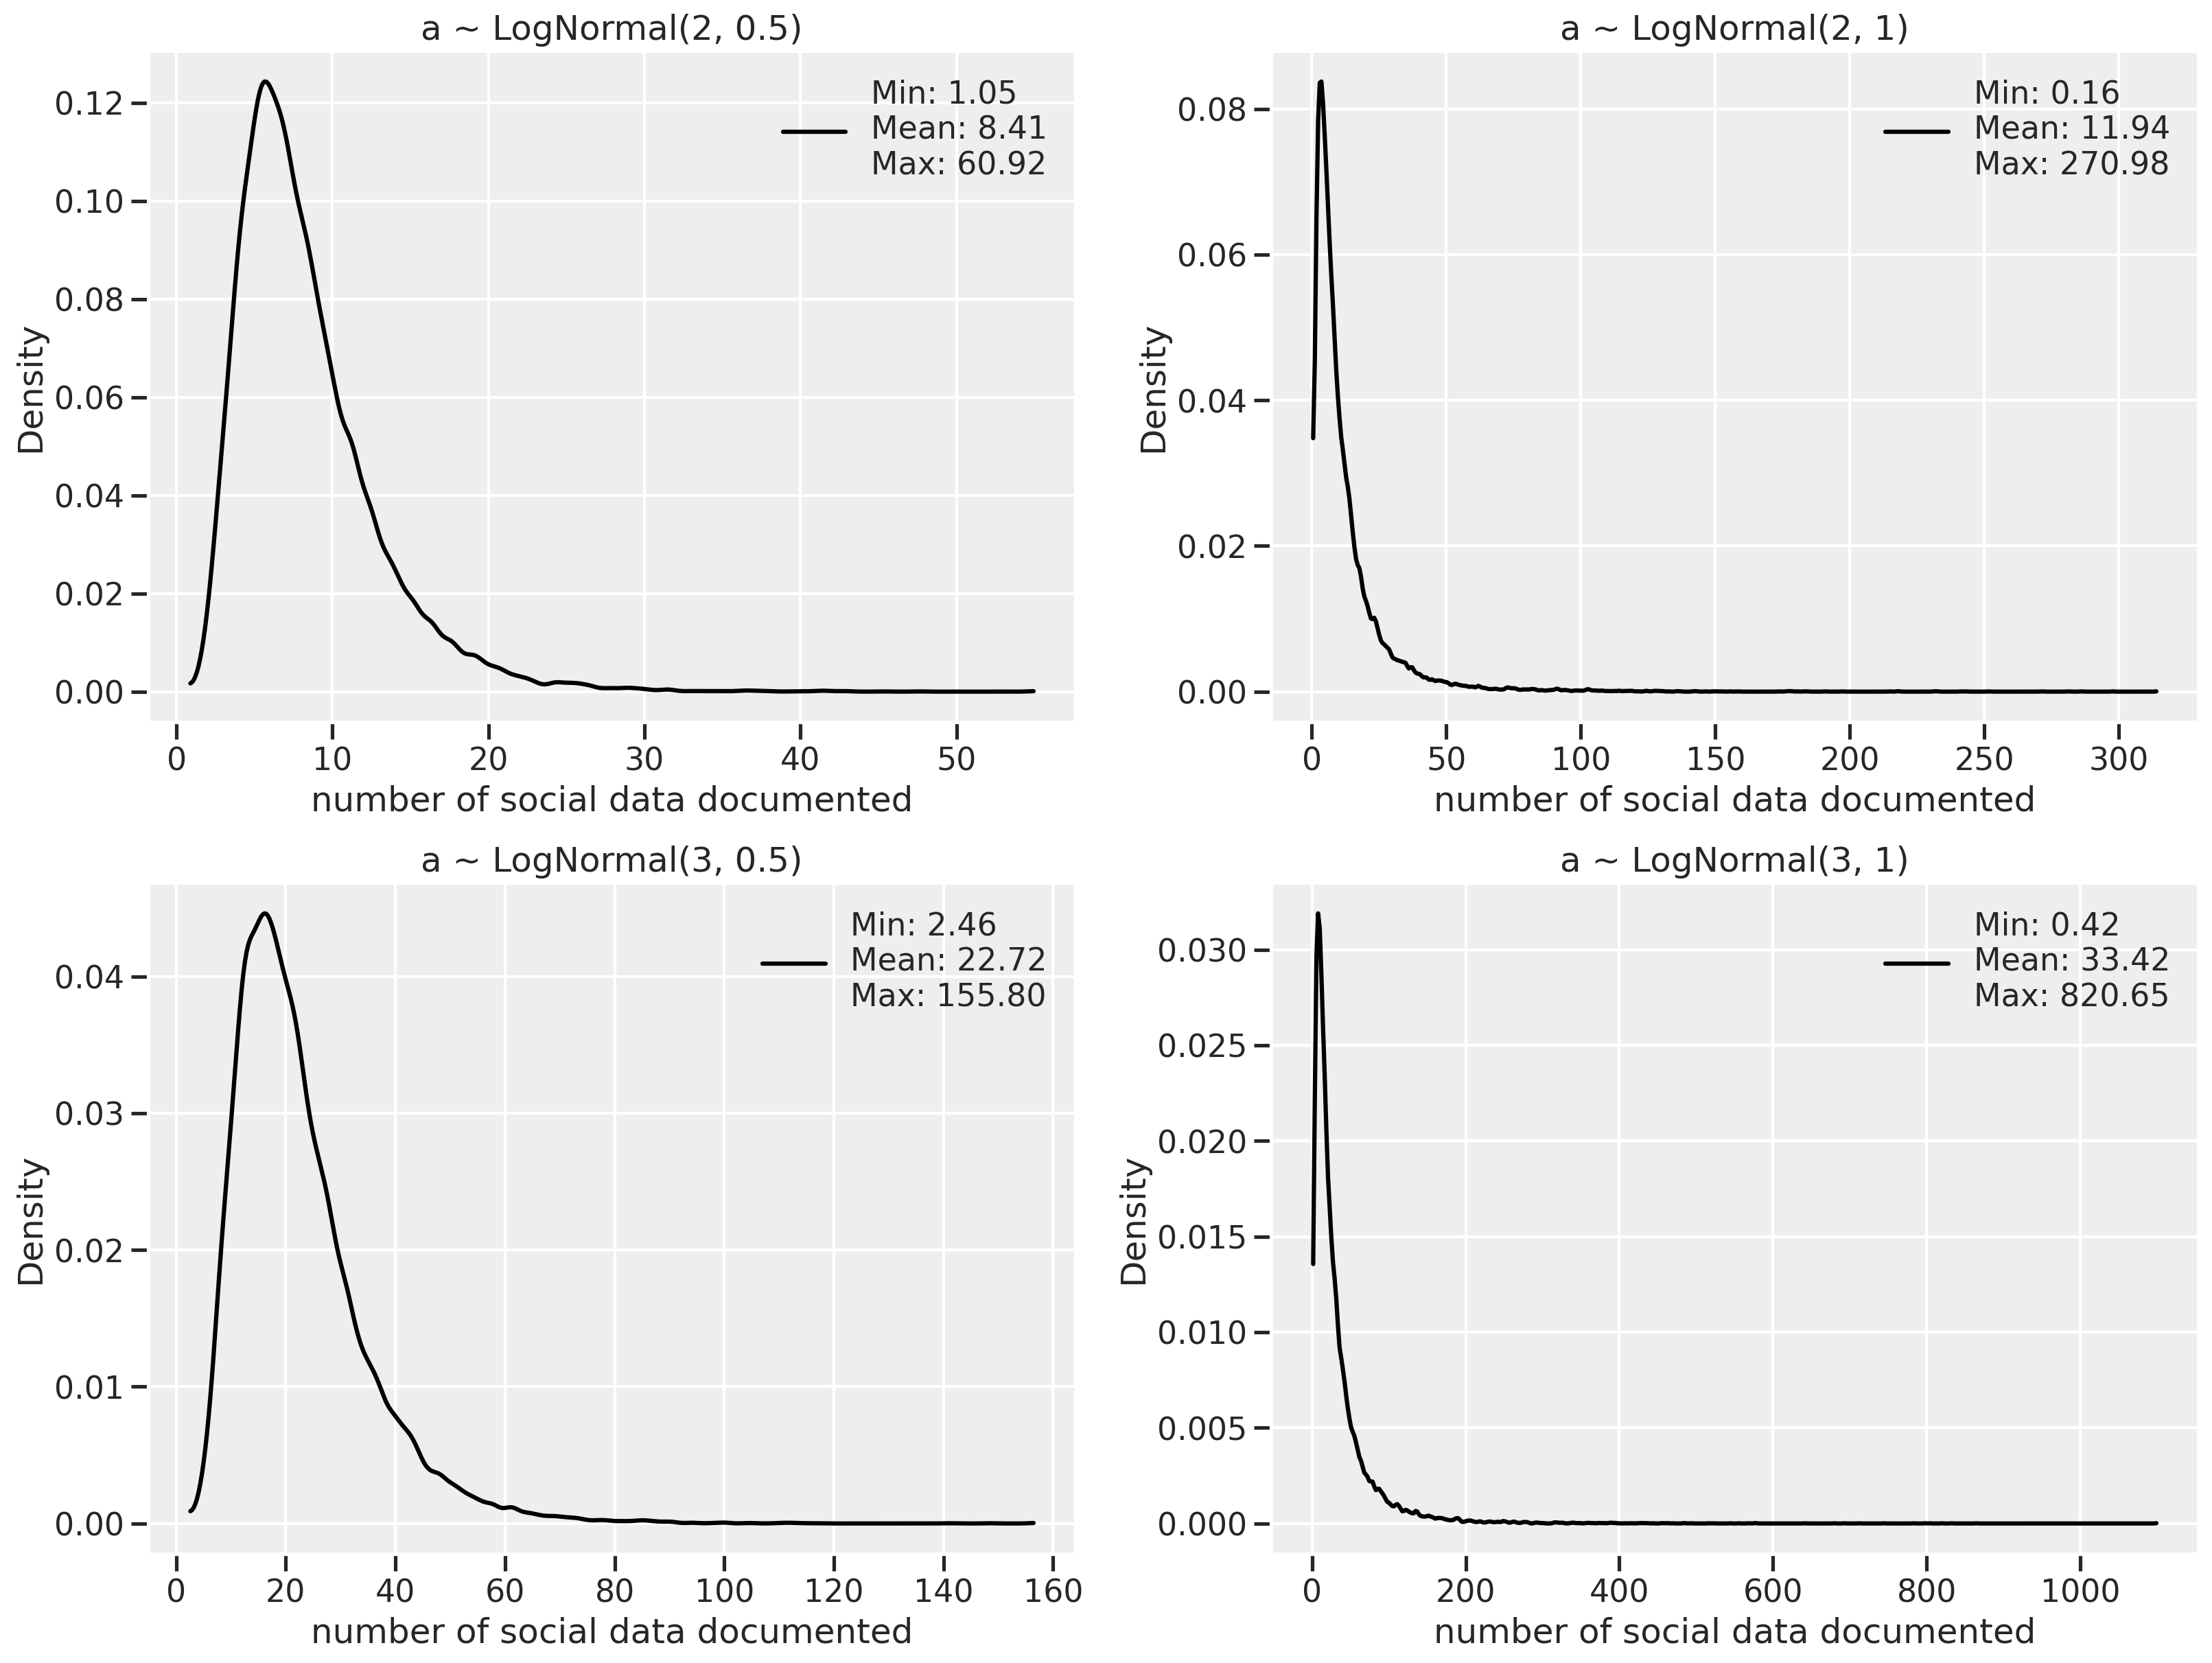

<IPython.core.display.Javascript object>

In [338]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plot_alpha_dist(2, 0.5, ax1)
plot_alpha_dist(2, 1, ax2)
plot_alpha_dist(3, 0.5, ax3)
plot_alpha_dist(3, 1, ax4)

There are several decent options but I'll go with an alpha prior of `LogNormal(2,1)`. The distribution provides support for near 0 and the mean and max number of social data documented look reasonable.

In [339]:
# Intercept only model
with pm.Model() as m_notes1:
    # Prior chosen based on above
    a = pm.Normal("a", 2, 1, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.Deterministic("lam", pm.math.exp(a[df_srfs_counts["note_type_code"]]))

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["n_tags"])

    trace_m_notes1 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [340]:
az.summary(trace_m_notes1, var_names="a", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]  1.74  0.04      1.67       1.81        0.0      0.0   6705.37  6657.54   
a[1]  1.85  0.02      1.82       1.88        0.0      0.0   7599.38  7599.38   
a[2] -2.85  0.21     -3.17      -2.51        0.0      0.0   7160.84  7069.77   
a[3]  0.20  0.04      0.13       0.27        0.0      0.0   7243.87  6708.22   
a[4] -1.33  0.10     -1.49      -1.17        0.0      0.0   5916.51  5906.00   

      ess_bulk  ess_tail  r_hat  
a[0]   6720.05   2877.69    1.0  
a[1]   7620.07   3386.26    1.0  
a[2]   7141.25   3007.66    1.0  
a[3]   7278.03   3259.47    1.0  
a[4]   5729.23   3213.73    1.0

<IPython.core.display.Javascript object>

In [341]:
# Verification that code assignment is alphabetical order
df_srfs_counts[["note_type", "note_type_code"]].drop_duplicates()

note_type  note_type_code
0        ED_Provider_Notes               0
102                    H&P               1
433   Patient_Instructions               2
819         Progress_Notes               3
1205   Telephone_Encounter               4

<IPython.core.display.Javascript object>

Since this model is pretty simple, we can have some interpretation of the alpha parameters. The pattern of alpha being negative for `Patient_Instructions` and `Telephone_Encounter` is in line with most notes of these types having a low number of social data documented.

To get more intuition of these parameters, we can make posterior predictions.

In [342]:
with m_notes1:
    post_pc = pm.sample_posterior_predictive(trace=trace_m_notes1)

<IPython.core.display.Javascript object>

In [343]:
post_pc["t"].shape

(4000, 1577)

<IPython.core.display.Javascript object>

In [344]:
post_pc["t"][0, :]

array([8, 8, 8, ..., 1, 2, 0])

<IPython.core.display.Javascript object>

In [346]:
# Make a temp dataframe so I can use seaborn scatterplot
df_srfs_counts_temp = df_srfs_counts.copy()
df_srfs_counts_temp["model1_postpred_sample0"] = post_pc["t"][0, :]
df_srfs_counts_temp.head()

note_type                file  n_tags n_chars_note  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870   

   n_chars_note_std  note_type_code  pareto_k  model1_postpred_sample0  
0          1.194551               0  0.035130                        8  
1          1.069144               0 -0.102141                        8  
2          0.720790               0 -0.081465                        8  
3          2.799138               0  0.048422                        7  
4          1.008602               0  0.036835                        9

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'observed vs. predicted (first sample)')

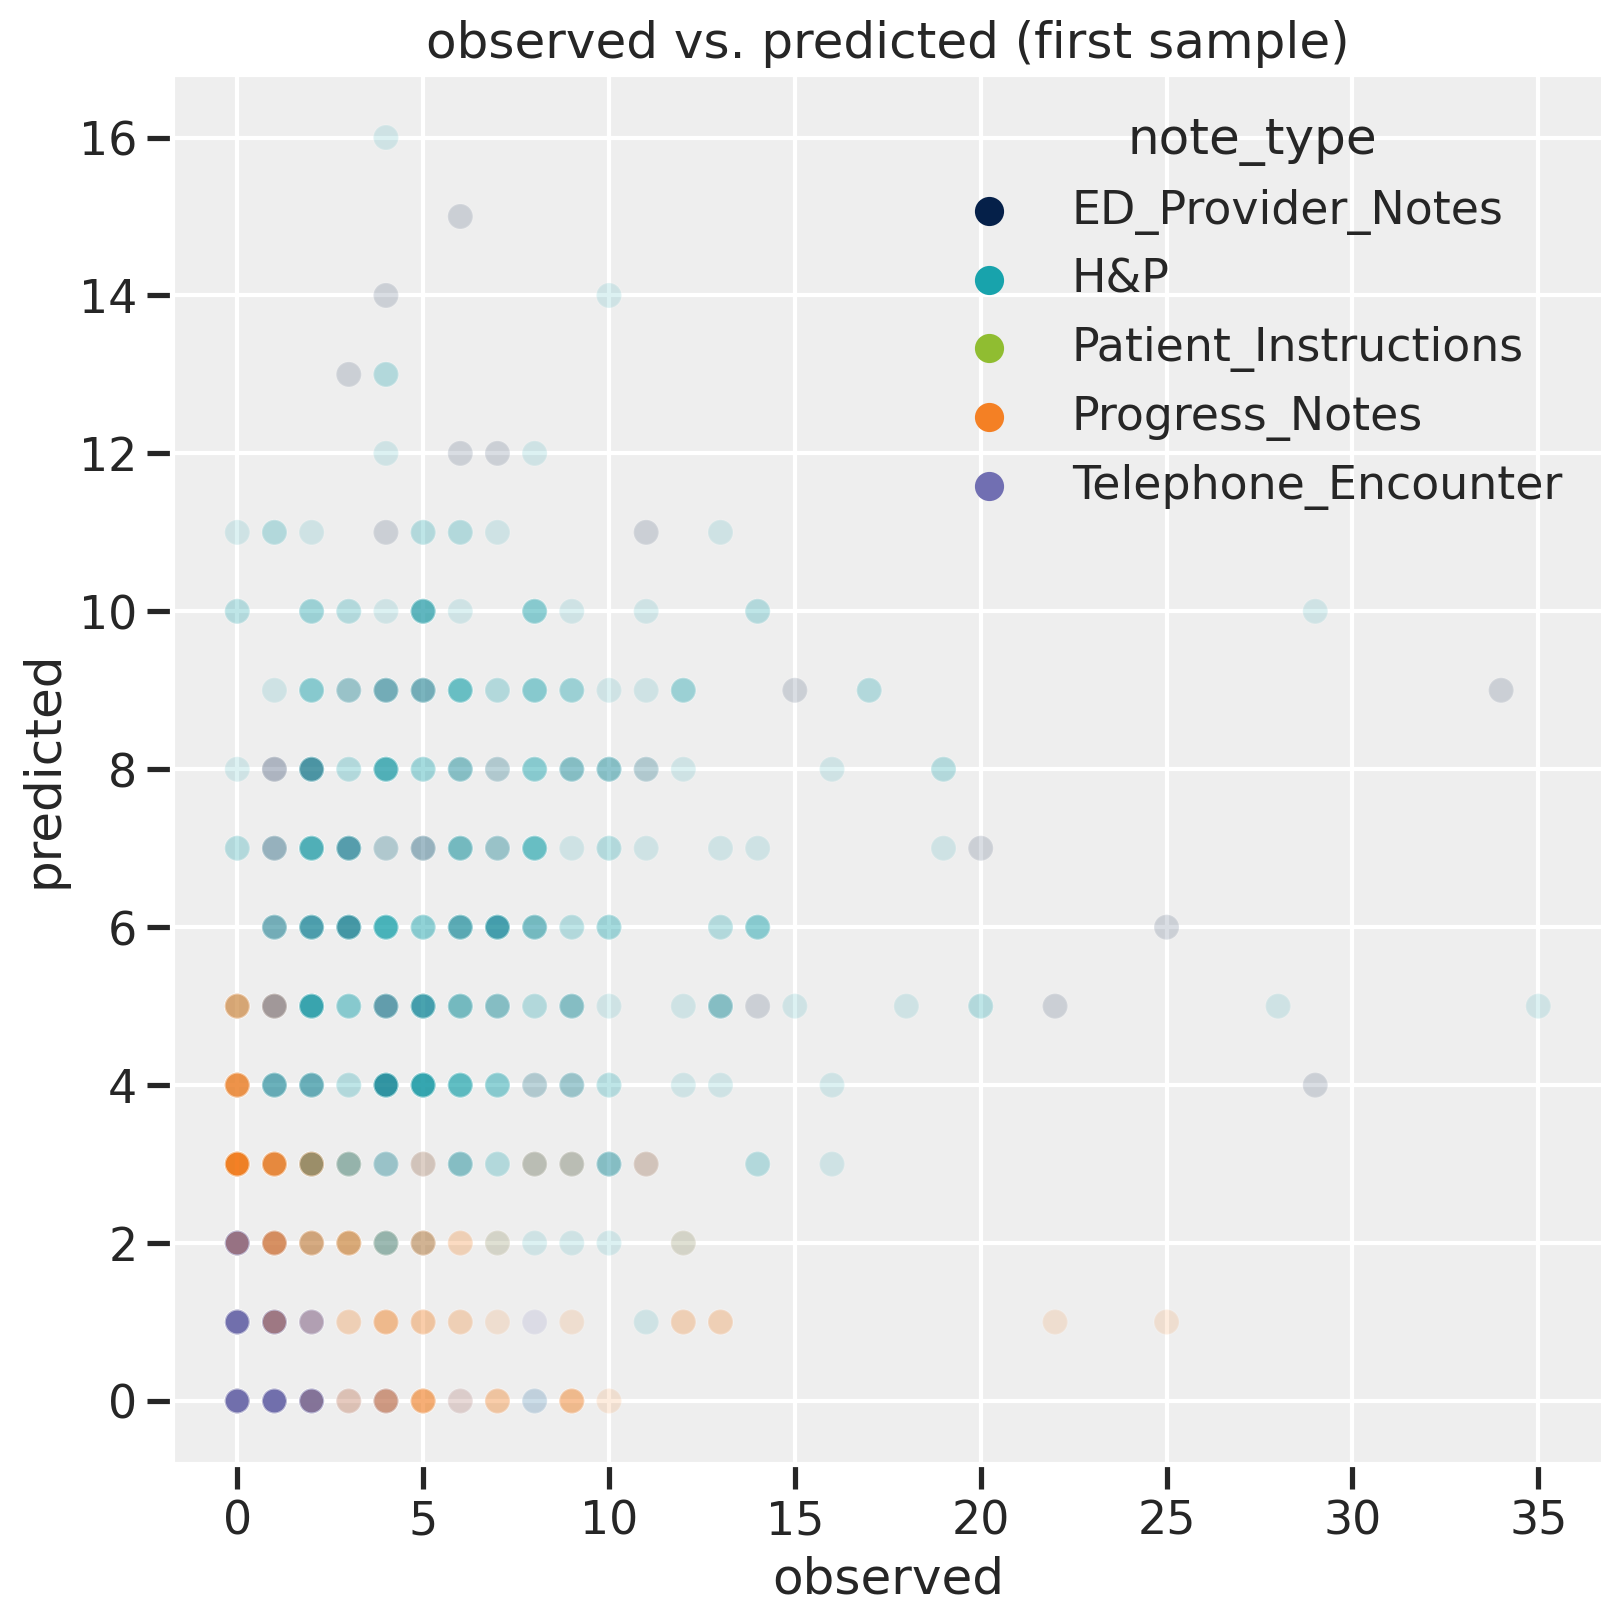

<IPython.core.display.Javascript object>

In [372]:
f, ax1 = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=df_srfs_counts_temp,
    x="n_tags",
    y="model1_postpred_sample0",
    hue="note_type",
    palette=sf_palette[0:5],
    alpha=0.15,
    ax=ax1,
)

ax1.set_xlabel("observed")
ax1.set_ylabel("predicted")
ax1.set_title("observed vs. predicted (first sample)")

It's hard to see overlaps so let's plot it separately.

In [385]:
# can't get this to work, just write own code
# g, ax1 = plt.subplots(figsize=(12, 12))
# g = sns.FacetGrid(df_srfs_counts_temp, col="note_type")
# g.map(sns.scatterplot, "n_tags", "model1_postpred_sample0")

# ax1.set_xlabel("test")

<IPython.core.display.Javascript object>

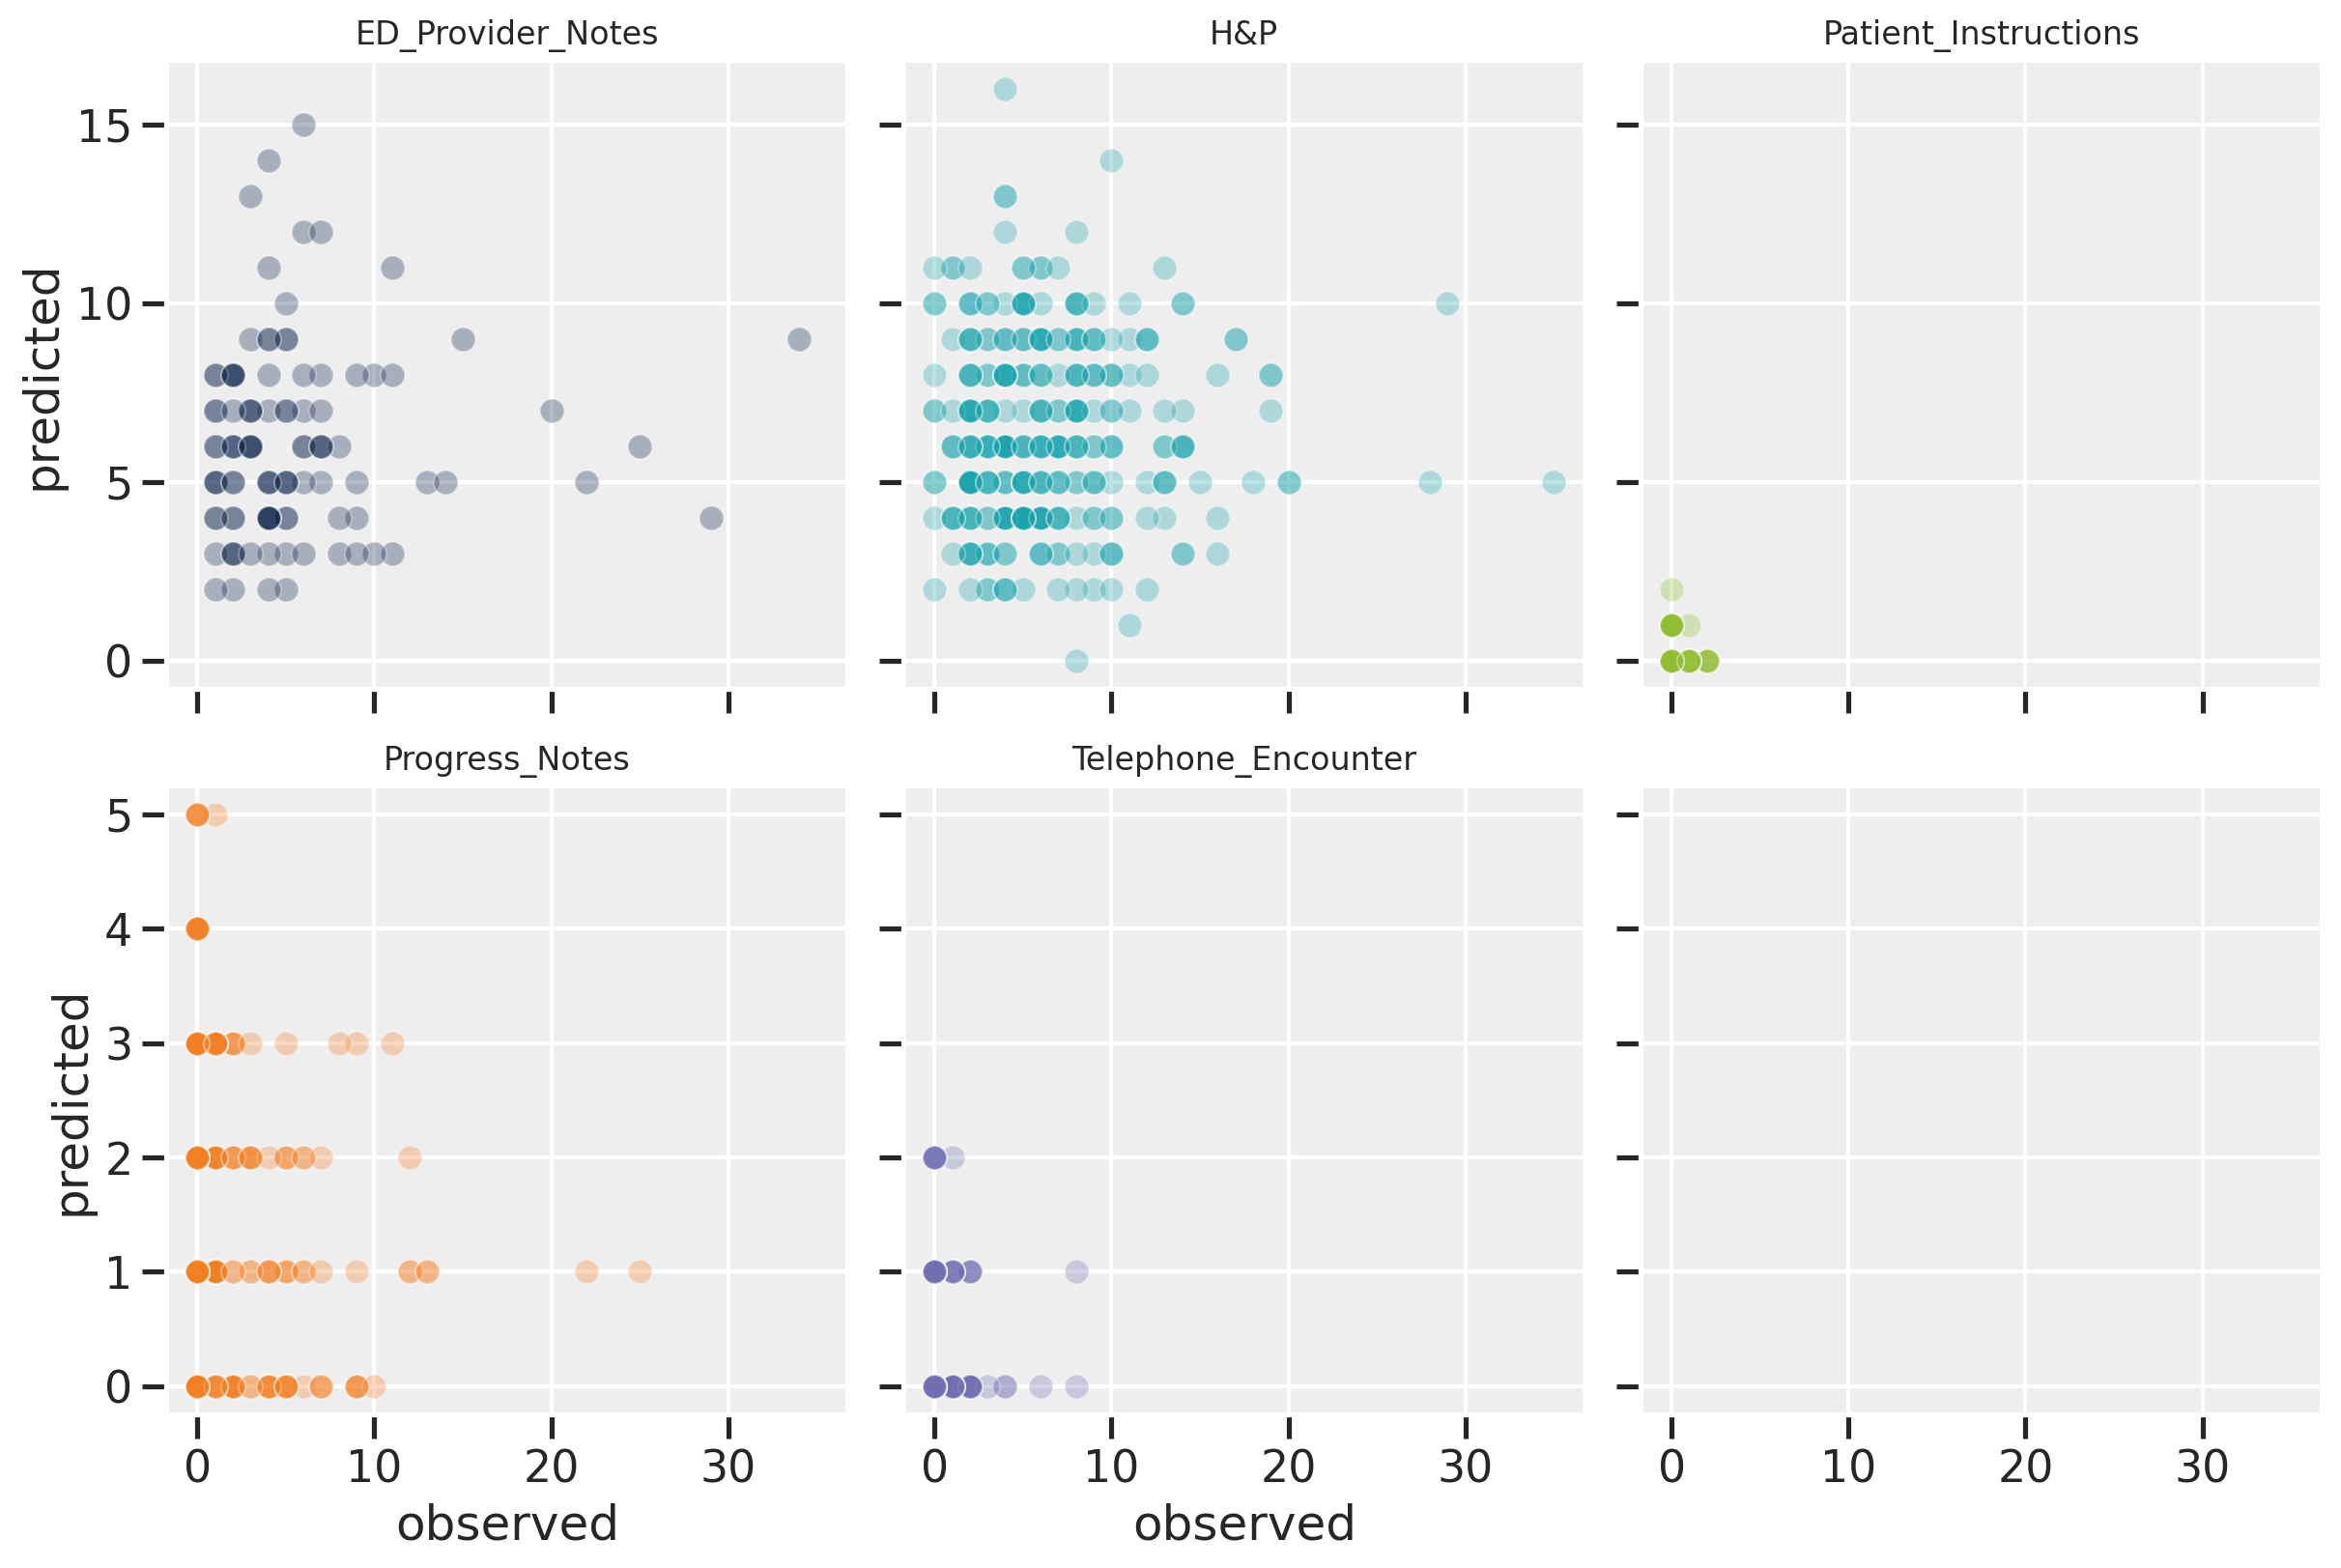

<IPython.core.display.Javascript object>

In [384]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey="row")
note_types = df_srfs_counts_temp["note_type"].unique()
colors = sf_palette[0:5]

for note_type, color, ax in zip(note_types, colors, axs.flat):
    df_srfs_counts_temp_note = df_srfs_counts_temp[
        df_srfs_counts_temp["note_type"] == note_type
    ].copy()

    sns.scatterplot(
        data=df_srfs_counts_temp_note,
        x="n_tags",
        y="model1_postpred_sample0",
        color=color,
        alpha=0.3,
        ax=ax,
    )

    ax.set_xlabel("observed")
    ax.set_ylabel("predicted")
    ax.set_title(f"{note_type}", fontsize=12)

# f.tight_layout()

The outcome scale of the predictions look reasonable, and it seems to do okay predicting the categories with few social tags, but there's very little predictive power with this alpha only model.

## Note type and note length (linear) model

Let's extend this by including note length in the model. We know that some note types are generally shorter, meaning therefore the counts of social tags would also be lower, so we should factor that into the model.

- Patient instruction notes are generally short, but is there more social data in patient_instruction notes that are long? Include the note type as an interaction with note length (denoted as x below).

$$y_i \text{ ~ } \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}[i]} x_i$$ 

$$\alpha_{j} \text{ ~ Normal}(2, 1) $$
$$\beta_{j} \text{~ TBD} $$

Like the process for determining alpha, we'll do prior predictive simulations to see what values we should do for beta. Here, we confirm with some data visualization that some note type categories are associated with variability in length of the the note.

Text(0.5, 0, '')

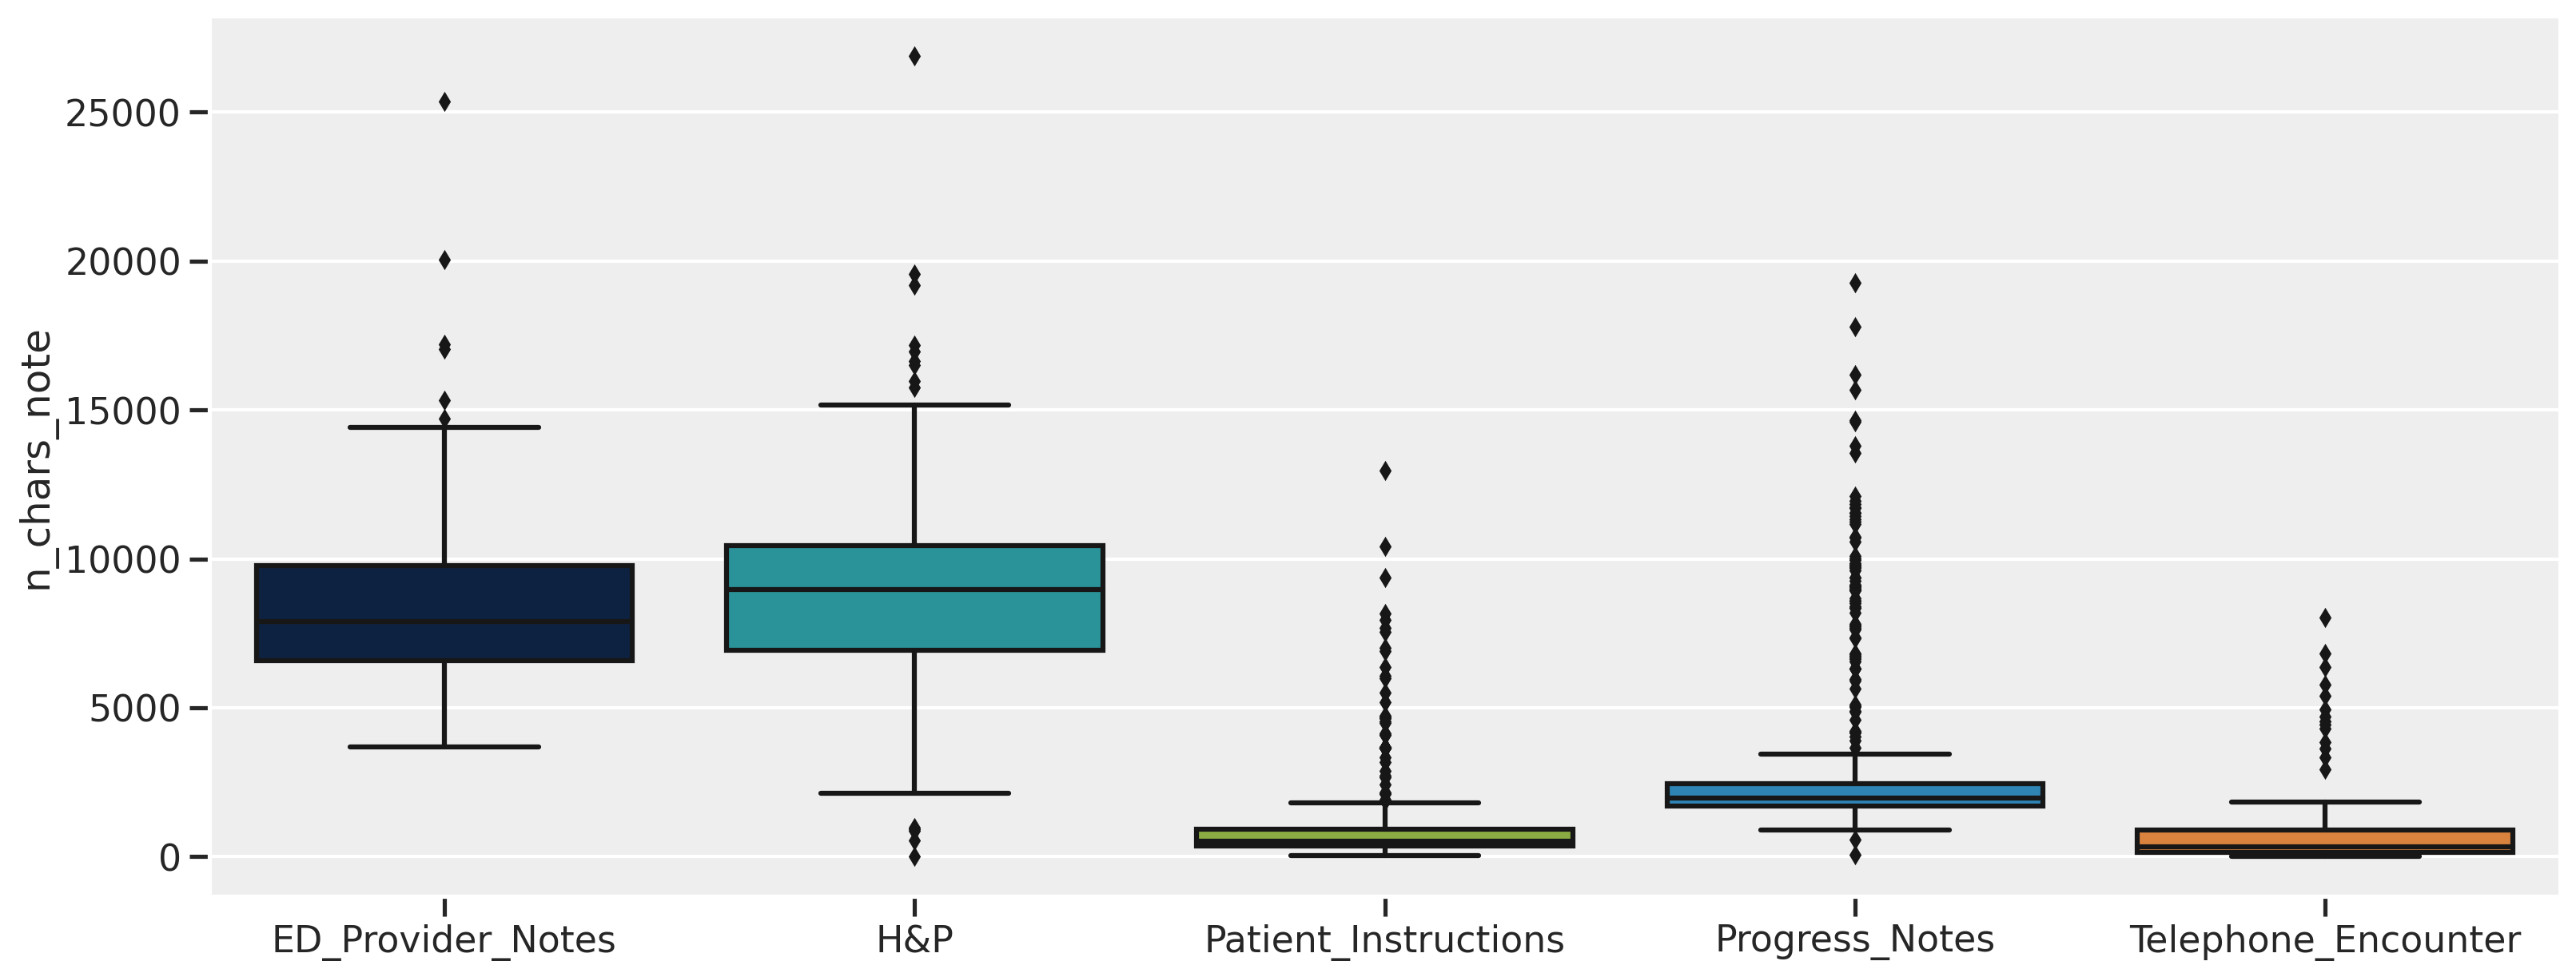

<IPython.core.display.Javascript object>

In [66]:
f, ax1 = plt.subplots(figsize=(16, 6))
sns.boxplot(data=df_srfs_counts, x="note_type", y="n_chars_note", palette=sf_palette)
ax1.set_xlabel("")

Text(0.5, 0, '')

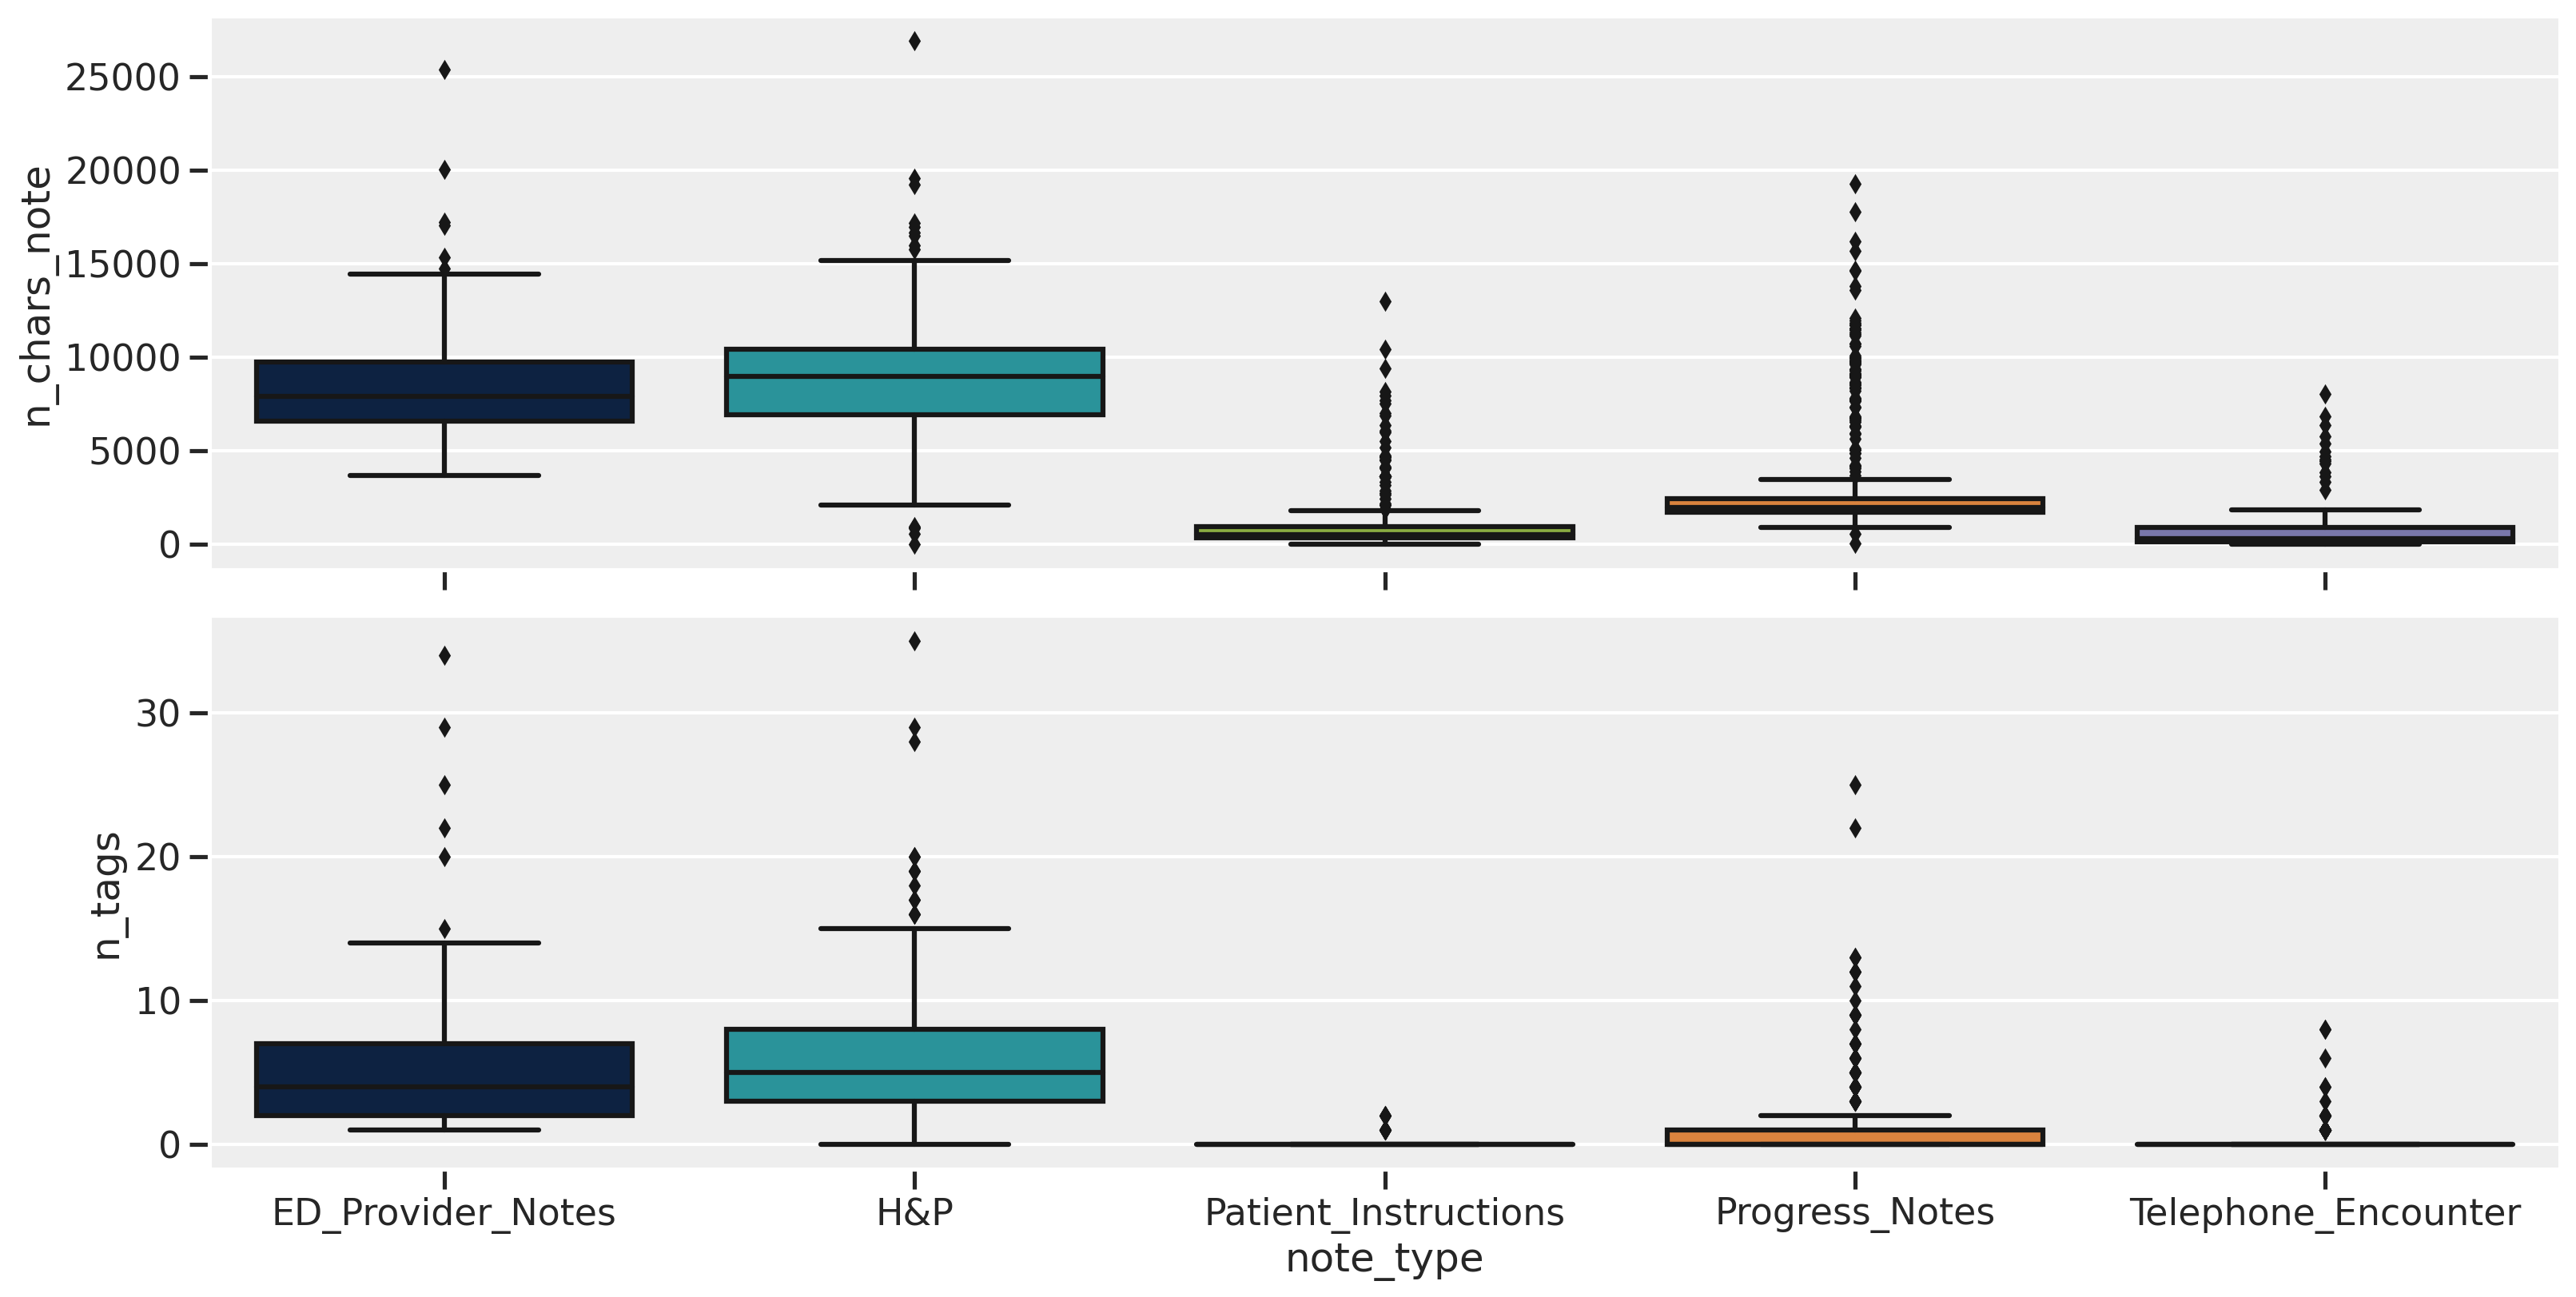

<IPython.core.display.Javascript object>

In [504]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
sns.boxplot(
    data=df_srfs_counts, x="note_type", y="n_chars_note", palette=sf_palette, ax=ax1
)
sns.boxplot(data=df_srfs_counts, x="note_type", y="n_tags", palette=sf_palette, ax=ax2)
ax1.set_xlabel("")

In [482]:
output_dir2

'/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output/'

<IPython.core.display.Javascript object>

In [ ]:
'/Users/blacar/Documents/ds_projects/sdoh_text/cocoa/edemarchis_GRP/skippy-2020-02-12-per-type_output'

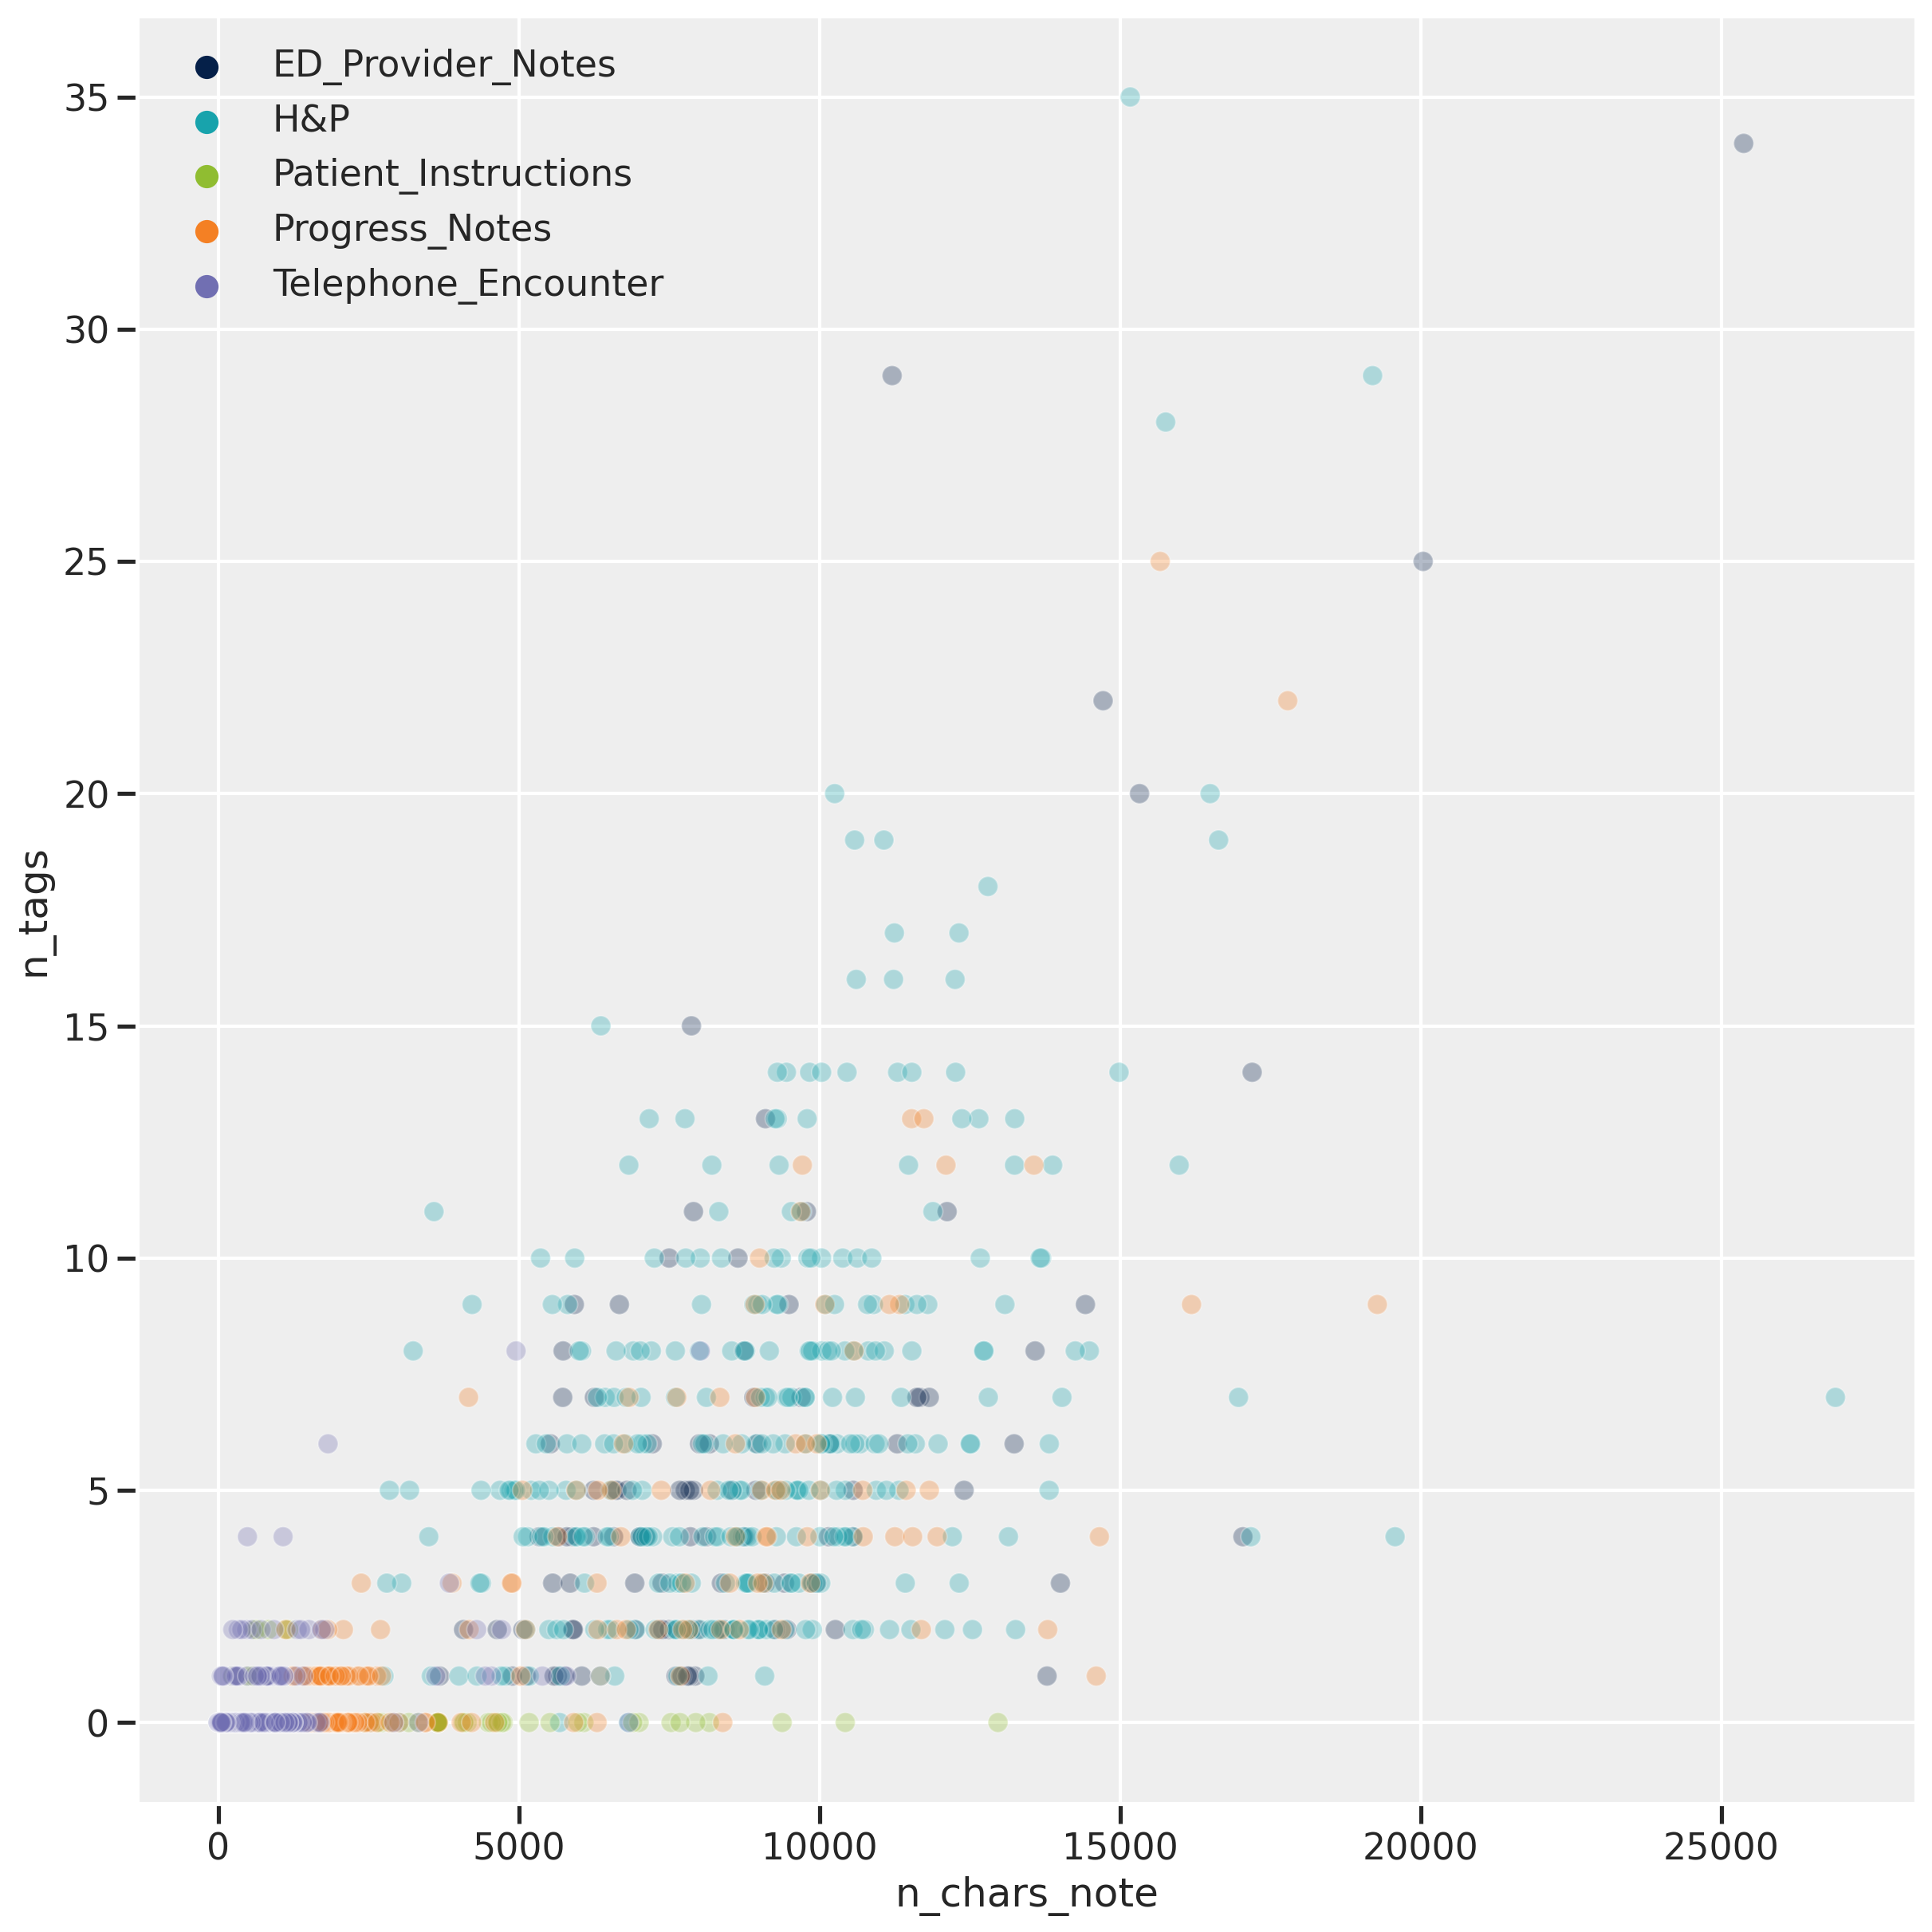

<IPython.core.display.Javascript object>

In [497]:
f, ax1 = plt.subplots(figsize=(12, 12))

sns.scatterplot(
    data=df_srfs_counts,
    x="n_chars_note",
    y="n_tags",
    hue="note_type",
    palette=sf_palette[0:5],
    alpha=0.3,
)
ax1.legend(title=None)

# sns.regplot(data=df_srfs_counts, x="n_chars_note", y="n_tags", ci=False, ax=ax1)

# plt.savefig(output_dir2 + "/scatter_notelength_tags.png", bbox_inches="tight")

Check that the `Patient_Instructions` note type really does have few tags.

In [75]:
df_srfs_counts[df_srfs_counts["note_type"] == "Patient_Instructions"].sort_values(
    by="n_chars_note", ascending=False
)

note_type                file  n_tags n_chars_note
712  Patient_Instructions  750277445_Sara.xml     0.0        12969
590  Patient_Instructions  904785807_Sara.xml     0.0        10428
757  Patient_Instructions  682526920_Sara.xml     0.0         9379
456  Patient_Instructions  657541460_Sara.xml     0.0         8169
591  Patient_Instructions  706084881_Sara.xml     0.0         7943
..                    ...                 ...     ...          ...
509  Patient_Instructions  721313991_Sara.xml     0.0           44
750  Patient_Instructions  683471317_Sara.xml     0.0           33
441  Patient_Instructions  674130338_Sara.xml     0.0           32
656  Patient_Instructions  637068419_Sara.xml     0.0           27
563  Patient_Instructions  633647935_Sara.xml     0.0           23

[386 rows x 4 columns]

<IPython.core.display.Javascript object>

### Prior prediction check for beta

Here, we would use a combination of alpha (already established above as `Normal(2,1)`) and different beta distribution values to generate log(lambda), then exponentiate to generate predictions.'

The `x` in this case would be the range of characters for a note. **Right now, I'm assuming there's a linear relationship between number of characters and number of tags. Just do a linear model?**



In [392]:
print(
    "range of characters: ",
    df_srfs_counts["n_chars_note"].min(),
    df_srfs_counts["n_chars_note"].max(),
)

range of characters:  1 26897


<IPython.core.display.Javascript object>

#### Multiplying by linear x

In [511]:
# Plot 50 lines over the range of (0, 30000) characters
N = 50
xrange = np.linspace(0, 30_000, N)
# alpha values
alphas = pm.Normal.dist(2, 1).random(size=N)
# beta values
betas = pm.Normal.dist(0, 0.5).random(size=N)


<IPython.core.display.Javascript object>

In [512]:
xrange

array([    0.        ,   612.24489796,  1224.48979592,  1836.73469388,
        2448.97959184,  3061.2244898 ,  3673.46938776,  4285.71428571,
        4897.95918367,  5510.20408163,  6122.44897959,  6734.69387755,
        7346.93877551,  7959.18367347,  8571.42857143,  9183.67346939,
        9795.91836735, 10408.16326531, 11020.40816327, 11632.65306122,
       12244.89795918, 12857.14285714, 13469.3877551 , 14081.63265306,
       14693.87755102, 15306.12244898, 15918.36734694, 16530.6122449 ,
       17142.85714286, 17755.10204082, 18367.34693878, 18979.59183673,
       19591.83673469, 20204.08163265, 20816.32653061, 21428.57142857,
       22040.81632653, 22653.06122449, 23265.30612245, 23877.55102041,
       24489.79591837, 25102.04081633, 25714.28571429, 26326.53061224,
       26938.7755102 , 27551.02040816, 28163.26530612, 28775.51020408,
       29387.75510204, 30000.        ])

<IPython.core.display.Javascript object>

In [513]:
alphas

array([1.18149227, 0.54289598, 1.41953815, 2.62701458, 1.24985326,
       2.19180426, 2.80534795, 1.50027174, 3.27147633, 1.19393403,
       0.73965358, 1.41252329, 1.63007388, 3.01346109, 1.90544007,
       1.64491049, 2.07153701, 2.16234519, 3.05546399, 0.36255375,
       2.81226466, 0.95014061, 0.82434863, 1.82783315, 1.36870993,
       1.47167173, 1.35845169, 0.7295961 , 2.77019866, 3.99137434,
       2.91370932, 2.75794744, 1.83014479, 0.72273249, 1.06940813,
       1.74241561, 1.50306391, 2.05336745, 2.06906066, 2.5789217 ,
       2.08382589, 2.0951775 , 3.37661484, 3.36251113, 1.54715401,
       1.99038788, 1.15146046, 2.78690983, 2.9243871 , 1.26352421])

<IPython.core.display.Javascript object>

In [514]:
betas

array([ 0.26774399, -0.14015991, -0.14122937,  0.63254323, -0.27665761,
       -0.45293691, -0.1851224 , -1.03153529, -0.48884265,  1.0814309 ,
       -0.24030518, -0.29753274, -0.65528292, -0.02227171, -0.49674598,
        0.72513903,  0.73304812,  0.32842299,  0.21139764,  0.2249487 ,
       -0.45244174, -0.1908718 , -0.5668872 ,  0.20705055, -0.37552411,
       -0.6520167 ,  0.50231849,  1.13732865, -0.87911275, -0.00854803,
        0.35465059,  0.29178677,  0.17914391,  0.34843906, -0.21109463,
        0.31896989, -0.10487216, -0.1726181 ,  0.73291755,  0.51498267,
       -0.15492162,  0.58288723,  0.06474603,  0.54356086,  1.08145455,
        1.0084925 ,  0.353657  ,  0.66748226, -0.31064191,  0.9091198 ])

<IPython.core.display.Javascript object>

<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3a366>:3: RuntimeWarning: overflow encountered in exp
  ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)
<ipython-input-520-342f03b3

(0.0, 500.0)

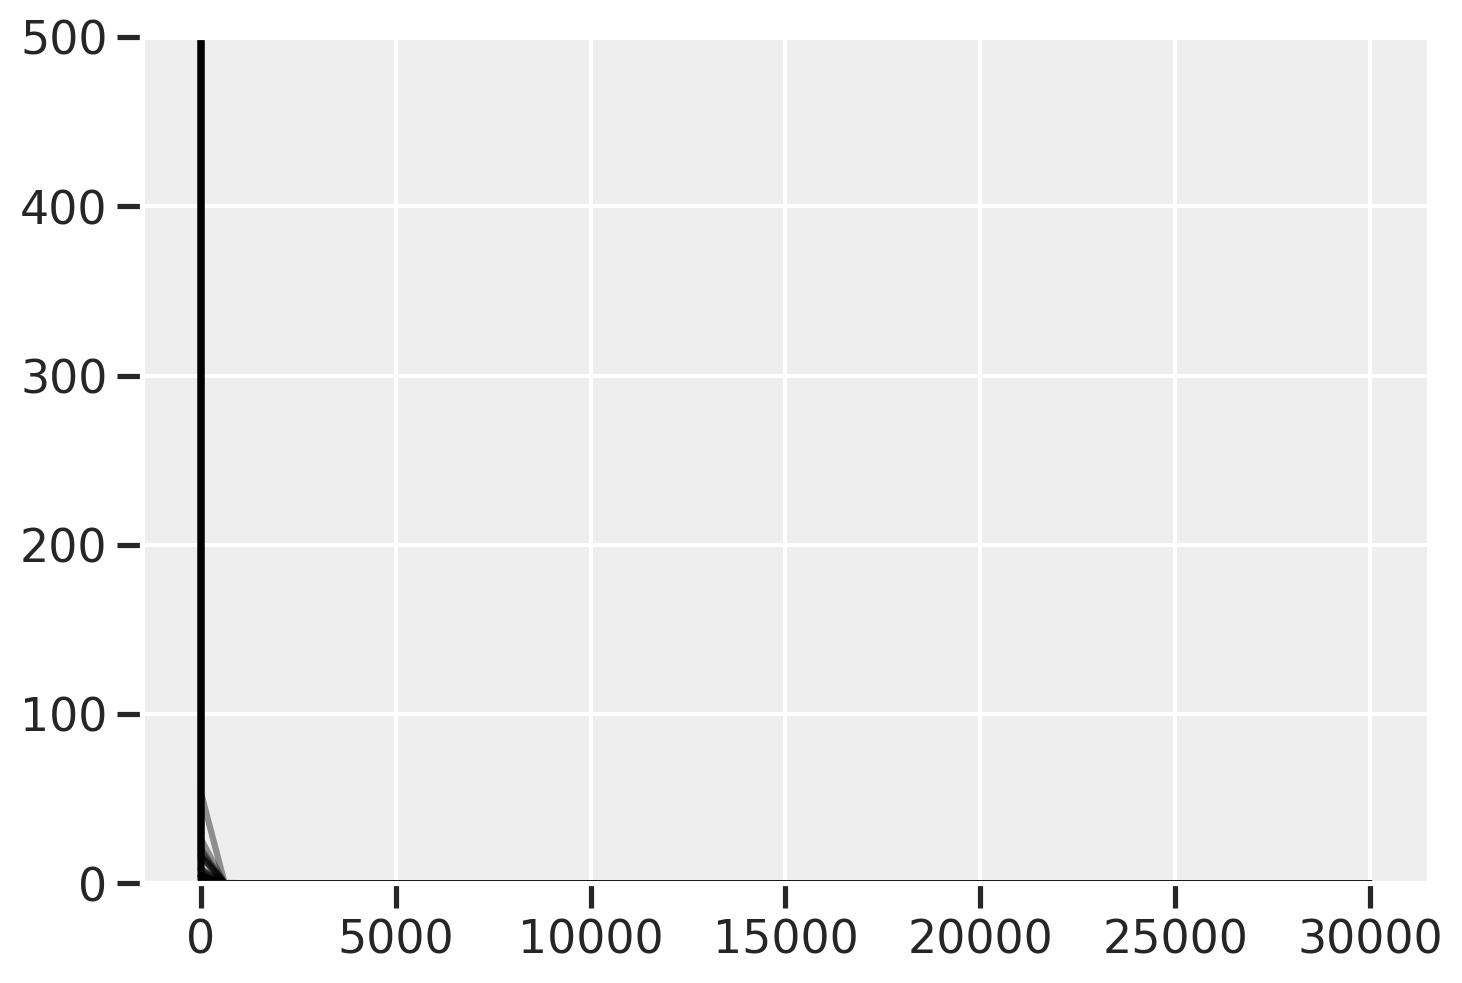

<IPython.core.display.Javascript object>

In [520]:
f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(xrange, np.exp(a + b * xrange), "k", alpha=0.4)

# Limiting
ax1.set_ylim(0, 500)

I get an overflow warning. This is a rationale for using logs.

#### Multiplying by log x

In [451]:
# Plot 50 lines over the range of (0, 30000) characters
N = 50
xrange_log = np.log(np.linspace(1, 30_000, N))


<IPython.core.display.Javascript object>

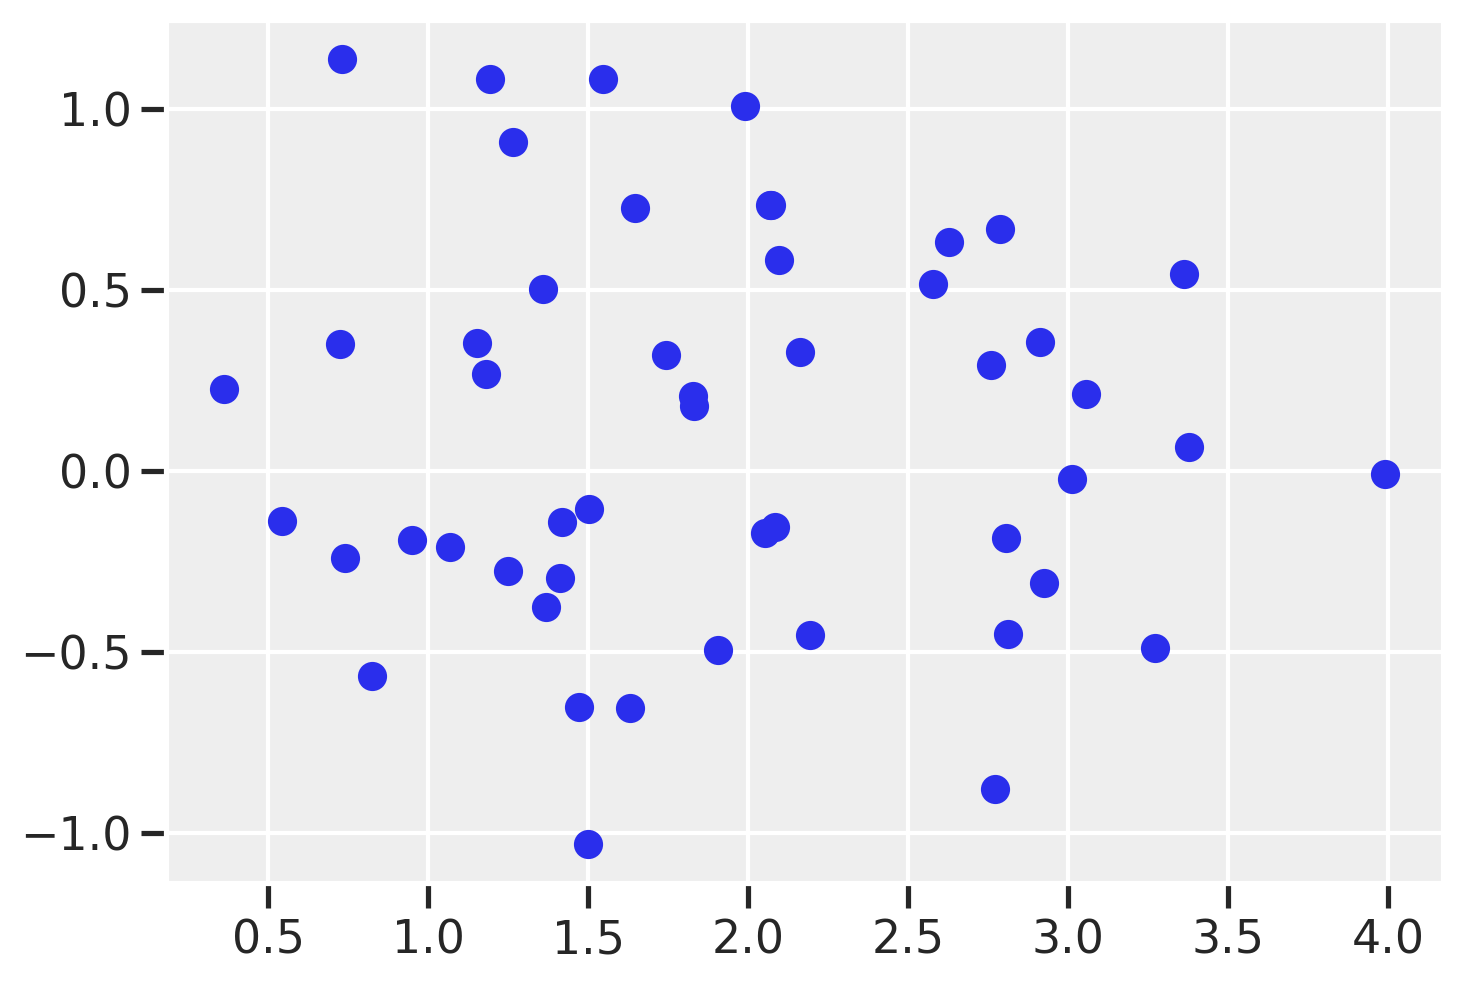

<IPython.core.display.Javascript object>

In [524]:
# Look at the sampling space of parameters
plt.scatter(alphas, betas)

(0.0, 500.0)

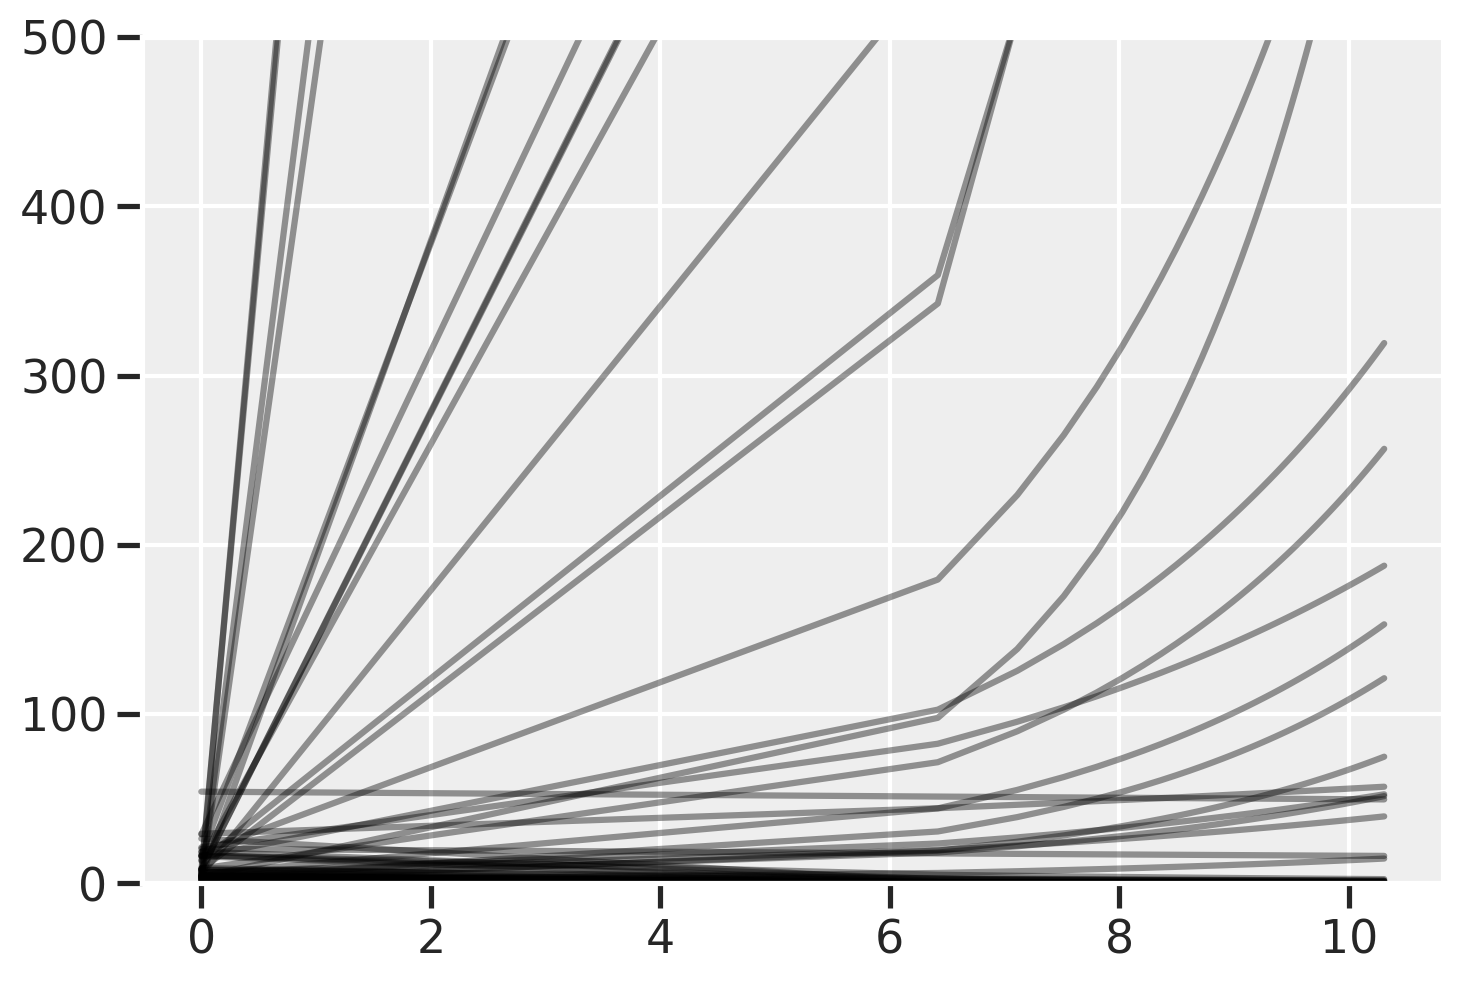

<IPython.core.display.Javascript object>

In [523]:
f, ax1 = plt.subplots()
for a, b in zip(alphas, betas):
    ax1.plot(xrange_log, np.exp(a + b * xrange_log), "k", alpha=0.4)

# Limiting
ax1.set_ylim(0, 500)

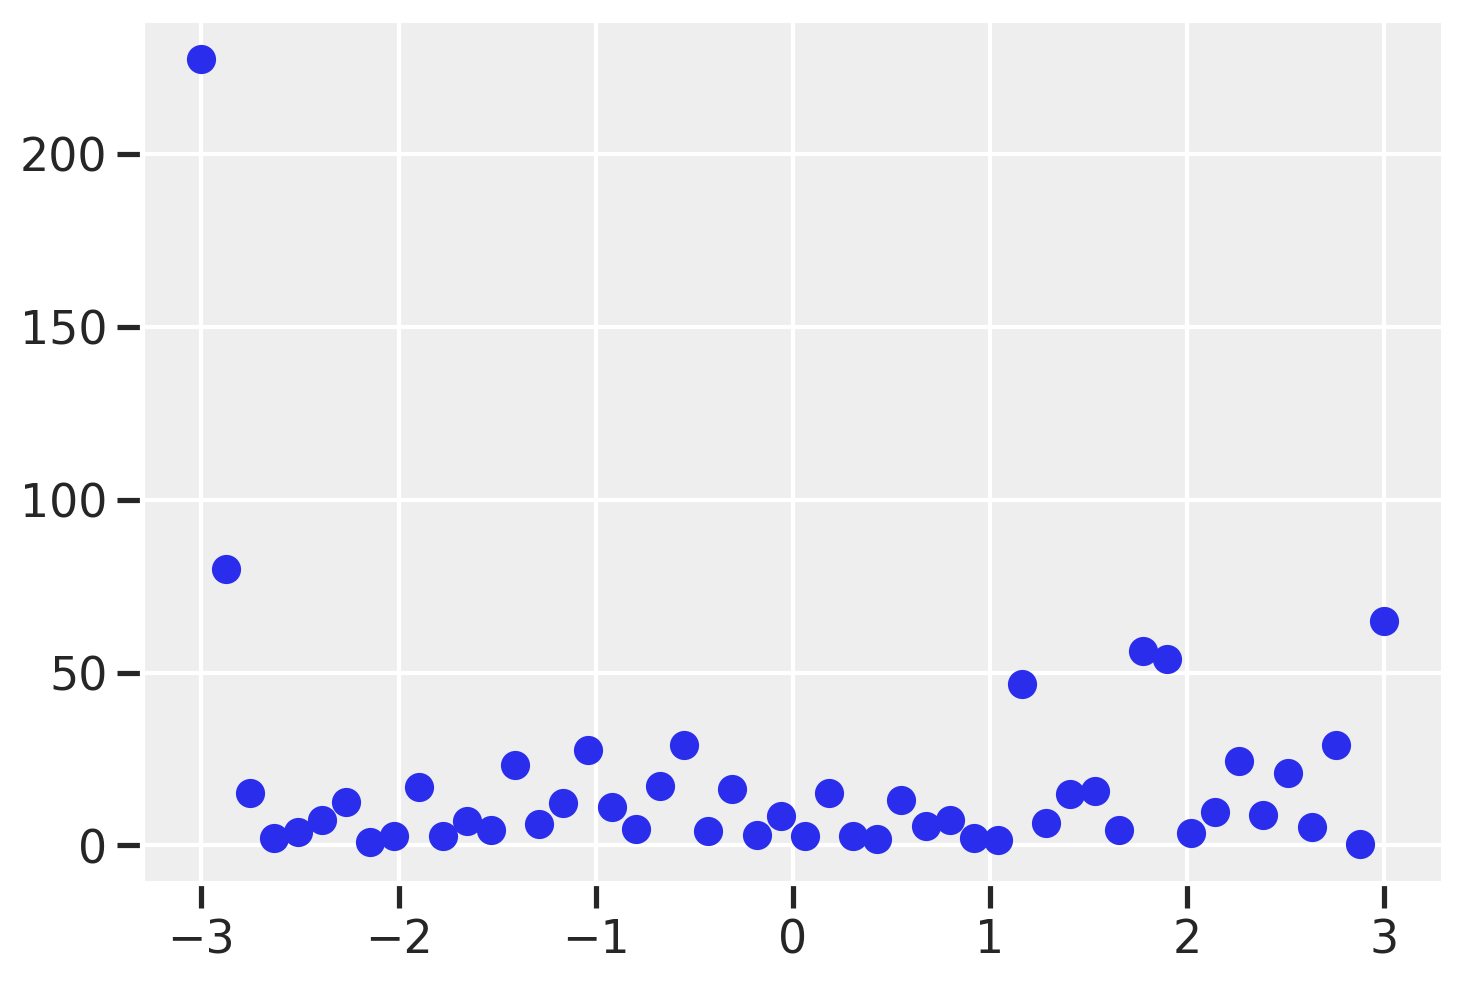

<IPython.core.display.Javascript object>

In [480]:
a = pm.Normal.dist(2, 1).random(size=N)
b = pm.Normal.dist(0, 0.5).random(size=N)
std_vals = np.linspace(-3, 3, 50)

plt.scatter(std_vals, np.exp(a + b * std_vals))

### Model specification


$$y_i \text{ ~ } \text{Poisson}(\lambda_i) $$ 

$$\text{log}(\lambda_i) = \alpha_{\text{type}[i]} + \beta_{\text{type}[i]} x_i$$ 

$$\alpha_{j} \text{ ~ Normal}(1, 0.5) $$
$$\beta_{j} \text{ ~ Normal}(1, 0.5) $$

In [155]:
# standardize number of characters

df_srfs_counts["n_chars_note_std"] = standardize(df_srfs_counts["n_chars_note"])

# Doing this due to an error with pymc
df_srfs_counts["n_chars_note_std"] = df_srfs_counts["n_chars_note_std"].astype("float")

<IPython.core.display.Javascript object>

In [157]:
df_srfs_counts["n_chars_note_std"]

0       1.194551
1       1.069144
2       0.720790
3       2.799138
4       1.008602
          ...   
1572   -0.081383
1573   -0.873947
1574   -0.867461
1575   -0.653163
1576   -0.870103
Name: n_chars_note_std, Length: 1577, dtype: float64

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'number of characters')

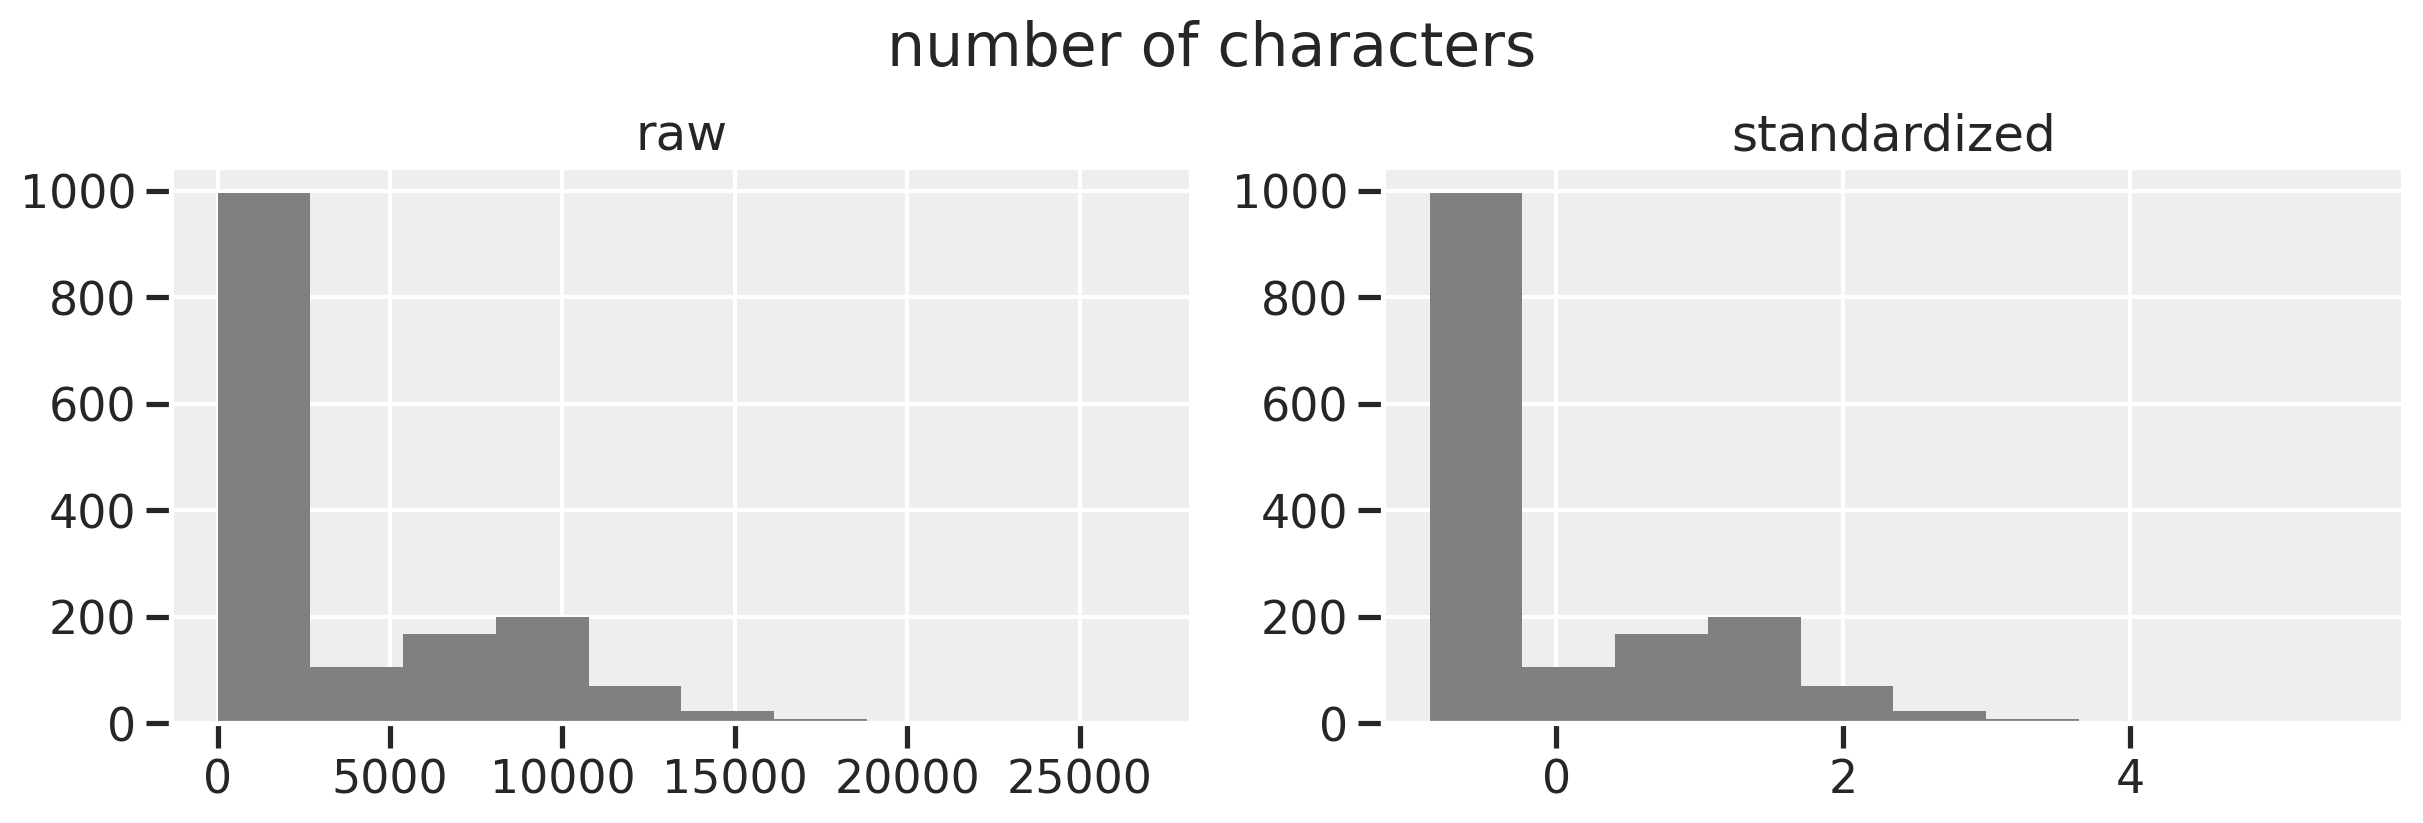

<IPython.core.display.Javascript object>

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df_srfs_counts["n_chars_note"].hist(ax=ax1, color="gray")
ax1.set_title("raw")

df_srfs_counts["n_chars_note_std"].hist(ax=ax2, color="gray")
ax2.set_title("standardized")

f.suptitle("number of characters")

Let's make simulations for beta values.

In [137]:
#x_seq = np.linspace(np.log(100), np.log(25_000), 100)   # representative of number of characters
x_seq = np.linspace(100, 25_000, 100)
alphas = np.random.normal(1, 0.5, 100)                   # established this above
betas = np.random.lognormal(0.0, 1, 100)                  # trying these values


<IPython.core.display.Javascript object>

In [138]:
x_seq

array([  100.        ,   351.51515152,   603.03030303,   854.54545455,
        1106.06060606,  1357.57575758,  1609.09090909,  1860.60606061,
        2112.12121212,  2363.63636364,  2615.15151515,  2866.66666667,
        3118.18181818,  3369.6969697 ,  3621.21212121,  3872.72727273,
        4124.24242424,  4375.75757576,  4627.27272727,  4878.78787879,
        5130.3030303 ,  5381.81818182,  5633.33333333,  5884.84848485,
        6136.36363636,  6387.87878788,  6639.39393939,  6890.90909091,
        7142.42424242,  7393.93939394,  7645.45454545,  7896.96969697,
        8148.48484848,  8400.        ,  8651.51515152,  8903.03030303,
        9154.54545455,  9406.06060606,  9657.57575758,  9909.09090909,
       10160.60606061, 10412.12121212, 10663.63636364, 10915.15151515,
       11166.66666667, 11418.18181818, 11669.6969697 , 11921.21212121,
       12172.72727273, 12424.24242424, 12675.75757576, 12927.27272727,
       13178.78787879, 13430.3030303 , 13681.81818182, 13933.33333333,
      

<IPython.core.display.Javascript object>

In [141]:
f, ax = plt.subplots()
for a, b in zip(alphas, betas):
    # ax.plot(np.exp(x_seq), a + b * x_seq, "k", alpha=0.4)
    ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
    ax.set_xlabel("number of characters")

<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarning: overflow encountered in exp
  ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
<ipython-input-141-9d80bfb3568c>:4: RuntimeWarni

ValueError: arange: cannot compute length

<Figure size 720x480 with 1 Axes>

<IPython.core.display.Javascript object>

In [112]:
def kline_prior_plot(
    N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None
):
    """
    Utility function to plot prior predictive checks for Poisson model.
    N: number of prior predictive trends.
    Modified from kline_prior_plot, taken from pymc3 repo)

    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tags")

    itcpts = np.random.normal(3.0, 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0.0, 10.0, N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0.0, 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError(
            "Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'."
        )

    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    # ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
        ax.set_xlabel("number of characters")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), a + b * x_seq, "k", alpha=0.4)
        ax.set_xlabel("number of characters")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, a + b * x_seq, "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("number of characters (std)")

    return ax

<IPython.core.display.Javascript object>

<ipython-input-113-61cabad2a4b3>:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


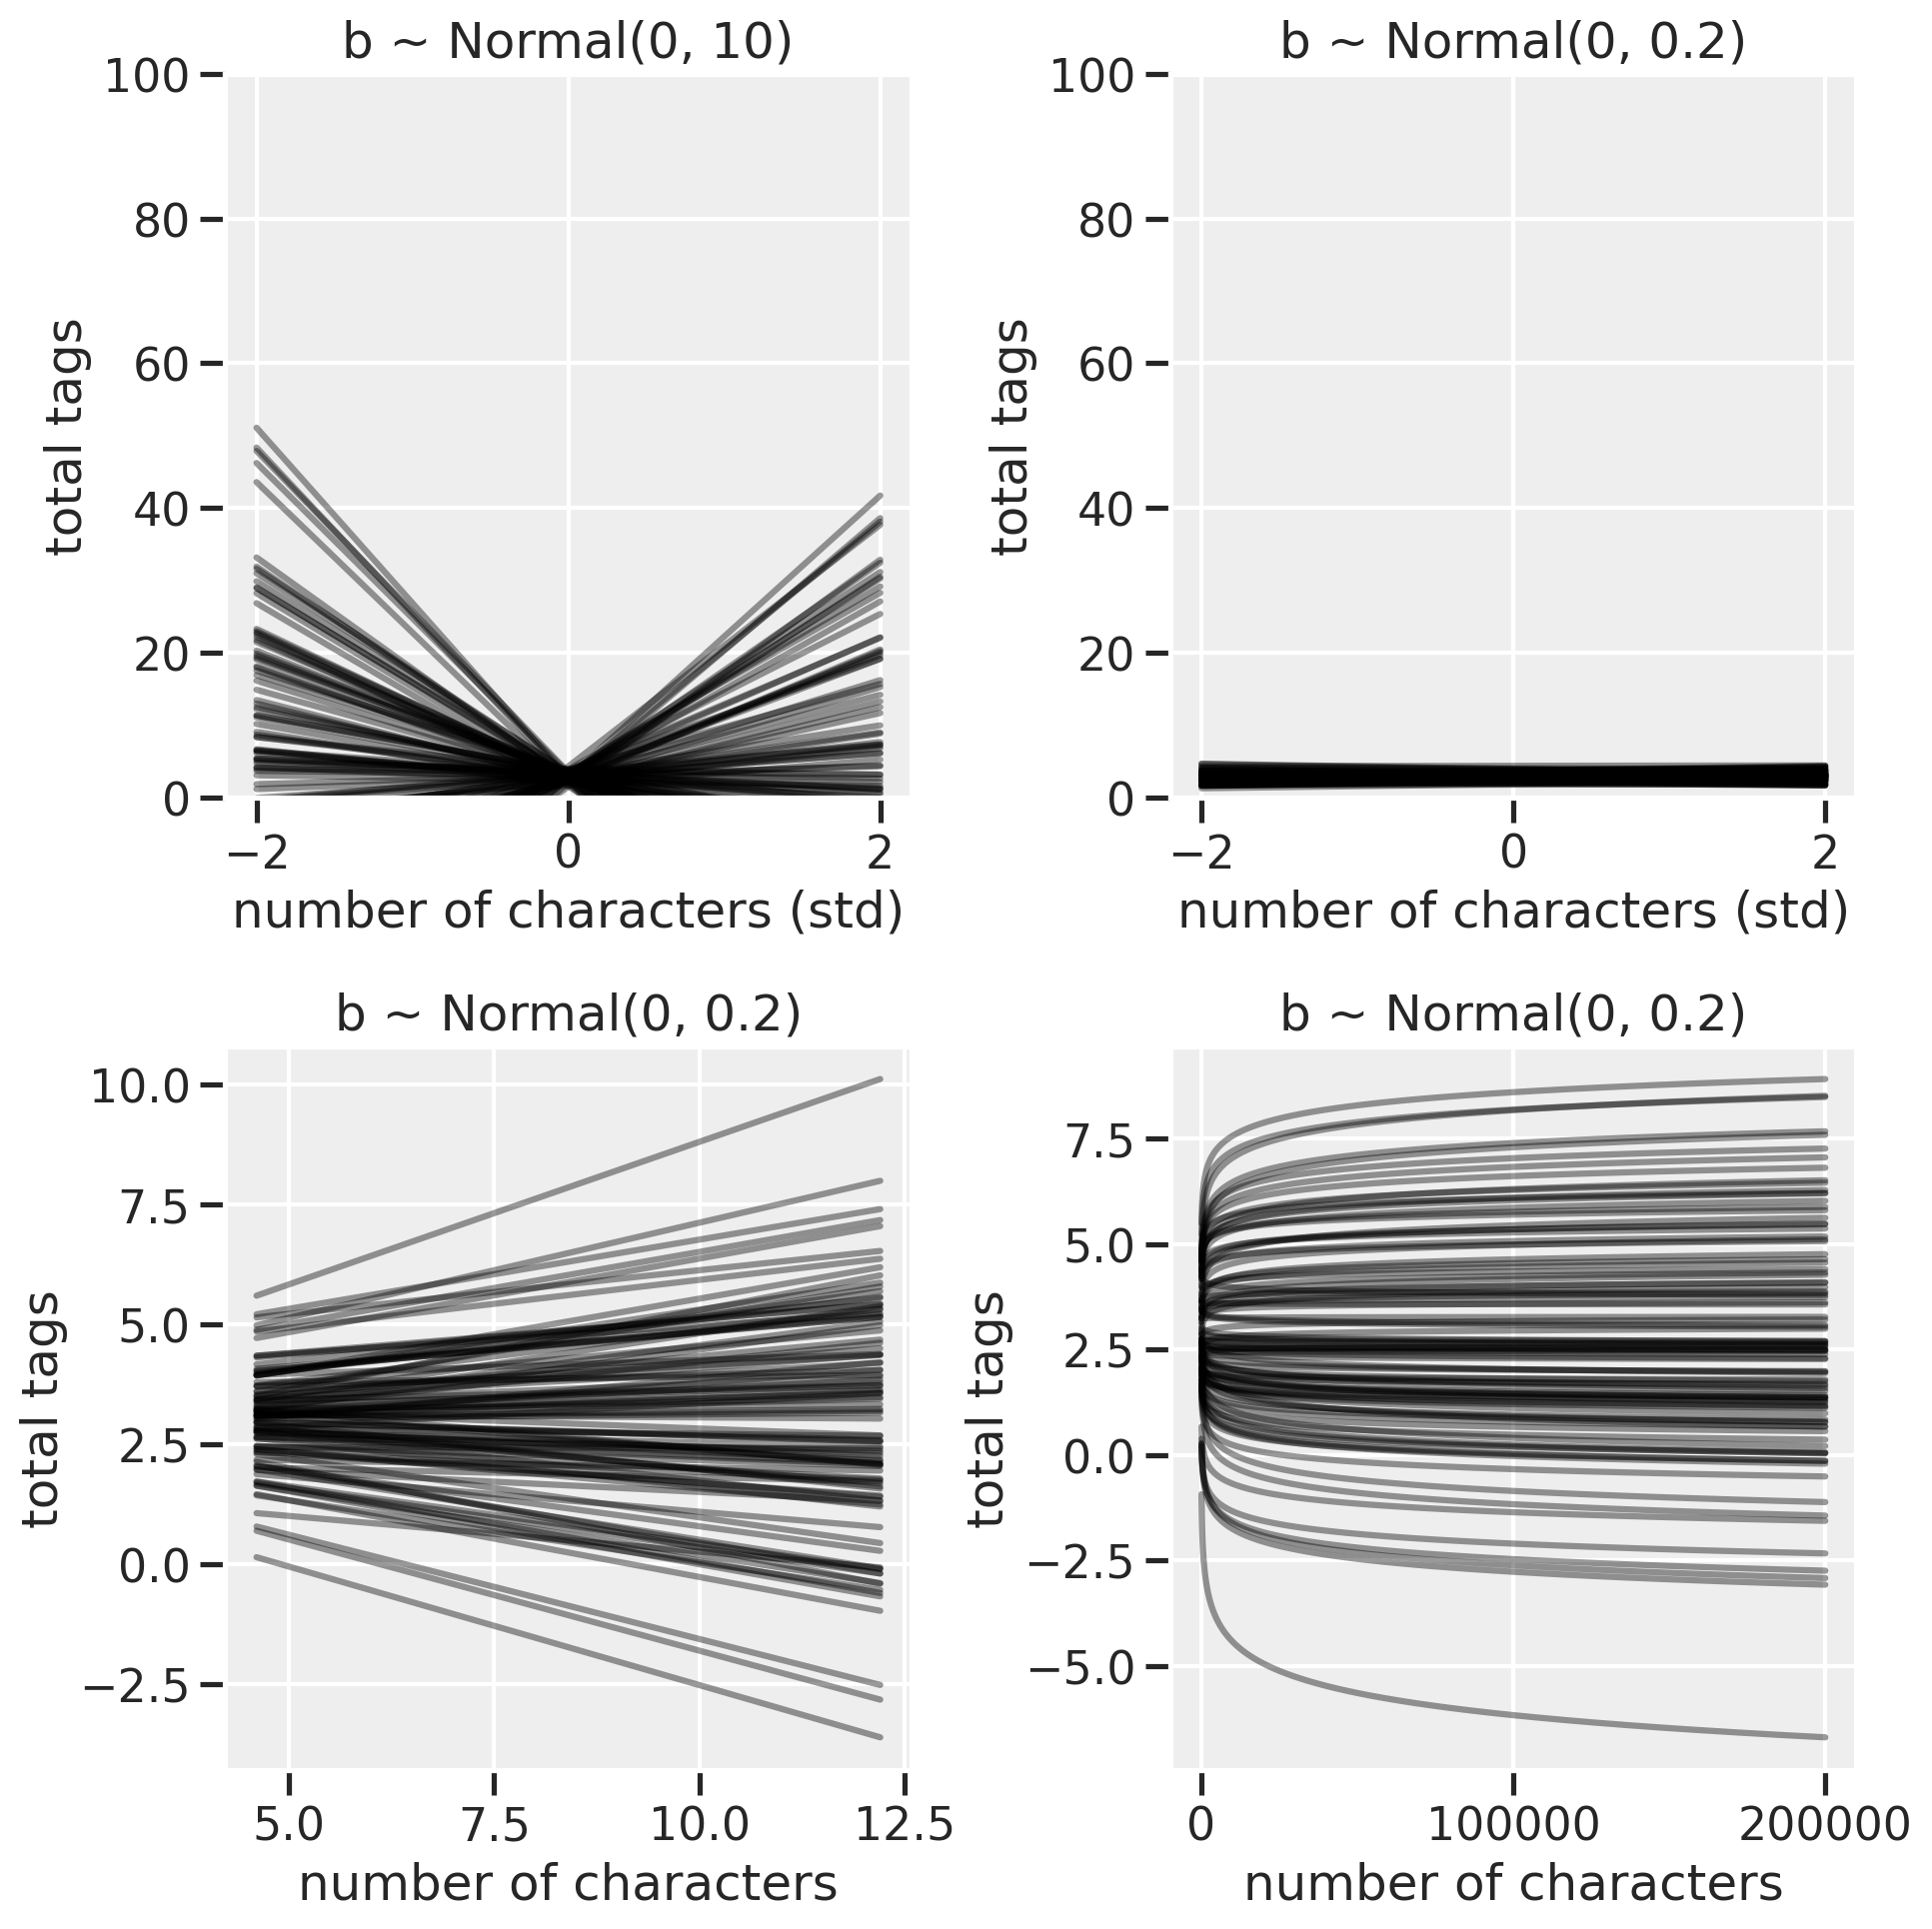

<IPython.core.display.Javascript object>

In [113]:
# Taken from repo
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout()

In [ ]:
df_srfs_counts["n_chars_note_std"]

In [158]:
# Intercept only model
with pm.Model() as m_notes2:
    # Prior chosen based on above
    a = pm.Normal("a", 1, 0.5, shape=5)
    b = pm.Normal("b", 0, 0.2, shape=5)

    # The link function, use `pm.math.exp` to get lambda
    lam = pm.Deterministic(
        "lam",
        pm.math.exp(
            a[df_srfs_counts["note_type_code"]]
            + b[df_srfs_counts["note_type_code"]] * df_srfs_counts["n_chars_note_std"]
        ),
    )

    # Likelihood,
    t = pm.Poisson("t", mu=lam, observed=df_srfs_counts["n_tags"])

    trace_m_notes2 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

In [167]:
az.summary(trace_m_notes2, var_names=["a", "b"])

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  1.051  0.068     0.940      1.156      0.001    0.001    3476.0  3467.0   
a[1]  1.334  0.042     1.267      1.400      0.001    0.000    3779.0  3770.0   
a[2] -2.366  0.188    -2.656     -2.061      0.003    0.002    3941.0  3871.0   
a[3] -0.324  0.065    -0.428     -0.222      0.001    0.001    3205.0  3050.0   
a[4] -0.514  0.128    -0.721     -0.315      0.002    0.001    3848.0  3760.0   
b[0]  0.483  0.032     0.433      0.536      0.001    0.000    3494.0  3494.0   
b[1]  0.380  0.024     0.342      0.418      0.000    0.000    3959.0  3957.0   
b[2]  0.261  0.172    -0.012      0.530      0.003    0.002    4342.0  3468.0   
b[3]  1.054  0.033     1.004      1.110      0.001    0.000    3404.0  3396.0   
b[4]  1.182  0.148     0.949      1.414      0.002    0.002    4030.0  4025.0   

      ess_bulk  ess_tail  r_hat  
a[0]    3483.0    2773.0    1.0  
a[1]    3776.0    2782.0    1.0  
a[2]    3987.0    3096.0    1.0  
a[3]    3224.0    2755.0    1.0  
a[4]    3842.0    2961.0    1.0  
b[0]    3485.0    2817.0    1.0  
b[1]    3992.0    3186.0    1.0  
b[2]    4355.0    2913.0    1.0  
b[3]    3404.0    3084.0    1.0  
b[4]    4025.0    3143.0    1.0

<IPython.core.display.Javascript object>

In [168]:
df_srfs_counts["note_type"].unique()

array(['ED_Provider_Notes', 'H&P', 'Patient_Instructions',
       'Progress_Notes', 'Telephone_Encounter'], dtype=object)

<IPython.core.display.Javascript object>

In [174]:
trace_m_notes2_df = trace_m_notes2.to_dataframe()
trace_m_notes2_df.head()

chain  draw  (posterior, a[0], 0)  (posterior, a[1], 1)  \
0      0     0              1.022753              1.315395   
1      0     1              0.979204              1.312649   
2      0     2              1.067068              1.333488   
3      0     3              1.079092              1.410042   
4      0     4              1.121303              1.361033   

   (posterior, a[2], 2)  (posterior, a[3], 3)  (posterior, a[4], 4)  \
0             -2.436624             -0.220155             -0.591403   
1             -2.385741             -0.439798             -0.707472   
2             -2.261214             -0.272039             -0.327410   
3             -2.324186             -0.381422             -0.628541   
4             -2.382466             -0.349341             -0.534580   

   (posterior, b[0], 0)  (posterior, b[1], 1)  (posterior, b[2], 2)  ...  \
0              0.466693              0.400015              0.223921  ...   
1              0.487325              0.378112              0.279387  ...   
2              0.495374              0.370369              0.173447  ...   
3              0.455671              0.353308              0.254700  ...   
4              0.462211              0.350920              0.273824  ...   

   (sample_stats, energy_error)  (sample_stats, step_size_bar)  \
0                     -0.661177                       0.552348   
1                     -0.093014                       0.552348   
2                     -0.396862                       0.552348   
3                      0.507695                       0.552348   
4                     -0.265048                       0.552348   

   (sample_stats, max_energy_error)  (sample_stats, perf_counter_diff)  \
0                          5.749071                           0.005743   
1                         -0.679483                           0.003592   
2                          0.941661                           0.001889   
3                          1.114600                           0.005198   
4                         -0.623378                           0.001268   

   (sample_stats, diverging)  (sample_stats, mean_tree_accept)  \
0                      False                          0.926753   
1                      False                          0.975291   
2                      False                          0.853880   
3                      False                          0.756600   
4                      False                          0.967403   

   (sample_stats, perf_counter_start)  (sample_stats, tree_size)  \
0                         6608.888037                       31.0   
1                         6608.893893                       15.0   
2                         6608.897687                        7.0   
3                         6608.899774                       31.0   
4                         6608.905141                        7.0   

   (sample_stats, lp)  (sample_stats, process_time_diff)  
0        -2081.860101                           0.005743  
1        -2081.864702                           0.003579  
2        -2081.516183                           0.001888  
3        -2083.378852                           0.005198  
4        -2080.879002                           0.001269  

[5 rows x 3179 columns]

<IPython.core.display.Javascript object>

### Predictions

In [160]:
with m_notes2:
    post_pc2 = pm.sample_posterior_predictive(trace=trace_m_notes2)

<IPython.core.display.Javascript object>

In [161]:
post_pc2["t"].shape

(4000, 1577)

<IPython.core.display.Javascript object>

In [162]:
post_pc2["t"][0, :]

array([ 6,  8, 10, ...,  2,  0,  1])

<IPython.core.display.Javascript object>

In [81]:
df_srfs_counts.head()

note_type                file  n_tags n_chars_note
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'observed vs. predicted (model 2, first sample)')

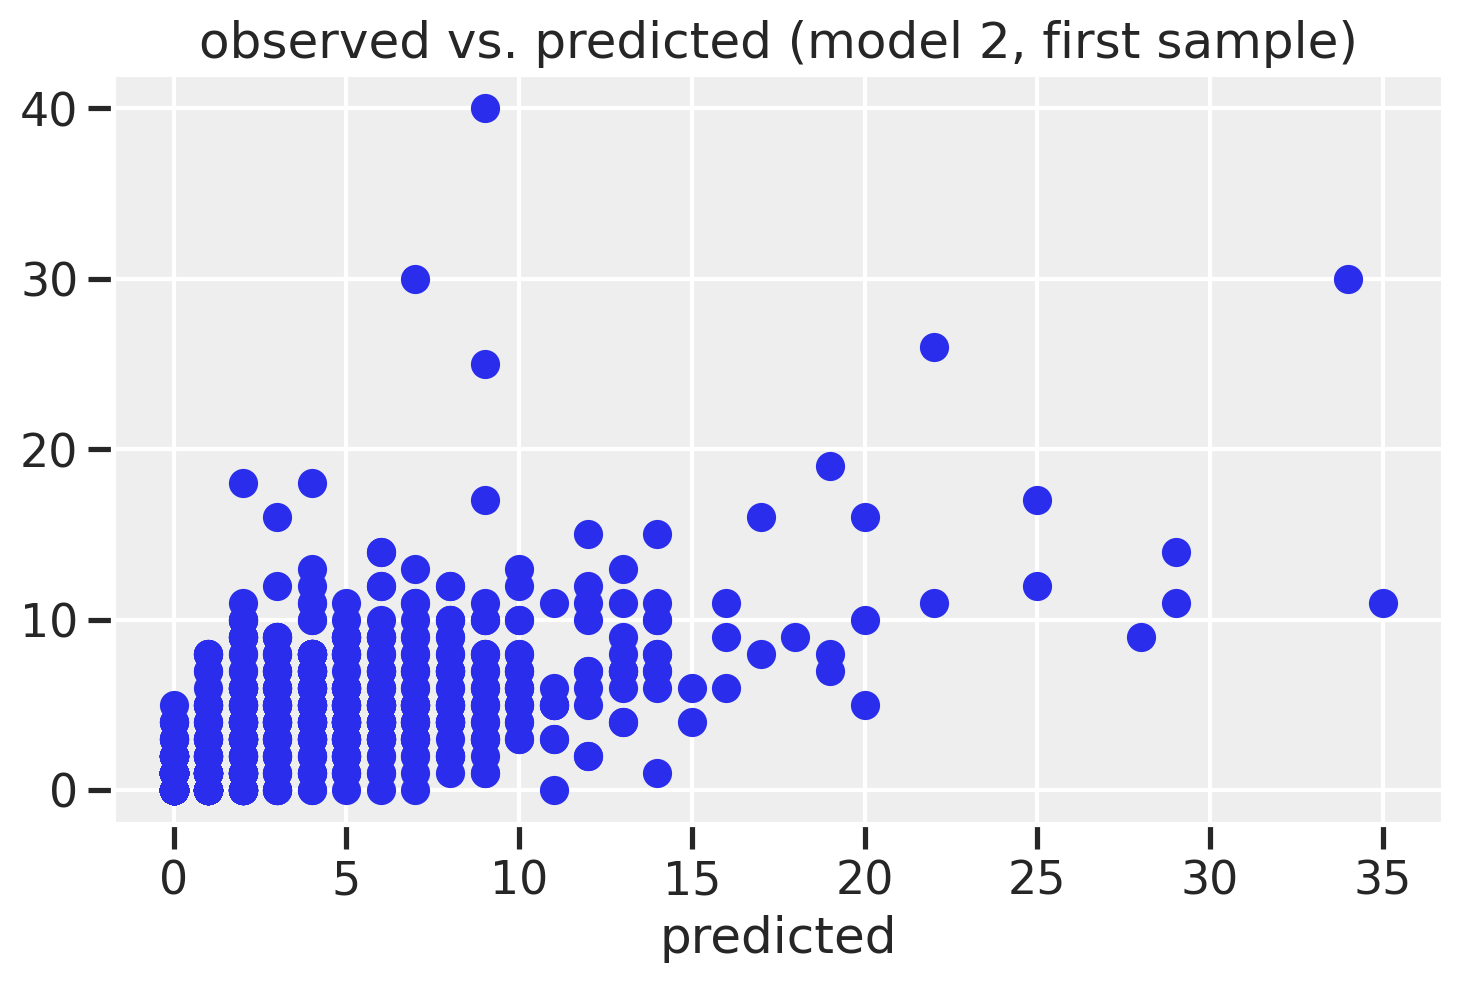

<IPython.core.display.Javascript object>

In [173]:
f, ax1 = plt.subplots()
ax1.scatter(df_srfs_counts["n_tags"], post_pc2["t"][0, :])
ax1.set_xlabel("observed")
ax1.set_xlabel("predicted")
ax1.set_title("observed vs. predicted (model 2, first sample)")

In [217]:
def get_link_pred(x, cid):
    """
    Mimic the link function.
    """
    key_tuple = "posterior", f"a[{cid}]", cid
    y = np.exp(trace_m_notes2_df[key_tuple] + trace_m_notes2_df[key_tuple] * x)

    return y

<IPython.core.display.Javascript object>

In [ ]:
("posterior", "a[0]", 0)

In [189]:
trace_m_notes2_df

chain  draw  (posterior, a[0], 0)  (posterior, a[1], 1)  \
0         0     0              1.022753              1.315395   
1         0     1              0.979204              1.312649   
2         0     2              1.067068              1.333488   
3         0     3              1.079092              1.410042   
4         0     4              1.121303              1.361033   
...     ...   ...                   ...                   ...   
3995      3   995              1.013467              1.326656   
3996      3   996              0.972153              1.388465   
3997      3   997              1.073487              1.345692   
3998      3   998              1.079269              1.368526   
3999      3   999              1.012642              1.433336   

      (posterior, a[2], 2)  (posterior, a[3], 3)  (posterior, a[4], 4)  \
0                -2.436624             -0.220155             -0.591403   
1                -2.385741             -0.439798             -0.707472   
2                -2.261214             -0.272039             -0.327410   
3                -2.324186             -0.381422             -0.628541   
4                -2.382466             -0.349341             -0.534580   
...                    ...                   ...                   ...   
3995             -2.271712             -0.380149             -0.588011   
3996             -2.432006             -0.325691             -0.847225   
3997             -2.547735             -0.358789             -0.640124   
3998             -2.458752             -0.207690             -0.575968   
3999             -2.314307             -0.271731             -0.516294   

      (posterior, b[0], 0)  (posterior, b[1], 1)  (posterior, b[2], 2)  ...  \
0                 0.466693              0.400015              0.223921  ...   
1                 0.487325              0.378112              0.279387  ...   
2                 0.495374              0.370369              0.173447  ...   
3                 0.455671              0.353308              0.254700  ...   
4                 0.462211              0.350920              0.273824  ...   
...                    ...                   ...                   ...  ...   
3995              0.483422              0.402176              0.366014  ...   
3996              0.491612              0.351715              0.162718  ...   
3997              0.506016              0.361654             -0.135108  ...   
3998              0.492566              0.356138              0.346755  ...   
3999              0.513386              0.337085              0.181068  ...   

      (sample_stats, energy_error)  (sample_stats, step_size_bar)  \
0                        -0.661177                       0.552348   
1                        -0.093014                       0.552348   
2                        -0.396862                       0.552348   
3                         0.507695                       0.552348   
4                        -0.265048                       0.552348   
...                            ...                            ...   
3995                      0.493736                       0.564431   
3996                     -0.129442                       0.564431   
3997                     -0.009342                       0.564431   
3998                     -0.787717                       0.564431   
3999                      0.139435                       0.564431   

      (sample_stats, max_energy_error)  (sample_stats, perf_counter_diff)  \
0                             5.749071                           0.005743   
1                            -0.679483                           0.003592   
2                             0.941661                           0.001889   
3                             1.114600                           0.005198   
4                            -0.623378                           0.001268   
...                                ...                                ...   
3995               

<IPython.core.display.Javascript object>

In [192]:
trace_m_notes2_df[("posterior", "a[0]", 0)]

0       1.022753
1       0.979204
2       1.067068
3       1.079092
4       1.121303
          ...   
3995    1.013467
3996    0.972153
3997    1.073487
3998    1.079269
3999    1.012642
Name: (posterior, a[0], 0), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [216]:
jack = 0
# jack_string = "posterior", "a[" + str(jack) + "]"
jack_string = "posterior", f"a[{jack}]", jack
print(jack_string)
trace_m_notes2_df[jack_string]

('posterior', 'a[0]', 0)


0       1.022753
1       0.979204
2       1.067068
3       1.079092
4       1.121303
          ...   
3995    1.013467
3996    0.972153
3997    1.073487
3998    1.079269
3999    1.012642
Name: (posterior, a[0], 0), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [214]:
type(jack_string)

tuple

<IPython.core.display.Javascript object>

In [ ]:
get_link_pred

In [219]:
df_srfs_counts["note_type"].unique()

array(['ED_Provider_Notes', 'H&P', 'Patient_Instructions',
       'Progress_Notes', 'Telephone_Encounter'], dtype=object)

<IPython.core.display.Javascript object>

In [223]:
xseq = np.linspace(-5, 3, 100)

t_pred0 = np.zeros(
    (len(xseq), len(trace_m_notes2_df))
)  # predictions for ED_Provider_Notes
t_pred2 = np.zeros(
    (len(xseq), len(trace_m_notes2_df))
)  # predictions for Patient_Instructions

for i, x in enumerate(xseq):
    t_pred0[i] = get_link_pred(x, 0)
    t_pred2[i] = get_link_pred(x, 2)

df_t_pred0 = pd.DataFrame(t_pred0, index=xseq)
df_t_pred2 = pd.DataFrame(t_pred2, index=xseq)

<IPython.core.display.Javascript object>

In [224]:
df_t_pred0["avg_tags"] = df_t_pred0.mean(axis=1)
df_t_pred2["avg_tags"] = df_t_pred2.mean(axis=1)

<IPython.core.display.Javascript object>

In [227]:
# store pareto-k values for plot (taken from repo)
k = az.loo(trace_m_notes2, pointwise=True).pareto_k.values
df_srfs_counts["pareto_k"] = k

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<IPython.core.display.Javascript object>

In [228]:
df_srfs_counts.head()

note_type                file  n_tags n_chars_note  \
0  ED_Provider_Notes  646702875_Matt.xml    10.0         8644   
1  ED_Provider_Notes  742238643_Matt.xml     4.0         8122   
2  ED_Provider_Notes  658813952_Matt.xml     9.0         6672   
3  ED_Provider_Notes  650368122_Matt.xml    20.0        15323   
4  ED_Provider_Notes  705769932_Matt.xml    15.0         7870   

   n_chars_note_std  note_type_code  pareto_k  
0          1.194551               0  0.035130  
1          1.069144               0 -0.102141  
2          0.720790               0 -0.081465  
3          2.799138               0  0.048422  
4          1.008602               0  0.036835

<IPython.core.display.Javascript object>

In [232]:
df_srfs_counts_lim = df_srfs_counts[
    df_srfs_counts["note_type"].isin(["ED_Provider_Notes", "Patient_Instructions"])
]

<IPython.core.display.Javascript object>

In [233]:
df_srfs_counts_lim

note_type                file  n_tags n_chars_note  \
0       ED_Provider_Notes  646702875_Matt.xml    10.0         8644   
1       ED_Provider_Notes  742238643_Matt.xml     4.0         8122   
2       ED_Provider_Notes  658813952_Matt.xml     9.0         6672   
3       ED_Provider_Notes  650368122_Matt.xml    20.0        15323   
4       ED_Provider_Notes  705769932_Matt.xml    15.0         7870   
..                    ...                 ...     ...          ...   
814  Patient_Instructions  752069642_Sara.xml     0.0          513   
815  Patient_Instructions  827195878_Sara.xml     1.0          568   
816  Patient_Instructions  721285189_Sara.xml     0.0           90   
817  Patient_Instructions  745883982_Sara.xml     1.0          248   
818  Patient_Instructions  756423834_Sara.xml     0.0          369   

     n_chars_note_std  note_type_code  pareto_k  
0            1.194551               0  0.035130  
1            1.069144               0 -0.102141  
2            0.720790               0 -0.081465  
3            2.799138               0  0.048422  
4            1.008602               0  0.036835  
..                ...             ...       ...  
814         -0.758871               2 -0.002011  
815         -0.745657               2 -0.088656  
816         -0.860494               2  0.070108  
817         -0.822535               2 -0.076673  
818         -0.793466               2  0.012840  

[488 rows x 7 columns]

<IPython.core.display.Javascript object>

In [234]:
df_t_pred0

0          1          2          3          4          5  \
-5.000000   0.016722   0.019904   0.014006   0.013348   0.011274   0.013245   
-4.919192   0.018163   0.021543   0.015267   0.014564   0.012344   0.014454   
-4.838384   0.019728   0.023317   0.016642   0.015892   0.013514   0.015774   
-4.757576   0.021428   0.025237   0.018141   0.017339   0.014796   0.017214   
-4.676768   0.023274   0.027315   0.019774   0.018919   0.016200   0.018785   
...              ...        ...        ...        ...        ...        ...   
 2.676768  42.966706  36.609414  50.570199  52.855957  61.730087  53.233515   
 2.757576  46.668633  39.623921  55.124276  57.671884  67.584712  58.092930   
 2.838384  50.689510  42.886651  60.088468  62.926610  73.994604  63.395935   
 2.919192  55.056817  46.418041  65.499708  68.660116  81.012424  69.183025   
 3.000000  59.800404  50.240214  71.398255  74.916026  88.695831  75.498389   

                   6          7          8          9  ...       3991  \
-5.000000   0.024020   0.021525   0.022767   0.020785  ...   0.013230   
-4.919192   0.025900   0.023261   0.024575   0.022477  ...   0.014438   
-4.838384   0.027926   0.025137   0.026527   0.024306  ...   0.015757   
-4.757576   0.030111   0.027163   0.028633   0.026285  ...   0.017195   
-4.676768   0.032467   0.029354   0.030907   0.028424  ...   0.018765   
...              ...        ...        ...        ...  ...        ...   
 2.676768  30.800489  34.067322  32.355333  35.181438  ...  53.289726   
 2.757576  33.210328  36.814233  34.924604  38.045079  ...  58.155621   
 2.838384  35.808713  39.782632  37.697896  41.141811  ...  63.465821   
 2.919192  38.610397  42.990379  40.691410  44.490606  ...  69.260897   
 3.000000  41.631285  46.456772  43.922633  48.111981  ...  75.585123   

                3992       3993       3994       3995       3996       3997  \
-5.000000   0.019397   0.012024   0.015874   0.017355   0.020474   0.013651   
-4.919192   0.021006   0.013147   0.017260   0.018836   0.022147   0.014888   
-4.838384   0.022747   0.014375   0.018767   0.020444   0.023957   0.016237   
-4.757576   0.024633   0.015718   0.020405   0.022189   0.025915   0.017709   
-4.676768   0.026675   0.017186   0.022187   0.024082   0.028033   0.019313   
...              ...        ...        ...        ...        ...        ...   
 2.676768  37.487849  58.186030  45.071838  41.524530  35.672473  51.777810   
 2.757576  40.595839  63.621800  49.006629  45.068371  38.587837  56.469919   
 2.838384  43.961502  69.565382  53.284930  48.914655  41.741461  61.587228   
 2.919192  47.606200  76.064217  57.936728  53.089194  45.152818  67.168267   
 3.000000  51.553069  83.170177  62.994630  57.620002  48.842971  73.255060   

                3998       3999   avg_tags  
-5.000000   0.013339   0.017412   0.015503  
-4.919192   0.014554   0.018897   0.016852  
-4.838384   0.015881   0.020509   0.018319  
-4.757576   0.017328   0.022257   0.019915  
-4.676768   0.018907   0.024155   0.021650  
...              ...        ...        ...  
 2.676768  52.890420  41.398677  49.173696  
 2.757576  57.710314  44.928781  53.606877  
 2.838384  62.969443  48.759899  58.441505  
 2.919192  68.707836  52.917700  63.714093  
 3.000000  74.969168  57.430041  69.464490  

[100 rows x 4001 columns]

<IPython.core.display.Javascript object>

In [235]:
df_t_pred2

0             1            2             3  \
-5.000000  17094.197014  13946.195680  8474.832923  10902.475265   
-4.919192  14039.014091  11500.835076  7059.516544   9035.640559   
-4.838384  11529.872768   9484.250077  5880.561220   7488.464622   
-4.757576   9469.181040   7821.258102  4898.494117   6206.212169   
-4.676768   7776.789161   6449.859273  4080.434455   5143.520258   
...                 ...           ...          ...           ...   
 2.676768      0.000129      0.000155     0.000245      0.000194   
 2.757576      0.000106      0.000128     0.000204      0.000161   
 2.838384      0.000087      0.000105     0.000170      0.000134   
 2.919192      0.000071      0.000087     0.000142      0.000111   
 3.000000      0.000058      0.000072     0.000118      0.000092   

                      4            5             6            7            8  \
-5.000000  13764.731706  6342.578527  13476.182046  2624.819912  4960.584262   
-4.919192  11354.193233  5314.377507  11120.934319  2238.859265  4177.107019   
-4.838384   9365.798531  4452.859065   9177.315928  1909.651319  3517.372577   
-4.757576   7725.619981  3731.002140   7573.385942  1628.851003  2961.836934   
-4.676768   6372.676489  3126.166080   6249.776632  1389.340329  2494.042877   
...                 ...          ...           ...          ...          ...   
 2.676768      0.000157     0.000320      0.000160     0.000720     0.000401   
 2.757576      0.000129     0.000268      0.000132     0.000614     0.000338   
 2.838384      0.000107     0.000225      0.000109     0.000524     0.000284   
 2.919192      0.000088     0.000188      0.000090     0.000447     0.000239   
 3.000000      0.000073     0.000158      0.000074     0.000381     0.000202   

                     9  ...          3991         3992          3993  \
-5.000000  9539.798029  ...  16625.996247  7057.040774  57506.351387   
-4.919192  7927.649656  ...  13662.156007  5900.280719  46085.036809   
-4.838384  6587.941262  ...  11226.665998  4933.131843  36932.105176   
-4.757576  5474.632704  ...   9225.339644  4124.513890  29597.033813   
-4.676768  4549.464249  ...   7580.780578  3448.441147  23718.778184   
...                ...  ...           ...          ...           ...   
 2.676768     0.000220  ...      0.000132     0.000290      0.000042   
 2.757576     0.000183  ...      0.000108     0.000242      0.000034   
 2.838384     0.000152  ...      0.000089     0.000203      0.000027   
 2.919192     0.000126  ...      0.000073     0.000169      0.000022   
 3.000000     0.000105  ...      0.000060     0.000142      0.000017   

                   3994         3995          3996          3997  \
-5.000000  16945.204895  8838.296128  16781.353596  26660.501135   
-4.919192  13919.112184  7356.037447  13787.227703  21699.854785   
-4.838384  11433.422328  6122.366363  11327.313178  17662.222300   
-4.757576   9391.629610  5095.592587   9306.296132  14375.861022   
-4.676768   7714.462406  4241.017651   7645.868559  11700.983977   
...                 ...          ...           ...           ...   
 2.676768      0.000130     0.000236      0.000131      0.000085   
 2.757576      0.000106     0.000196      0.000107      0.000070   
 2.838384      0.000087     0.000163      0.000088      0.000057   
 2.919192      0.000072     0.000136      0.000073      0.000046   
 3.000000      0.000059     0.000113      0.000060      0.000038   

                   3998          3999      avg_tags  
-5.000000  18676.261394  10480.052189  17354.924216  
-4.919192  15310.918966   8692.485639  14161.402831  
-4.838384  12551.989643   7209.821594  11558.603276  
-4.757576  10290.201676   5980.053299   9436.688608  
-4.676768   8435.973383   4960.044709   7706.350103  
...                 ...           ...           ...  
 2.676768      0.000119      0.000202      0.000209  
 2.757576      0.000097      0.000167      0.000175  
 2.838384      0.000080      0.000139      0.000146  
 2.919192      0.00006

<IPython.core.display.Javascript object>

In [236]:
xseq_nat

NameError: name 'xseq_nat' is not defined

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:xlabel='n_chars_note_std', ylabel='n_tags'>

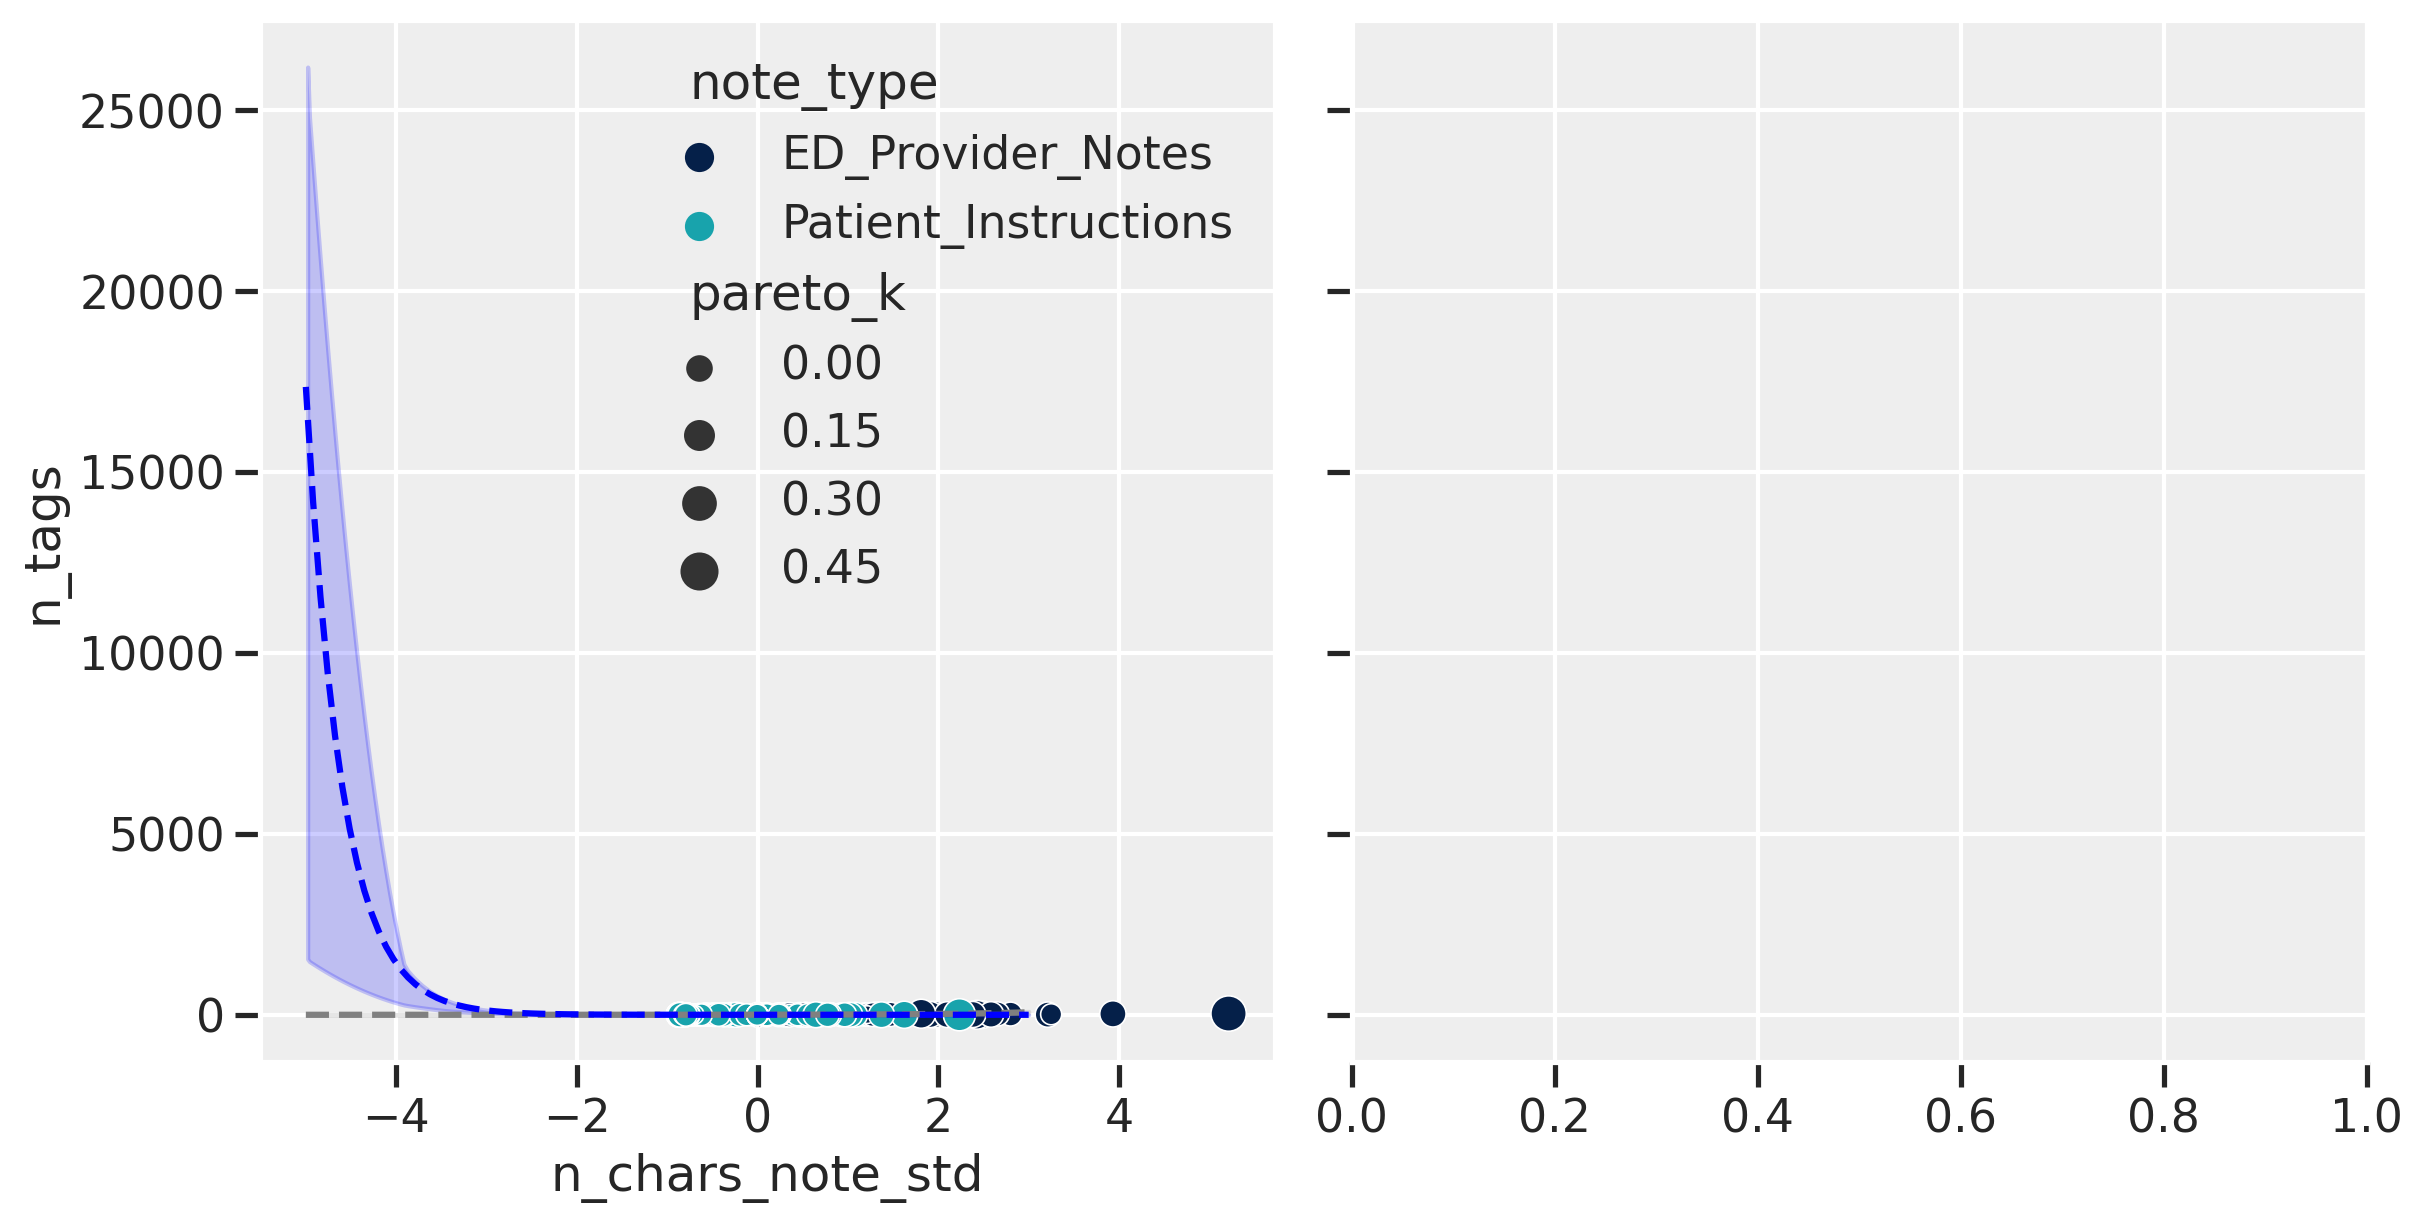

<IPython.core.display.Javascript object>

In [247]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)


# Left subplot   -----------------------------------------
sns.scatterplot(
    data=df_srfs_counts_lim,
    x="n_chars_note_std",
    y="n_tags",
    hue="note_type",
    palette=sf_palette[0:2],
    size="pareto_k",
    ax=ax1,
)

ax1.plot(df_t_pred0.index, df_t_pred0["avg_tags"], linestyle="dashed", color="gray")

az.plot_hdi(
    df_t_pred0.index,
    df_t_pred0.iloc[:, 0:4000].T,
    ax=ax1,
    color="gray",
    fill_kwargs={"alpha": 0.2},
)

ax1.plot(df_t_pred2.index, df_t_pred2["avg_tags"], linestyle="dashed", color="blue")
az.plot_hdi(
    df_t_pred2.index,
    df_t_pred2.iloc[:, 0:4000].T,
    ax=ax1,
    color="blue",
    fill_kwargs={"alpha": 0.2},
)


## Compare models

In [229]:
az.compare({"m_notes1": trace_m_notes1, "m_notes2": trace_m_notes2})

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank          loo      p_loo       d_loo    weight          se  \
m_notes2     0 -2033.806265  33.008451    0.000000  0.999511   76.180653   
m_notes1     1 -2717.791850  19.253573  683.985585  0.000489  131.087649   

                dse  warning loo_scale  
m_notes2   0.000000     True       log  
m_notes1  96.323833    False       log

<IPython.core.display.Javascript object>

# Zero-inflated Poission

- Clinicians do not ask (perhaps not much time or patient status does not seem like they need to be asked)
- Or some can be due to the note type


$$y_i \text{ ~ } \text{ZIPoisson}(p_i,\lambda_i) $$ 

$$\text{logit}(p_i) = \alpha_p + \beta_px_i$$ 

$$\text{log}(\lambda_i) = \alpha_{\lambda} + \beta_{\lambda}x_i$$ 


*p* represents the probability that a note will contain social data

*lambda* represents the expected value of the outcome y (average)

In [ ]:
 with pm.Model() as m_notes1:
    # 
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_notes1 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
    
az.summary(trace_12_3, round_to=2)

# [OLD NOTES BELOW] Censored cats and survival analysis

These concepts were covered in lecture 13 [here](https://youtu.be/p7g-CgGCS34?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1433). I used the R `rethinking` package to obtain the data. The question is to determine whether black cats are more discriminated against for adoption than other cats.


In [9]:
df_cats = pd.read_csv("other_data/AustinCats.csv", sep=",")
df_cats.head()

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   

                  date_in in_event                   breed              color  \
0  07/07/2016 12:11:00 PM    Stray  Domestic Shorthair Mix         Blue Tabby   
1  05/22/2014 03:43:00 PM    Stray  Domestic Shorthair Mix        Black/White   
2  07/13/2014 01:20:00 PM    Stray            Snowshoe Mix         Lynx Point   
3  08/12/2015 06:29:00 PM    Stray  Domestic Shorthair Mix             Calico   
4  08/23/2016 02:35:00 PM    Stray  Domestic Shorthair Mix  Brown Tabby/White   

   intake_age  
0           7  
1           1  
2           2  
3          12  
4           1

<IPython.core.display.Javascript object>

In [12]:
df_cats.shape

(22356, 11)

<IPython.core.display.Javascript object>

Prepare dataframe as described in the lecture.

In [15]:
# Getting adopted is 1
df_cats["adopt"] = np.where(df_cats["out_event"] == "Adoption", 1, 0)

# It looks like he used black as lower index
df_cats["color_id"] = np.where(df_cats["color"] == "Black", 0, 1)

df_cats.head(10)

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   
5  A756485              4  08/24/2017 05:34:00 PM  Adoption   
6  A732960              4  08/19/2016 06:27:00 PM  Adoption   
7  A664571              5  10/10/2013 02:07:00 PM  Adoption   
8  A727402             24  06/14/2016 04:18:00 PM  Adoption   
9  A749579              2  05/18/2017 03:36:00 PM  Transfer   

                  date_in         in_event                   breed  \
0  07/07/2016 12:11:00 PM            Stray  Domestic Shorthair Mix   
1  05/22/2014 03:43:00 PM            Stray  Domestic Shorthair Mix   
2  07/13/2014 01:20:00 PM            Stray            Snowshoe Mix   
3  08/12/2015 06:29:00 PM            Stray  Domestic Shorthair Mix   
4  08/23/2016 02:35:00 PM            Stray  Domestic Shorthair Mix   
5  08/20/2017 03:07:00 PM            Stray  Domestic Shorthair Mix   
6  08/15/2016 03:08:00 PM            Stray  Domestic Shorthair Mix   
7  10/05/2013 01:43:00 PM  Owner Surrender  Domestic Shorthair Mix   
8  05/21/2016 04:30:00 PM            Stray  Domestic Shorthair Mix   
9  05/16/2017 05:19:00 PM            Stray  Domestic Shorthair Mix   

               color  intake_age  adopt  color_id     color_id  
0         Blue Tabby           7      0            1         1  
1        Black/White           1      0            1         1  
2         Lynx Point           2      1            1         1  
3             Calico          12      0            1         1  
4  Brown Tabby/White           1      0            1         1  
5         Blue Tabby           1      1            1         1  
6             Calico           2      1            1         1  
7             Torbie          24      1            1         1  
8        Brown Tabby           1      1            1         1  
9         Blue Tabby           3      0            1         1

<IPython.core.display.Javascript object>

In [17]:
df_cats["color_id"].value_counts()

1    19391
0     2965
Name: color_id, dtype: int64

<IPython.core.display.Javascript object>

Rojan's code

```
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
   cid=pm.Data('cid',df['black'])
    adopted=pm.intX(pm.Data('adopted',df['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
 D=pm.Potential('D',likelihood(lam=lam,obs_value=df['days_to_event'].values,censored=adopted))
  trace_1=pm.sample()

```

In [18]:
def likelihood(lam, obs_value, censored):
    return censored * tt.log(lam) - lam * obs_value

<IPython.core.display.Javascript object>

In [20]:
with pm.Model() as m_cats1:
    # priors
    a = pm.Normal("a", 0, 1, shape=2)

    mu = pm.math.exp(a[df_cats["color_id"]])
    lam = pm.Deterministic("lam", 1 / mu)

    D = pm.Potential(
        "D",
        likelihood(
            lam=lam,
            obs_value=df_cats["days_to_event"].values,
            censored=df_cats["adopt"],
        ),
    )

    trace_1 = pm.sample(1000, tune=1000, return_inferencedata=True)

NameError: name 'tt' is not defined

<IPython.core.display.Javascript object>

# Question 1 (12H7)

In the Trolley data—`data(Trolley)`—we saw how education level (modeled as an ordered category) is associated with responses. Is this association causal? One plausible confound is that education is also associated with age, through a causal process: People are older when they finish school than when they begin it.

Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statistical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

## Data exploration and setup

In [5]:
df_trolley = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Trolley.csv",
    delimiter=";",
)
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

In [6]:
print("shape of df: ", df_trolley.shape)

shape of df:  (9930, 12)


<IPython.core.display.Javascript object>

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


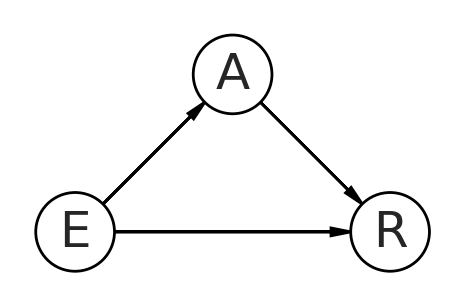

<IPython.core.display.Javascript object>

In [28]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


## Original model

Taken from the book chapter to ensure that I can reproduce the results before adding the education variable.

### Model equation

$$R_i \text{ ~ } \text{Ordered-logit}(\phi_i,\kappa) \tag{probability of data}$$ 

$$\phi_i = 0 \tag{linear model}$$ 

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5) \tag{common prior for each intercept}$$

However, he states that the model can be re-written more literally where we instead use a vector of probabilities **p**.

$$R_i \text{ ~ } \text{Categorical}(\boldsymbol{p}) \tag{probability of data}$$

$$p_1 = q_1 \tag{probabilities of each value k}$$ 

$$p_k = q_k - q_{k-1} \text{  for $K > k > 1$} $$

$$p_k = 1 - q_{k-1} $$

$$\text{logit}(q_k) = \kappa_k - \phi_i  \tag{cumulative logit link}$$ 

$$\phi_i = \text{terms of linear model}  \tag{linear model}$$

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5)  \tag{common prior for each intercept}$$



Note that McElreath uses Greek letter \(\kappa\) (kappa) to refer to the intercepts but he switches to using \(\alpha\) later.


In [8]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

### Intercept only model

Here is the setup in pymc as taken from the repo. Per McElreath's text: "In code form for either quap and ulam, the link function will be embedded in the likelihood function already." McElreath cautions that this can take a while but it only took ~30 seconds for me.

In [12]:
with pm.Model() as m12_4:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,  # array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=df_trolley["response"] - 1)
    
    # Get posterior
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

In [13]:
az.summary(trace_12_4)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
cutpoints[0] -1.917  0.030    -1.961     -1.866        0.0      0.0    4392.0   
cutpoints[1] -1.266  0.024    -1.302     -1.226        0.0      0.0    4999.0   
cutpoints[2] -0.718  0.022    -0.753     -0.685        0.0      0.0    5227.0   
cutpoints[3]  0.248  0.020     0.219      0.283        0.0      0.0    4775.0   
cutpoints[4]  0.890  0.022     0.856      0.926        0.0      0.0    4918.0   
cutpoints[5]  1.770  0.029     1.727      1.817        0.0      0.0    5106.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
cutpoints[0]  4392.0    4396.0    2633.0    1.0  
cutpoints[1]  4999.0    4997.0    3517.0    1.0  
cutpoints[2]  5221.0    5203.0    3520.0    1.0  
cutpoints[3]  4735.0    4795.0    3613.0    1.0  
cutpoints[4]  4918.0    4883.0    3542.0    1.0  
cutpoints[5]  5094.0    5125.0    3798.0    1.0

<IPython.core.display.Javascript object>

In [17]:
trace_12_4_df = trace_12_4.to_dataframe()
trace_12_4_df

chain  draw  (posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0         0     0                     -1.944997                     -1.271992   
1         0     1                     -1.891395                     -1.259263   
2         0     2                     -1.902102                     -1.269827   
3         0     3                     -1.913761                     -1.259292   
4         0     4                     -1.886907                     -1.256226   
...     ...   ...                           ...                           ...   
3995      3   995                     -1.900627                     -1.243956   
3996      3   996                     -1.912429                     -1.263198   
3997      3   997                     -1.909409                     -1.258437   
3998      3   998                     -1.949809                     -1.282035   
3999      3   999                     -1.949211                     -1.266982   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -0.723195                      0.262819   
1                        -0.718099                      0.223384   
2                        -0.699676                      0.270881   
3                        -0.734792                      0.225806   
4                        -0.724622                      0.226160   
...                            ...                           ...   
3995                     -0.678162                      0.277044   
3996                     -0.723993                      0.255216   
3997                     -0.737196                      0.255319   
3998                     -0.719329                      0.225058   
3999                     -0.706837                      0.237230   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  \
0                         0.889961                      1.767569   
1                         0.871716                      1.732266   
2                         0.904259                      1.786165   
3                         0.879706                      1.766346   
4                         0.851608                      1.738584   
...                            ...                           ...   
3995                      0.910309                      1.791648   
3996                      0.907415                      1.784581   
3997                      0.881452                      1.763388   
3998                      0.869017                      1.709517   
3999                      0.882233                      1.735843   

      (log_likelihood, R[0], 0)  (log_likelihood, R[1000], 1000)  ...  \
0                     -1.432802                        -1.432802  ...   
1                     -1.479273                        -1.479273  ...   
2                     -1.446362                        -1.446362  ...   
3                     -1.460722                        -1.460722  ...   
4                     -1.470006                        -1.470006  ...   
...                         ...                              ...  ...   
3995                  -1.460373                        -1.460373  ...   
3996                  -1.439925                        -1.439925  ...   
3997                  -1.427668                        -1.427668  ...   
3998                  -1.476275                        -1.476275  ...   
3999                  -1.475201                        -1.475201  ...   

      (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                              0.002530                        7.0   
1                              0.002538                        7.0   
2                              0.002506                        7.0   
3                              0.002469                        7.0   
4                              0.002450                        7.0   
...                                 ...                        ...   
3995                           0

<IPython.core.display.Javascript object>

In [31]:
cutpoints_mean = trace_12_4_df[
    [("posterior", "cutpoints" + str([i]), i) for i in range(6)]
].mean()
cutpoints_mean

(posterior, cutpoints[0], 0)   -1.916689
(posterior, cutpoints[1], 1)   -1.266421
(posterior, cutpoints[2], 2)   -0.718219
(posterior, cutpoints[3], 3)    0.247919
(posterior, cutpoints[4], 4)    0.890110
(posterior, cutpoints[5], 5)    1.769816
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
# Get cumulative probabilities back
logistic(cutpoints_mean.round(3))

(posterior, cutpoints[0], 0)    0.128196
(posterior, cutpoints[1], 1)    0.219943
(posterior, cutpoints[2], 2)    0.327834
(posterior, cutpoints[3], 3)    0.561684
(posterior, cutpoints[4], 4)    0.708890
(posterior, cutpoints[5], 5)    0.854458
dtype: float64

<IPython.core.display.Javascript object>

### Model with predictor variables

We'll define a linear model $\phi_i = \beta x_i$, then each cumulative logit becomes:

$$\text{log} \frac{\text{Pr}(y_i \leq k)}{1-\text{Pr}(y_i \leq k)} = \alpha_k - \phi_i $$

$$\phi_i = \beta x_i$$


Note here \(\alpha\) is referring to the intercept term when he had used \(\kappa\) before.

In [33]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

This cell took a little bit longer to run.

In [36]:
with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", df_trolley["action"])
    I = pm.Data("I", df_trolley["intention"])
    C = pm.Data("C", df_trolley["contact"])
    
    # This defines the interaction of intention between action and contact
    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"]-1
    )

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]
INFO:pymc3:NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.


<IPython.core.display.Javascript object>

### Prior predictions of cutpoints

In [99]:
with m12_5:
    prior_pc = pm.sample_prior_predictive(var_names=["cutpoints"])

prior_pc

{'cutpoints': array([[ 2.40881536, -0.06909538,  0.58876406,  1.07911596,  2.5537707 ,
          0.17473549],
        [-0.81413412,  1.10268131,  1.88062775,  2.73549682,  3.09621419,
          3.44499542],
        [ 2.72600897, -1.15727882,  0.02118839, -0.11120756, -2.47700243,
          0.5211727 ],
        ...,
        [-2.063783  ,  1.91094787, -0.96913303,  1.09510147, -1.65974805,
         -2.12935767],
        [ 0.95381452, -1.29847266,  1.13118909, -0.51264924, -0.71262614,
         -0.13326437],
        [-0.63746982, -1.54732726, -1.54749521, -0.93351485,  2.2128514 ,
          1.30570333]])}

<IPython.core.display.Javascript object>

In [102]:
# take the mean - I think they're going to be the same for each value which is not unexpected
prior_pc["cutpoints"].mean(axis=0)

array([ 0.06385636, -0.03095438, -0.09597819, -0.05418203,  0.01350345,
       -0.07086131])

<IPython.core.display.Javascript object>

In [104]:
prior_pc["cutpoints"].std(axis=0)

array([1.45124622, 1.50078034, 1.57389352, 1.4521123 , 1.43878856,
       1.48524719])

<IPython.core.display.Javascript object>

In [103]:
np.arange(6) - 2.5

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

<IPython.core.display.Javascript object>

In [ ]:
# code frm repo
# idata = az.from_pymc3(trace_12_5)
# az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

In [50]:
trace_12_5_df = trace_12_5.to_dataframe()
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [37]:
az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
bIC -1.24  0.10     -1.40      -1.09        0.0      0.0   2595.09  2595.09   
bIA -0.43  0.08     -0.57      -0.32        0.0      0.0   2444.25  2411.62   
bC  -0.34  0.07     -0.46      -0.24        0.0      0.0   2462.52  2450.59   
bI  -0.29  0.06     -0.39      -0.21        0.0      0.0   2204.02  2192.90   
bA  -0.47  0.05     -0.56      -0.39        0.0      0.0   2412.44  2412.44   

     ess_bulk  ess_tail  r_hat  
bIC   2602.01   3019.21    1.0  
bIA   2443.48   2557.96    1.0  
bC    2459.41   2884.44    1.0  
bI    2200.24   2552.76    1.0  
bA    2413.97   2218.64    1.0

<IPython.core.display.Javascript object>

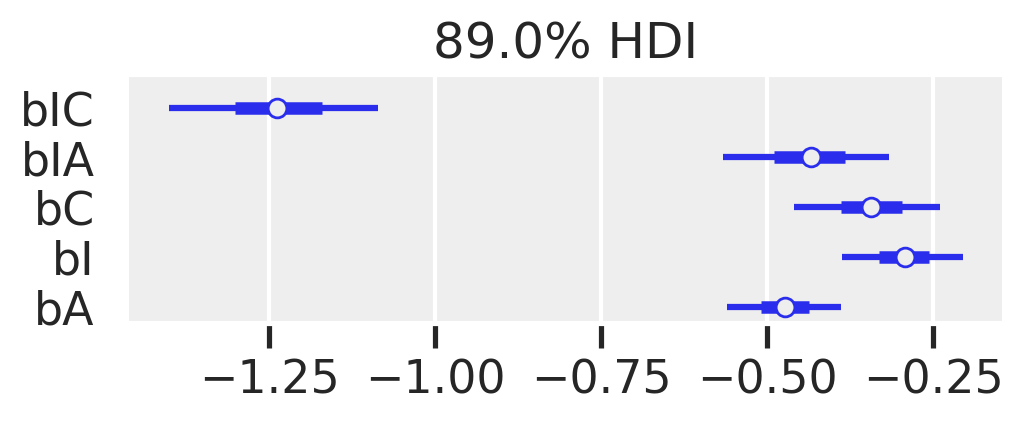

<IPython.core.display.Javascript object>

In [38]:
f, ax1 = plt.subplots(figsize=(5, 2))
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, ax=ax1
)

This is showing the combination of intention and contact is the worst, despite the fact that each by themselves isn't showing a large impact on the ratings. Let's plot the posterior predictions.

### Plot posterior predictions

It will be easier to understand, but this is a challenge since each prediction is a vector of probabilities. We'll need to create a function that generates these predictions using the parameters of our posterior predictions. We can use the full posterior (analagous to the `sim` function) or something akin to the `link` function. McElreath's  R code 12.27 uses link. Let's take a quick look at the posterior.

#### My own code

In [51]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [72]:
def link_pp(trace, post_bA, post_bC, post_bI, post_bIA, post_bIC, in_I, in_A, in_C):
    """
    Use the model definition to generate phi.
    Input: posterior parameters and values for I, A, C
    Output: Phi (no additional sigma term?)
    """

    BI = trace[post_bI] + trace[post_bIA] * in_A + trace[post_bIC] * in_C

    phi = trace[post_bA] * in_A + trace[post_bC] * in_C + BI * in_I

    return phi

<IPython.core.display.Javascript object>

In [80]:
phi_post_0 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    0,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [81]:
phi_post_1 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    1,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [87]:
np.array([phi_post_0, phi_post_1]).reshape(-1, 2)

array([[-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       ...,
       [-0.25219887, -0.20182651],
       [-0.27349092, -0.31649199],
       [-0.24608546, -0.23015046]])

<IPython.core.display.Javascript object>

We have determined phi for two different values of intent (while holding A and C to 0). What is phi referring to? it is the outcome of the linear model for which we subtract from the intercept terms. Remember that each intercept term is a cutpoint for a particular response. And a cutpoint is cumulative probability value for that response. Let's take a look at the first cutpoint that resulted from generating the posterior distribution.

In [93]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, perf_counter_diff)  (sample_stats, tree_size)  \
0                           0.113647                       31.0   
1                           0.029954                        7.0   
2                           0.058909                       15.0   
3                           0.056423                       15.0   
4                           0.087785                       23.0   

   (sample_stats, step_size)  (sample_stats, diverging)  \
0                   0.392687                      False   
1                   0.392687                      False   
2                   0.392687                      False   
3                   0.392687                      False   
4                   0.392687                      False   

   (sample_stats, energy)  (sample_stats, max_energy_error)  \
0            18482.352379                          1.673077   
1            18481.945491                         -0.233171   
2            18484.577023                          0.789485   
3            18485.363774                          0.889859   
4            18485.510930                          3.129888   

   (sample_stats, process_time_diff)  (sample_stats, energy_error)  \
0                           0.113287                     -0.333714   
1                           0.029841                     -0.125865   
2                           0.058776                     -0.012350   
3                           0.056351                      0.710361   
4                           0.087489                     -0.599234   

   (sample_stats, perf_counter_start)  (sample_stats, lp)  
0                         4485.006096       -18476.163278  
1                         4485.119948       -18477.479533  
2                         4485.150092       -18477.445982  
3                         4485.209205       -18481.317360  
4                         4485.265834       -18476.097258  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [108]:
cutpoints_col = [("posterior", "cutpoints" + "[" + str(i) + "]", i) for i in range(6)]
cutpoints_col

[('posterior', 'cutpoints[0]', 0),
 ('posterior', 'cutpoints[1]', 1),
 ('posterior', 'cutpoints[2]', 2),
 ('posterior', 'cutpoints[3]', 3),
 ('posterior', 'cutpoints[4]', 4),
 ('posterior', 'cutpoints[5]', 5)]

<IPython.core.display.Javascript object>

In [109]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [116]:
prior_pc["cutpoints"].mean(axis=0)

array([ 0.06385636, -0.03095438, -0.09597819, -0.05418203,  0.01350345,
       -0.07086131])

<IPython.core.display.Javascript object>

In [133]:
phi_post_0

0      -0.0
1      -0.0
2      -0.0
3      -0.0
4      -0.0
       ... 
3995   -0.0
3996   -0.0
3997   -0.0
3998   -0.0
3999   -0.0
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [128]:
# Compare prior and posterior cutpoint means
cutpoints_pre_post = pd.DataFrame(
    {
        "prior_cutpoints": prior_pc["cutpoints"].mean(axis=0),
        "posterior_cutpoints": np.array(trace_12_5_df[cutpoints_col].mean()),
    }
)

cutpoints_pre_post

prior_cutpoints  posterior_cutpoints
0         0.063856            -2.635954
1        -0.030954            -1.939398
2        -0.095978            -1.344338
3        -0.054182            -0.309179
4         0.013503             0.362014
5        -0.070861             1.267736

<IPython.core.display.Javascript object>

The prior cutpoints do not increase monotonically but the posterior cutpoints do. We can get back the values in terms of probabilities like this:

In [131]:
logistic(cutpoints_pre_post["prior_cutpoints"])

0    0.515959
1    0.492262
2    0.476024
3    0.486458
4    0.503376
5    0.482292
Name: prior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

You can see that the prior cutpoints were really naive and just assumed that they all got around half of the responses. This is not totally logical but there's a lot of data so it doesn't matter.

In [130]:
logistic(cutpoints_pre_post["posterior_cutpoints"])

0    0.066860
1    0.125714
2    0.206798
3    0.423315
4    0.589528
5    0.780355
Name: posterior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

The posterior shows monotonically increasing cumulative probabilities as we expect. For the code related to the cutpoints, I did not yet factor in the linear model's phi term yet. We can easily do that by subtracting that out. We can also use the full posterior.

In [134]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [142]:
def pordlogit_a(trace, sample_ind, phi_0, phi_1):
    """
    Input: Posterior cutpoints (intercept terms) and the phi values (posterior resulting from linear model)
    Output: Two vectors, one of I=0 and one of I=1. Each vector of discrete probabilities for each sample
    of the posterior distribution.
    """
    
    pk0 = trace.loc[sample_ind, cutpoints_col] - phi_post_0.iloc[sample_ind]
    pk1 = trace.loc[sample_ind, cutpoints_col] - phi_post_1.iloc[sample_ind]
    
    # Convert to probabilities
    pk0 = [logistic(i) for i in pk0]
    pk1 = [logistic(i) for i in pk1]
    
    return pk0, pk1


<IPython.core.display.Javascript object>

In [145]:
# This is showing how the probabilities shift
pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)

([0.06535514737138368,
  0.12395697771404639,
  0.2015017549891868,
  0.4178054321389652,
  0.5895139025149484,
  0.7838998829286381],
 [0.08846562011541892,
  0.16415040967935604,
  0.2593942034408662,
  0.49900656606798516,
  0.6659160607935606,
  0.8342917730001637])

<IPython.core.display.Javascript object>

**Generate plots**

### Questions

- No scaling term? link equivalent to sim and sample_posterior_predictive?
- kappa changed to alpha?

In [146]:
# posterior predictive

with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )

<IPython.core.display.Javascript object>

In [147]:
pp_resp

{'resp_obs': array([[3, 3, 3, 3, 0, 0],
        [4, 6, 4, 3, 1, 4],
        [3, 5, 1, 1, 4, 5],
        ...,
        [1, 5, 3, 3, 4, 0],
        [4, 6, 3, 4, 2, 0],
        [3, 6, 6, 4, 5, 2]])}

<IPython.core.display.Javascript object>

In [ ]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

In [110]:
trace_12_5_df[cutpoints_col].mean()

(posterior, cutpoints[0], 0)   -2.635954
(posterior, cutpoints[1], 1)   -1.939398
(posterior, cutpoints[2], 2)   -1.344338
(posterior, cutpoints[3], 3)   -0.309179
(posterior, cutpoints[4], 4)    0.362014
(posterior, cutpoints[5], 5)    1.267736
dtype: float64

<IPython.core.display.Javascript object>

In [111]:
trace_12_5_df[cutpoints_col].std()

(posterior, cutpoints[0], 0)    0.052183
(posterior, cutpoints[1], 1)    0.047757
(posterior, cutpoints[2], 2)    0.045295
(posterior, cutpoints[3], 3)    0.043103
(posterior, cutpoints[4], 4)    0.043428
(posterior, cutpoints[5], 5)    0.046546
dtype: float64

<IPython.core.display.Javascript object>

#### Repo code

In [39]:
# Observed cum probs (from repo, great code)
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

Remember, these are cumulative probabilities. We wouldn't expect them to sum to 1 but they should monotonically increase. Below is just plotting the first row. The last value is not shown but will be 1.

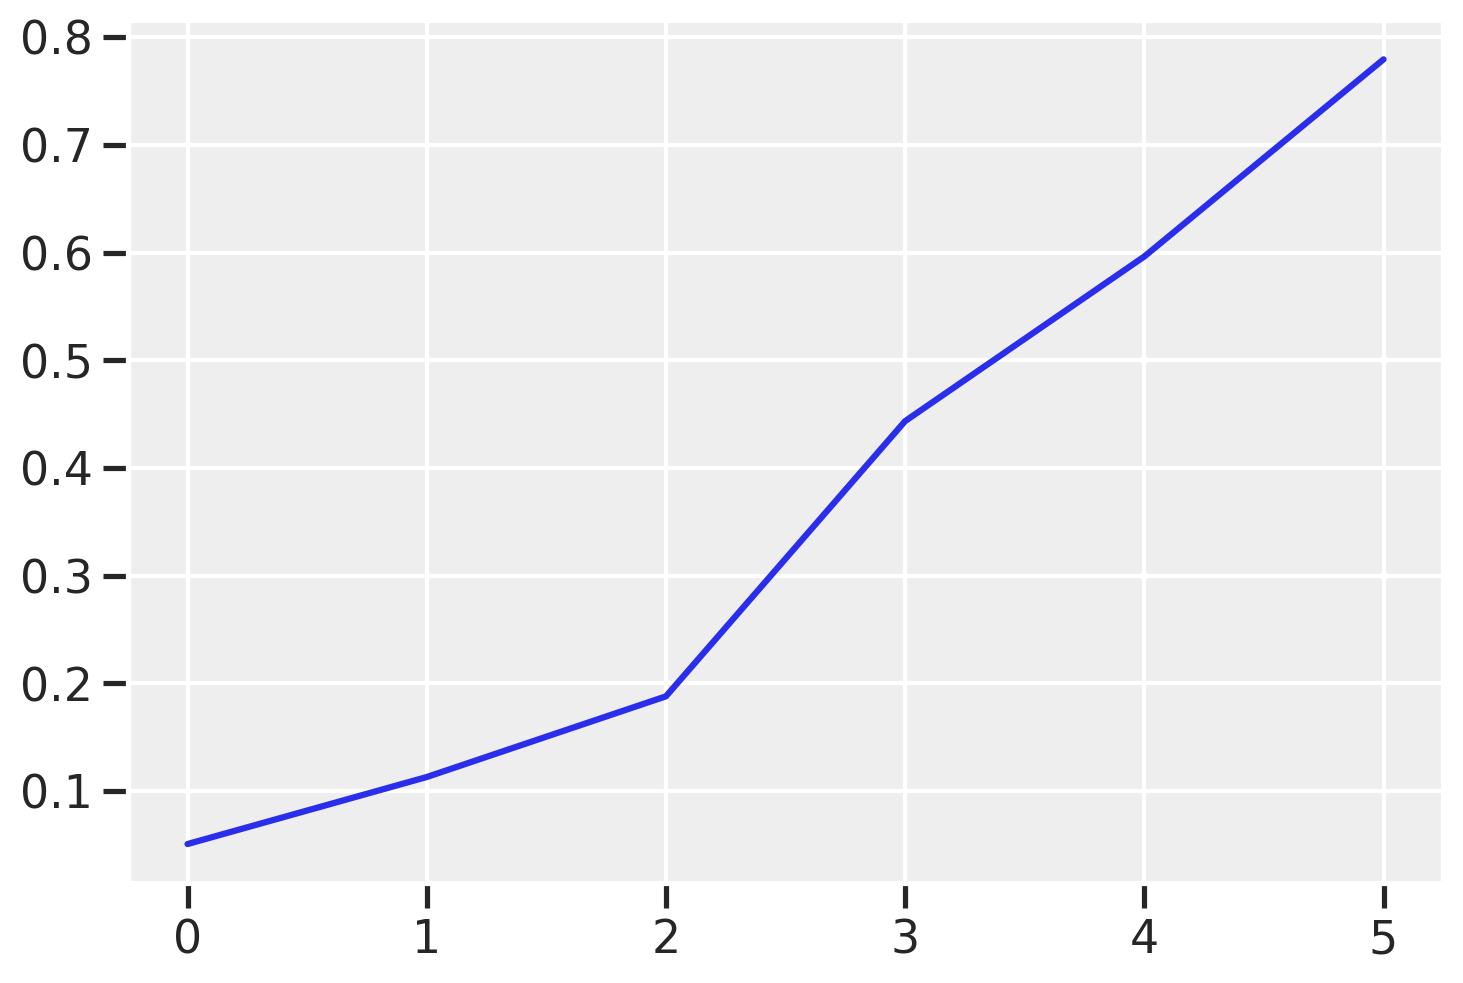

<IPython.core.display.Javascript object>

In [49]:
f, ax1 = plt.subplots()
ax1.plot(p_obs.iloc[0, :])

In [40]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

action  contact  intention
0       0        0          0
1       0        0          1
2       1        0          0
3       1        0          1
4       0        1          0
5       0        1          1

<IPython.core.display.Javascript object>

In [41]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

<IPython.core.display.Javascript object>

In [52]:
pp_phi

array([[-0.        , -0.32781511, -0.50514052, -1.25842574, -0.31880184,
        -1.79663537],
       [-0.        , -0.30497069, -0.43482973, -1.16432285, -0.45798883,
        -1.86823832],
       [-0.        , -0.32604677, -0.45021825, -1.22297916, -0.37751014,
        -1.91681543],
       ...,
       [-0.        , -0.31649199, -0.51758153, -1.23487916, -0.31441999,
        -1.86091079],
       [-0.        , -0.24608546, -0.46204498, -1.16929504, -0.3795551 ,
        -1.85152211],
       [-0.        , -0.23015046, -0.46778073, -1.14086975, -0.29713445,
        -1.79953398]])

<IPython.core.display.Javascript object>

In [88]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

<IPython.core.display.Javascript object>

In [92]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2554]', 2554)
('posterior', 'phi[2555]', 2555)
('posterior', 'phi[2556]', 2556)
('posterior', 'phi[2557]', 2557)
('posterior', 'phi[2558]', 2558)
('posterior', 'phi[2559]', 2559)
('posterior', 'phi[255]', 255)
('posterior', 'phi[2560]', 2560)
('posterior', 'phi[2561]', 2561)
('posterior', 'phi[2562]', 2562)
('posterior', 'phi[2563]', 2563)
('posterior', 'phi[2564]', 2564)
('posterior', 'phi[2565]', 2565)
('posterior', 'phi[2566]', 2566)
('posterior', 'phi[2567]', 2567)
('posterior', 'phi[2568]', 2568)
('posterior', 'phi[2569]', 2569)
('posterior', 'phi[256]', 256)
('posterior', 'phi[2570]', 2570)
('posterior', 'phi[2571]', 2571)
('posterior', 'phi[2572]', 2572)
('posterior', 'phi[2573]', 2573)
('posterior', 'phi[2574]', 2574)
('posterior', 'phi[2575]', 2575)
('posterior', 'phi[2576]', 2576)
('posterior', 'phi[2577]', 2577)
('posterior', 'phi[2578]', 2578)
('posterior', 'phi[2579]', 2579)
('posterior', 'phi[257]', 257)
('posterior', 'phi[2580]', 2580)
('posterior', 'p

('posterior', 'phi[3904]', 3904)
('posterior', 'phi[3905]', 3905)
('posterior', 'phi[3906]', 3906)
('posterior', 'phi[3907]', 3907)
('posterior', 'phi[3908]', 3908)
('posterior', 'phi[3909]', 3909)
('posterior', 'phi[390]', 390)
('posterior', 'phi[3910]', 3910)
('posterior', 'phi[3911]', 3911)
('posterior', 'phi[3912]', 3912)
('posterior', 'phi[3913]', 3913)
('posterior', 'phi[3914]', 3914)
('posterior', 'phi[3915]', 3915)
('posterior', 'phi[3916]', 3916)
('posterior', 'phi[3917]', 3917)
('posterior', 'phi[3918]', 3918)
('posterior', 'phi[3919]', 3919)
('posterior', 'phi[391]', 391)
('posterior', 'phi[3920]', 3920)
('posterior', 'phi[3921]', 3921)
('posterior', 'phi[3922]', 3922)
('posterior', 'phi[3923]', 3923)
('posterior', 'phi[3924]', 3924)
('posterior', 'phi[3925]', 3925)
('posterior', 'phi[3926]', 3926)
('posterior', 'phi[3927]', 3927)
('posterior', 'phi[3928]', 3928)
('posterior', 'phi[3929]', 3929)
('posterior', 'phi[392]', 392)
('posterior', 'phi[3930]', 3930)
('posterior', 'p

('posterior', 'phi[5253]', 5253)
('posterior', 'phi[5254]', 5254)
('posterior', 'phi[5255]', 5255)
('posterior', 'phi[5256]', 5256)
('posterior', 'phi[5257]', 5257)
('posterior', 'phi[5258]', 5258)
('posterior', 'phi[5259]', 5259)
('posterior', 'phi[525]', 525)
('posterior', 'phi[5260]', 5260)
('posterior', 'phi[5261]', 5261)
('posterior', 'phi[5262]', 5262)
('posterior', 'phi[5263]', 5263)
('posterior', 'phi[5264]', 5264)
('posterior', 'phi[5265]', 5265)
('posterior', 'phi[5266]', 5266)
('posterior', 'phi[5267]', 5267)
('posterior', 'phi[5268]', 5268)
('posterior', 'phi[5269]', 5269)
('posterior', 'phi[526]', 526)
('posterior', 'phi[5270]', 5270)
('posterior', 'phi[5271]', 5271)
('posterior', 'phi[5272]', 5272)
('posterior', 'phi[5273]', 5273)
('posterior', 'phi[5274]', 5274)
('posterior', 'phi[5275]', 5275)
('posterior', 'phi[5276]', 5276)
('posterior', 'phi[5277]', 5277)
('posterior', 'phi[5278]', 5278)
('posterior', 'phi[5279]', 5279)
('posterior', 'phi[527]', 527)
('posterior', 'p

('posterior', 'phi[6754]', 6754)
('posterior', 'phi[6755]', 6755)
('posterior', 'phi[6756]', 6756)
('posterior', 'phi[6757]', 6757)
('posterior', 'phi[6758]', 6758)
('posterior', 'phi[6759]', 6759)
('posterior', 'phi[675]', 675)
('posterior', 'phi[6760]', 6760)
('posterior', 'phi[6761]', 6761)
('posterior', 'phi[6762]', 6762)
('posterior', 'phi[6763]', 6763)
('posterior', 'phi[6764]', 6764)
('posterior', 'phi[6765]', 6765)
('posterior', 'phi[6766]', 6766)
('posterior', 'phi[6767]', 6767)
('posterior', 'phi[6768]', 6768)
('posterior', 'phi[6769]', 6769)
('posterior', 'phi[676]', 676)
('posterior', 'phi[6770]', 6770)
('posterior', 'phi[6771]', 6771)
('posterior', 'phi[6772]', 6772)
('posterior', 'phi[6773]', 6773)
('posterior', 'phi[6774]', 6774)
('posterior', 'phi[6775]', 6775)
('posterior', 'phi[6776]', 6776)
('posterior', 'phi[6777]', 6777)
('posterior', 'phi[6778]', 6778)
('posterior', 'phi[6779]', 6779)
('posterior', 'phi[677]', 677)
('posterior', 'phi[6780]', 6780)
('posterior', 'p

('posterior', 'phi[8402]', 8402)
('posterior', 'phi[8403]', 8403)
('posterior', 'phi[8404]', 8404)
('posterior', 'phi[8405]', 8405)
('posterior', 'phi[8406]', 8406)
('posterior', 'phi[8407]', 8407)
('posterior', 'phi[8408]', 8408)
('posterior', 'phi[8409]', 8409)
('posterior', 'phi[840]', 840)
('posterior', 'phi[8410]', 8410)
('posterior', 'phi[8411]', 8411)
('posterior', 'phi[8412]', 8412)
('posterior', 'phi[8413]', 8413)
('posterior', 'phi[8414]', 8414)
('posterior', 'phi[8415]', 8415)
('posterior', 'phi[8416]', 8416)
('posterior', 'phi[8417]', 8417)
('posterior', 'phi[8418]', 8418)
('posterior', 'phi[8419]', 8419)
('posterior', 'phi[841]', 841)
('posterior', 'phi[8420]', 8420)
('posterior', 'phi[8421]', 8421)
('posterior', 'phi[8422]', 8422)
('posterior', 'phi[8423]', 8423)
('posterior', 'phi[8424]', 8424)
('posterior', 'phi[8425]', 8425)
('posterior', 'phi[8426]', 8426)
('posterior', 'phi[8427]', 8427)
('posterior', 'phi[8428]', 8428)
('posterior', 'phi[8429]', 8429)
('posterior', 

('posterior', 'phi[9753]', 9753)
('posterior', 'phi[9754]', 9754)
('posterior', 'phi[9755]', 9755)
('posterior', 'phi[9756]', 9756)
('posterior', 'phi[9757]', 9757)
('posterior', 'phi[9758]', 9758)
('posterior', 'phi[9759]', 9759)
('posterior', 'phi[975]', 975)
('posterior', 'phi[9760]', 9760)
('posterior', 'phi[9761]', 9761)
('posterior', 'phi[9762]', 9762)
('posterior', 'phi[9763]', 9763)
('posterior', 'phi[9764]', 9764)
('posterior', 'phi[9765]', 9765)
('posterior', 'phi[9766]', 9766)
('posterior', 'phi[9767]', 9767)
('posterior', 'phi[9768]', 9768)
('posterior', 'phi[9769]', 9769)
('posterior', 'phi[976]', 976)
('posterior', 'phi[9770]', 9770)
('posterior', 'phi[9771]', 9771)
('posterior', 'phi[9772]', 9772)
('posterior', 'phi[9773]', 9773)
('posterior', 'phi[9774]', 9774)
('posterior', 'phi[9775]', 9775)
('posterior', 'phi[9776]', 9776)
('posterior', 'phi[9777]', 9777)
('posterior', 'phi[9778]', 9778)
('posterior', 'phi[9779]', 9779)
('posterior', 'phi[977]', 977)
('posterior', 'p

('log_likelihood', 'resp_obs[0,2581]', 0, 2581)
('log_likelihood', 'resp_obs[0,2582]', 0, 2582)
('log_likelihood', 'resp_obs[0,2583]', 0, 2583)
('log_likelihood', 'resp_obs[0,2584]', 0, 2584)
('log_likelihood', 'resp_obs[0,2585]', 0, 2585)
('log_likelihood', 'resp_obs[0,2586]', 0, 2586)
('log_likelihood', 'resp_obs[0,2587]', 0, 2587)
('log_likelihood', 'resp_obs[0,2588]', 0, 2588)
('log_likelihood', 'resp_obs[0,2589]', 0, 2589)
('log_likelihood', 'resp_obs[0,258]', 0, 258)
('log_likelihood', 'resp_obs[0,2590]', 0, 2590)
('log_likelihood', 'resp_obs[0,2591]', 0, 2591)
('log_likelihood', 'resp_obs[0,2592]', 0, 2592)
('log_likelihood', 'resp_obs[0,2593]', 0, 2593)
('log_likelihood', 'resp_obs[0,2594]', 0, 2594)
('log_likelihood', 'resp_obs[0,2595]', 0, 2595)
('log_likelihood', 'resp_obs[0,2596]', 0, 2596)
('log_likelihood', 'resp_obs[0,2597]', 0, 2597)
('log_likelihood', 'resp_obs[0,2598]', 0, 2598)
('log_likelihood', 'resp_obs[0,2599]', 0, 2599)
('log_likelihood', 'resp_obs[0,259]', 0, 2

('log_likelihood', 'resp_obs[0,3928]', 0, 3928)
('log_likelihood', 'resp_obs[0,3929]', 0, 3929)
('log_likelihood', 'resp_obs[0,392]', 0, 392)
('log_likelihood', 'resp_obs[0,3930]', 0, 3930)
('log_likelihood', 'resp_obs[0,3931]', 0, 3931)
('log_likelihood', 'resp_obs[0,3932]', 0, 3932)
('log_likelihood', 'resp_obs[0,3933]', 0, 3933)
('log_likelihood', 'resp_obs[0,3934]', 0, 3934)
('log_likelihood', 'resp_obs[0,3935]', 0, 3935)
('log_likelihood', 'resp_obs[0,3936]', 0, 3936)
('log_likelihood', 'resp_obs[0,3937]', 0, 3937)
('log_likelihood', 'resp_obs[0,3938]', 0, 3938)
('log_likelihood', 'resp_obs[0,3939]', 0, 3939)
('log_likelihood', 'resp_obs[0,393]', 0, 393)
('log_likelihood', 'resp_obs[0,3940]', 0, 3940)
('log_likelihood', 'resp_obs[0,3941]', 0, 3941)
('log_likelihood', 'resp_obs[0,3942]', 0, 3942)
('log_likelihood', 'resp_obs[0,3943]', 0, 3943)
('log_likelihood', 'resp_obs[0,3944]', 0, 3944)
('log_likelihood', 'resp_obs[0,3945]', 0, 3945)
('log_likelihood', 'resp_obs[0,3946]', 0, 39

('log_likelihood', 'resp_obs[0,5313]', 0, 5313)
('log_likelihood', 'resp_obs[0,5314]', 0, 5314)
('log_likelihood', 'resp_obs[0,5315]', 0, 5315)
('log_likelihood', 'resp_obs[0,5316]', 0, 5316)
('log_likelihood', 'resp_obs[0,5317]', 0, 5317)
('log_likelihood', 'resp_obs[0,5318]', 0, 5318)
('log_likelihood', 'resp_obs[0,5319]', 0, 5319)
('log_likelihood', 'resp_obs[0,531]', 0, 531)
('log_likelihood', 'resp_obs[0,5320]', 0, 5320)
('log_likelihood', 'resp_obs[0,5321]', 0, 5321)
('log_likelihood', 'resp_obs[0,5322]', 0, 5322)
('log_likelihood', 'resp_obs[0,5323]', 0, 5323)
('log_likelihood', 'resp_obs[0,5324]', 0, 5324)
('log_likelihood', 'resp_obs[0,5325]', 0, 5325)
('log_likelihood', 'resp_obs[0,5326]', 0, 5326)
('log_likelihood', 'resp_obs[0,5327]', 0, 5327)
('log_likelihood', 'resp_obs[0,5328]', 0, 5328)
('log_likelihood', 'resp_obs[0,5329]', 0, 5329)
('log_likelihood', 'resp_obs[0,532]', 0, 532)
('log_likelihood', 'resp_obs[0,5330]', 0, 5330)
('log_likelihood', 'resp_obs[0,5331]', 0, 53

('log_likelihood', 'resp_obs[0,6805]', 0, 6805)
('log_likelihood', 'resp_obs[0,6806]', 0, 6806)
('log_likelihood', 'resp_obs[0,6807]', 0, 6807)
('log_likelihood', 'resp_obs[0,6808]', 0, 6808)
('log_likelihood', 'resp_obs[0,6809]', 0, 6809)
('log_likelihood', 'resp_obs[0,680]', 0, 680)
('log_likelihood', 'resp_obs[0,6810]', 0, 6810)
('log_likelihood', 'resp_obs[0,6811]', 0, 6811)
('log_likelihood', 'resp_obs[0,6812]', 0, 6812)
('log_likelihood', 'resp_obs[0,6813]', 0, 6813)
('log_likelihood', 'resp_obs[0,6814]', 0, 6814)
('log_likelihood', 'resp_obs[0,6815]', 0, 6815)
('log_likelihood', 'resp_obs[0,6816]', 0, 6816)
('log_likelihood', 'resp_obs[0,6817]', 0, 6817)
('log_likelihood', 'resp_obs[0,6818]', 0, 6818)
('log_likelihood', 'resp_obs[0,6819]', 0, 6819)
('log_likelihood', 'resp_obs[0,681]', 0, 681)
('log_likelihood', 'resp_obs[0,6820]', 0, 6820)
('log_likelihood', 'resp_obs[0,6821]', 0, 6821)
('log_likelihood', 'resp_obs[0,6822]', 0, 6822)
('log_likelihood', 'resp_obs[0,6823]', 0, 68

('log_likelihood', 'resp_obs[0,8359]', 0, 8359)
('log_likelihood', 'resp_obs[0,835]', 0, 835)
('log_likelihood', 'resp_obs[0,8360]', 0, 8360)
('log_likelihood', 'resp_obs[0,8361]', 0, 8361)
('log_likelihood', 'resp_obs[0,8362]', 0, 8362)
('log_likelihood', 'resp_obs[0,8363]', 0, 8363)
('log_likelihood', 'resp_obs[0,8364]', 0, 8364)
('log_likelihood', 'resp_obs[0,8365]', 0, 8365)
('log_likelihood', 'resp_obs[0,8366]', 0, 8366)
('log_likelihood', 'resp_obs[0,8367]', 0, 8367)
('log_likelihood', 'resp_obs[0,8368]', 0, 8368)
('log_likelihood', 'resp_obs[0,8369]', 0, 8369)
('log_likelihood', 'resp_obs[0,836]', 0, 836)
('log_likelihood', 'resp_obs[0,8370]', 0, 8370)
('log_likelihood', 'resp_obs[0,8371]', 0, 8371)
('log_likelihood', 'resp_obs[0,8372]', 0, 8372)
('log_likelihood', 'resp_obs[0,8373]', 0, 8373)
('log_likelihood', 'resp_obs[0,8374]', 0, 8374)
('log_likelihood', 'resp_obs[0,8375]', 0, 8375)
('log_likelihood', 'resp_obs[0,8376]', 0, 8376)
('log_likelihood', 'resp_obs[0,8377]', 0, 83

('log_likelihood', 'resp_obs[0,9813]', 0, 9813)
('log_likelihood', 'resp_obs[0,9814]', 0, 9814)
('log_likelihood', 'resp_obs[0,9815]', 0, 9815)
('log_likelihood', 'resp_obs[0,9816]', 0, 9816)
('log_likelihood', 'resp_obs[0,9817]', 0, 9817)
('log_likelihood', 'resp_obs[0,9818]', 0, 9818)
('log_likelihood', 'resp_obs[0,9819]', 0, 9819)
('log_likelihood', 'resp_obs[0,981]', 0, 981)
('log_likelihood', 'resp_obs[0,9820]', 0, 9820)
('log_likelihood', 'resp_obs[0,9821]', 0, 9821)
('log_likelihood', 'resp_obs[0,9822]', 0, 9822)
('log_likelihood', 'resp_obs[0,9823]', 0, 9823)
('log_likelihood', 'resp_obs[0,9824]', 0, 9824)
('log_likelihood', 'resp_obs[0,9825]', 0, 9825)
('log_likelihood', 'resp_obs[0,9826]', 0, 9826)
('log_likelihood', 'resp_obs[0,9827]', 0, 9827)
('log_likelihood', 'resp_obs[0,9828]', 0, 9828)
('log_likelihood', 'resp_obs[0,9829]', 0, 9829)
('log_likelihood', 'resp_obs[0,982]', 0, 982)
('log_likelihood', 'resp_obs[0,9830]', 0, 9830)
('log_likelihood', 'resp_obs[0,9831]', 0, 98

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

KeyError: 'cutpoints'

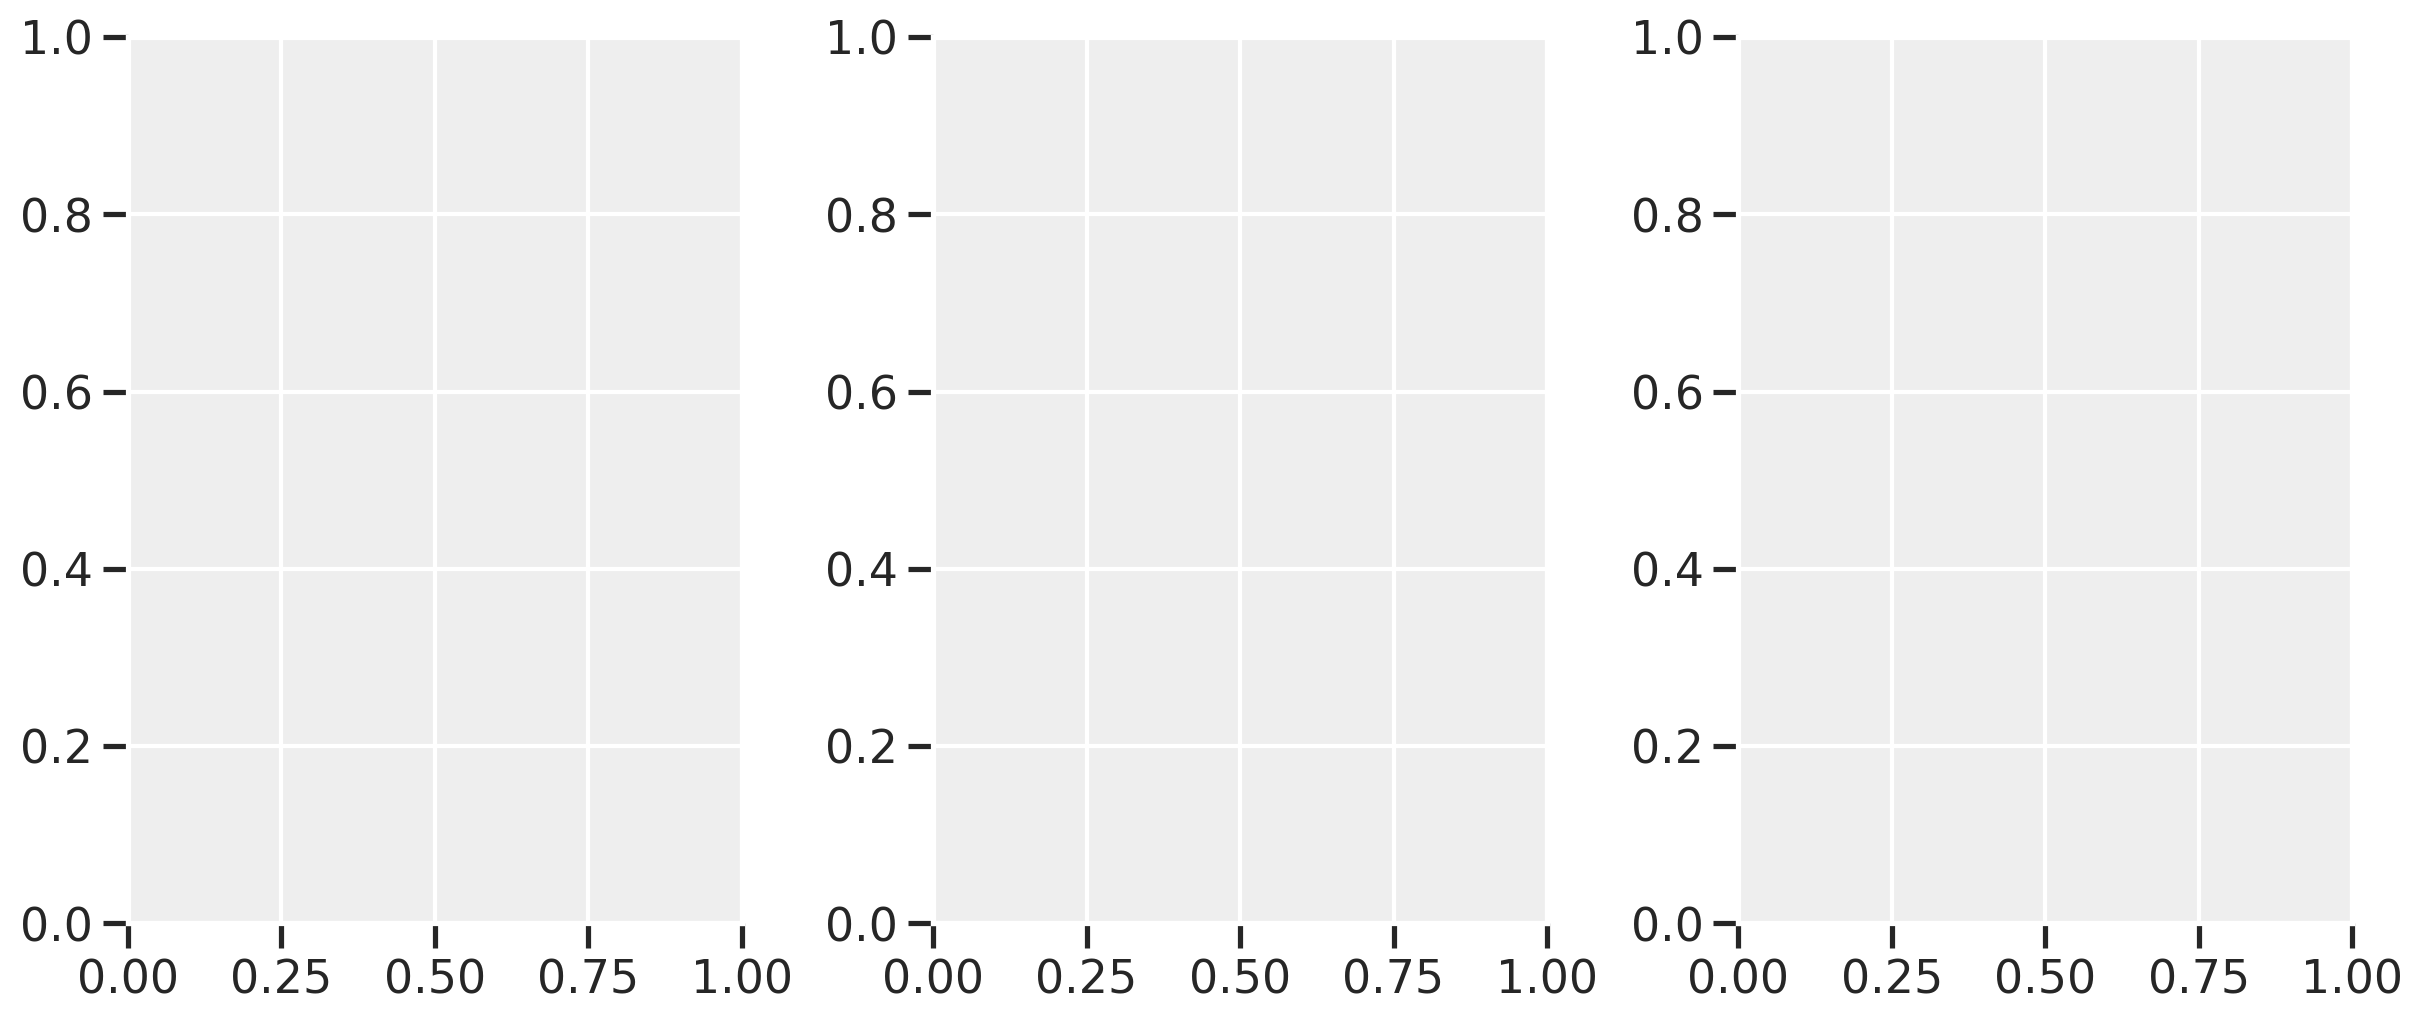

<IPython.core.display.Javascript object>

In [89]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

# Question 2 (11H8)

Consider one more variable in the Trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes response, education, age, and gender.

Using only the DAG, is it possible that the inferences from Problem 1 are confounded by gender? If so, define any additional models you need to infer the causal influence of education on response. What do you conclude?

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


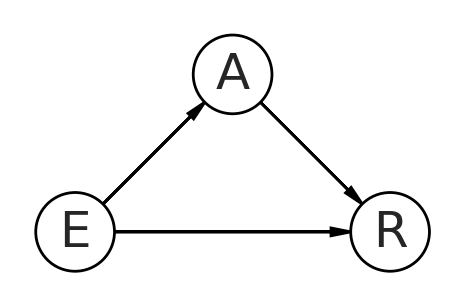

<IPython.core.display.Javascript object>

In [31]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


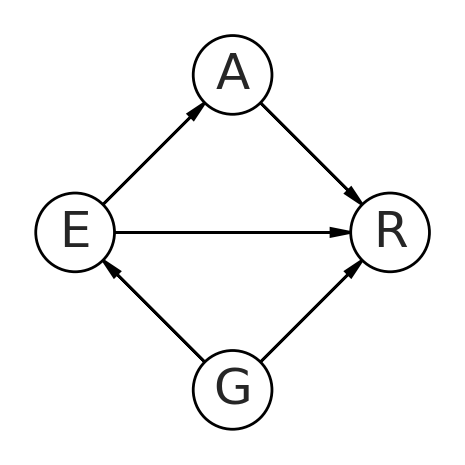

<IPython.core.display.Javascript object>

In [32]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


**Update**

In terms of the paths of G to A, we now have the following:

- G > A (direct)
- G > D > A (D acts as a pipe)
- G > D < US > A (D acts as a collider)

Therefore, we're "hurt" by the fact that we can't answer our question with satisfaction since there are problems whether we condition on D or not.

McElreath's suggestion: "What can be done in these situations? The best thing is to stop analyzing convenient,
confounded data and instead design a real study."

In [37]:
np.array([[1, 2], [3, 4]])**2

array([[ 1,  4],
       [ 9, 16]])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>